In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score,precision_score, recall_score, f1_score

from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestRegressor

In [3]:
import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

def formatar_moeda(valor):
    return locale.currency(valor, grouping=True)

In [4]:
tbl_dam = r'C:\Users\Acer\Projetos\Recife\dados\querys_modelos\tbl_dam_debito_3.csv'
tbl_historico_contribuinte = r'C:\Users\Acer\Projetos\Recife\dados\querys_modelos\tbl_historico_contribuinte_db_29_01.csv'

In [5]:
df_dam = pd.read_csv(tbl_dam, encoding='utf-8')
df_historico_contribuinte = pd.read_csv(tbl_historico_contribuinte, encoding='utf-8')

## MANIPULAÇÃO DE DADOS DA DÍVIDA

In [6]:
df_dam.head()

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,1.0,38.0,2944.10,0.0,2944.10
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,1.0,38.0,2627.70,0.0,2627.70
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2022-01-21,1.0,38.0,3335.10,0.0,3335.10
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2023-01-23,1.0,38.0,3630.40,0.0,3630.40
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2017-01-26,1.0,38.0,2459.37,0.0,2459.37


EURÍSTICA DE MANIPULAÇÃO DE DADOS ADOTADA
dam
ano_fato_gerador
id_imovel
idade_imovel 
vlr_aberto
vlr_pago
area_construida 
tipo_propriedade
bairro
natureza_imovel - tranforma p em 1 e t em 0
NOVA COLUNA chamada vlr_lançado = vlr_aberto + vlr_pago
NOVA COLUNA chamada aberto = se vlr_lançado = vlr_pago atribuir 1, se não atribuir 0

In [7]:
# dummizando a variavel de natureza de imóvel
mapeamento_natureza = {'P': 1, 'T': 0}
df_dam['natureza_imovel'] = df_dam['natureza_imovel'].map(mapeamento_natureza)

In [8]:
colunas_selecionadas = ['dam',  'id_imovel', 'id_contribuinte', 'ano_fato_gerador', 'natureza_imovel', 'idade_imovel', 'area_construida',
                      'tipo_propriedade', 'bairro', 'vlr_aberto', 'vlr_pago']

feature_dam = df_dam[colunas_selecionadas].copy()

feature_dam['vlr_lancado'] = feature_dam['vlr_aberto'] + feature_dam['vlr_pago']
feature_dam['aberto'] = (feature_dam['vlr_lancado'] != feature_dam['vlr_pago']).astype(int)
feature_dam

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto
0,2d0abb2531f5995c19002eec9f619408,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2021.0,1,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2944.10,2944.10,0
1,393f868ac32df28f4c1f696350fff79e,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2019.0,1,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2627.70,2627.70,0
2,7b9ddc3437bacdef875350beaddc7871,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2022.0,1,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3335.10,3335.10,0
3,b114a952d31c024190ecf5aaf6be6eb7,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2023.0,1,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3630.40,3630.40,0
4,d22fdd2de1578b53e08920064611a7cf,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2017.0,1,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2459.37,2459.37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016992,aaaca04ff960a1a5875350beaddc7871,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,41.0,89.15,APARTAMENTO,VARZEA,0.0,626.75,626.75,0
2016993,c0ff37bd120cc0d619002eec9f619408,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,41.0,89.15,APARTAMENTO,VARZEA,0.0,568.39,568.39,0
2016994,c8d60514c5f4b18ee08920064611a7cf,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,41.0,89.15,APARTAMENTO,VARZEA,0.0,503.20,503.20,0
2016995,e46ab0c52787357611babe4a46e18b6d,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,41.0,89.15,APARTAMENTO,VARZEA,0.0,515.10,515.10,0


In [9]:
df_dam_nulos = feature_dam[feature_dam['bairro'].isnull()]
df_dam_nulos.head()

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto
153086,28e87ba0e6079ed80ba9f03948490762,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2020.0,1,7.0,NaN,NaN,NaN,0.00,1260.20,1260.20,0
153087,4b65dd3735737b29e08920064611a7cf,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2017.0,1,7.0,NaN,NaN,NaN,1713.41,0.00,1713.41,1
153088,7fd0786f77af52324c1f696350fff79e,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2019.0,1,7.0,NaN,NaN,NaN,0.00,1240.02,1240.02,0
153089,9803a33efc9734c9875350beaddc7871,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2022.0,1,7.0,NaN,NaN,NaN,0.00,1447.40,1447.40,0
153090,b183ee2216db2d3190ecf5aaf6be6eb7,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2023.0,1,7.0,NaN,NaN,NaN,0.00,1539.60,1539.60,0


### TRATAMENTO DOS VALORES NULOS

In [10]:
valores_nulos_por_coluna = feature_dam.isnull().sum()
valores_nulos_por_coluna

# retirar os id_contribuinte nulos ou sem documento
# area_construida preencher com 0
# idade_imovel preencher com 0         
# tipo_propriedade preencher com 'TERRENO'  
# bairro preencher com 'DESCONHECIDO'

dam                     0
id_imovel               0
id_contribuinte     82301
ano_fato_gerador        0
natureza_imovel         0
idade_imovel         8045
area_construida     44997
tipo_propriedade    44997
bairro                 53
vlr_aberto              0
vlr_pago                0
vlr_lancado             0
aberto                  0
dtype: int64

In [11]:
feature_dam = feature_dam.dropna(subset=['id_contribuinte']).copy()
feature_dam['area_construida'].fillna(0, inplace=True)
feature_dam['idade_imovel'].fillna(0, inplace=True)
feature_dam['tipo_propriedade'].fillna('TERRENO', inplace=True)
feature_dam['bairro'].fillna('DESCONHECIDO', inplace=True)


In [12]:
valores_nulos_por_coluna = feature_dam.isnull().sum()
valores_nulos_por_coluna

dam                 0
id_imovel           0
id_contribuinte     0
ano_fato_gerador    0
natureza_imovel     0
idade_imovel        0
area_construida     0
tipo_propriedade    0
bairro              0
vlr_aberto          0
vlr_pago            0
vlr_lancado         0
aberto              0
dtype: int64

In [13]:
feature_dam.head()

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto
0,2d0abb2531f5995c19002eec9f619408,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2021.0,1,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2944.10,2944.10,0
1,393f868ac32df28f4c1f696350fff79e,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2019.0,1,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2627.70,2627.70,0
2,7b9ddc3437bacdef875350beaddc7871,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2022.0,1,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3335.10,3335.10,0
3,b114a952d31c024190ecf5aaf6be6eb7,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2023.0,1,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3630.40,3630.40,0
4,d22fdd2de1578b53e08920064611a7cf,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2017.0,1,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2459.37,2459.37,0


## MANIPULAÇÃO DE DADOS DO CONTRIBUINTE

In [14]:
df_historico_contribuinte.head()

,ano,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais,hist_valor_aberto,hist_valor_pago,hist_valor_total
0,2013,00001a3e5b2177499daa7b7dbb545c1c,0,0,0,0,0,0,0,0,0.0,0.0,0.0
1,2013,0000398c485f8b42344d77602867ec09,0,0,0,0,0,0,0,0,0.0,0.0,0.0
2,2013,00003a695da4777aec557718ffae83ea,0,0,0,0,0,0,0,0,0.0,0.0,0.0
3,2013,000046c85d18a6f7968646cfc1e328f2,0,0,0,0,0,0,0,0,0.0,0.0,0.0
4,2013,0000b23be5378f1b8e79cf1867e8cc19,0,0,0,0,0,0,0,0,0.0,0.0,0.0


In [15]:
df_historico_contribuinte.query('id_contribuinte == "878ed023fa473bede000edc2a2086273"')

,ano,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais,hist_valor_aberto,hist_valor_pago,hist_valor_total
132962,2013,878ed023fa473bede000edc2a2086273,1,1,1,45,66,0,1,1,10490.99,8885.30,19376.29
384232,2014,878ed023fa473bede000edc2a2086273,1,1,1,71,104,0,1,1,25166.48,14880.31,40046.79
635502,2015,878ed023fa473bede000edc2a2086273,1,0,1,44,714,0,1,1,1263591.14,20235.09,1283826.23
886772,2016,878ed023fa473bede000edc2a2086273,1,1,1,418,1086,0,1,2,1202250.30,176523.00,1378773.30
1138042,2017,878ed023fa473bede000edc2a2086273,0,1,1,604,622,0,1,1,17564.20,292110.69,309674.89
1389312,2018,878ed023fa473bede000edc2a2086273,0,1,1,534,557,0,1,1,19099.46,270736.76,289836.22
1640582,2019,878ed023fa473bede000edc2a2086273,0,1,1,524,538,0,1,1,10322.57,293571.32,303893.89
1891852,2020,878ed023fa473bede000edc2a2086273,0,1,1,454,474,0,1,1,15849.68,270856.96,286706.64
2143122,2021,878ed023fa473bede000edc2a2086273,0,1,1,460,471,0,1,1,10440.09,280270.89,290710.98
2394392,2022,878ed023fa473bede000edc2a2086273,1,1,1,456,1557,1,1,1,1836049.27,308567.25,2144616.52


EURÍSTICA ADOTADA PARA MANIPULAÇÃO DE DADOS

id_contribuinte
pgt_cota_unica
hist_pagamento
hist_valor_lançado
num_imoveis
reco_divida 
existe esta coluna reco_debito, eu calculei para esta coluna o valor contido em reco_debito + o valor contido em reco_divida sendo o total preenchido na coluna reco_debito
NOVA COLUNA reco_credito = a logica dessa coluna será a seguinte: será contar quantos id_contribuinte tem quando hist_valor_total for diferente de 0 em relação aos anos anteriores. exemplo: eu tenho na minha base o registo xxxx e eu tenho na base os anos entre 2013 e 2023 certo? quando for o registro de 2017 desse contribuinte xxxx eu vou realizar a logica olhando quantas vezes esse id_contribuinte apareceu até este ano em que o hist_valor_total foi diferente de 0 considerando tambem o ano atual, neste exemplo 2017 no caso, e assim cada ano eu terei a quantidade atualizada.

In [16]:
feature_contribuinte = df_historico_contribuinte[['ano', 'id_contribuinte','reco_debito', 'pgt_cota_unica', 'hist_valor_pago', 'hist_valor_total', 'num_imoveis', 'reco_divida_ativa']].copy()
feature_contribuinte['hist_cota_unica'] = feature_contribuinte.groupby('id_contribuinte')['pgt_cota_unica'].cumsum()

# Construindo variavel historico de pagamento e valor lançado do contribuinte
feature_contribuinte['hist_pagamento'] = feature_contribuinte.groupby('id_contribuinte')['hist_valor_pago'].cumsum()
feature_contribuinte['hist_lancado'] = feature_contribuinte.groupby('id_contribuinte')['hist_valor_total'].cumsum()

# reco_debito
feature_contribuinte['reco_debito'] = feature_contribuinte['reco_debito'] + feature_contribuinte['reco_divida_ativa']

# reco_credito
feature_contribuinte['reco_credito'] = feature_contribuinte.groupby('id_contribuinte')['hist_valor_total'].apply(lambda x: (x.shift(1) != 0).cumsum())
feature_contribuinte['reco_credito'] = np.where(feature_contribuinte['hist_valor_total'] == 0, 0, feature_contribuinte['reco_credito'])

feature_contribuinte


,ano,id_contribuinte,reco_debito,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito
0,2013,00001a3e5b2177499daa7b7dbb545c1c,0,0,0.00,0.00,0,0,0,0.00,0.00,0
1,2013,0000398c485f8b42344d77602867ec09,0,0,0.00,0.00,0,0,0,0.00,0.00,0
2,2013,00003a695da4777aec557718ffae83ea,0,0,0.00,0.00,0,0,0,0.00,0.00,0
3,2013,000046c85d18a6f7968646cfc1e328f2,0,0,0.00,0.00,0,0,0,0.00,0.00,0
4,2013,0000b23be5378f1b8e79cf1867e8cc19,0,0,0.00,0.00,0,0,0,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2763965,2023,ffff0e3e56845cdf1603ecd7ff6be21f,0,0,645.20,645.20,1,0,0,3202.69,3789.56,7
2763966,2023,ffff3836dbf935321bc34267b5521a39,0,0,5913.49,5913.49,1,0,0,37074.07,37074.07,8
2763967,2023,ffff63826b501d84d8b209292c0ce31d,0,0,2085.70,2085.70,1,0,0,13677.51,13677.51,8
2763968,2023,ffffc6563e67d8b38e79cf1867e8cc19,0,1,2532.70,2532.70,2,0,1,14683.46,14683.46,7


In [17]:
feature_contribuinte.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito
44513,2013,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,0,1,0,0.00,0.00,0
295783,2014,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,0,1,0,0.00,0.00,0
547053,2015,2d6ae6e5dd1e57efae08d57f53945088,0,0,0.00,1482.67,1,0,0,0.00,1482.67,1
798323,2016,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,0,1,0,0.00,1482.67,0
1049593,2017,2d6ae6e5dd1e57efae08d57f53945088,0,0,0.00,0.00,0,0,0,0.00,1482.67,0
1300863,2018,2d6ae6e5dd1e57efae08d57f53945088,0,1,1818.18,1818.18,1,0,1,1818.18,3300.85,2
1552133,2019,2d6ae6e5dd1e57efae08d57f53945088,0,1,1814.94,1814.94,1,0,2,3633.12,5115.79,3
1803403,2020,2d6ae6e5dd1e57efae08d57f53945088,0,1,1811.40,1811.40,1,0,3,5444.52,6927.19,4
2054673,2021,2d6ae6e5dd1e57efae08d57f53945088,0,1,1807.74,1807.74,1,0,4,7252.26,8734.93,5
2305943,2022,2d6ae6e5dd1e57efae08d57f53945088,0,1,1803.81,1803.81,1,0,5,9056.07,10538.74,6


## Variável percentual do Pagamento em cota única ano a ano 

In [18]:
# Criando a variável de percentual pago em cota única em cada ano por contribuinte
# Meu denominador que seria quantos créditos o contribuinte tem 
max_reco_credito = feature_contribuinte.groupby('id_contribuinte')['reco_credito'].max()

feature_contribuinte['acumulado_pgt_cota'] = feature_contribuinte.groupby('id_contribuinte')['pgt_cota_unica'].cumsum()

def calculate_percentual_pago_cota(row):
    id_contribuinte = row['id_contribuinte']
    return (row['acumulado_pgt_cota'] / max_reco_credito[id_contribuinte]) if id_contribuinte in max_reco_credito.index else np.nan

feature_contribuinte['percentual_pago_cota'] = feature_contribuinte.apply(calculate_percentual_pago_cota, axis=1)
feature_contribuinte = feature_contribuinte.drop(columns=['acumulado_pgt_cota'])

C:\Users\Acer\AppData\Local\Temp\ipykernel_26688\1393049071.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return (row['acumulado_pgt_cota'] / max_reco_credito[id_contribuinte]) if id_contribuinte in max_reco_credito.index else np.nan


## Variável percentual de Recorrência em débito ano a ano 

In [19]:
# Criando a variável de percentual de recorrência em débito para cada Ano

# Meu denominador que seria quantos créditos o contribuinte tem 
max_reco_credito = feature_contribuinte.groupby('id_contribuinte')['reco_credito'].max()

feature_contribuinte['acumulado_reco_debito'] = feature_contribuinte.groupby('id_contribuinte')['reco_debito'].cumsum()

def calculate_percentual_reco_debito(row):
    id_contribuinte = row['id_contribuinte']
    max_credito = max_reco_credito.get(id_contribuinte, 1)  # Evita divisão por zero
    acumulado_debito = row['acumulado_reco_debito']
    
    if max_credito == 0 or acumulado_debito == 0:
        return 0
    
    percentual = (acumulado_debito / max_credito) * 100
    return min(percentual, 100) / 100  # Trunco o valor

feature_contribuinte['percentual_reco_debito'] = feature_contribuinte.apply(calculate_percentual_reco_debito, axis=1)
feature_contribuinte = feature_contribuinte.drop(columns=['acumulado_reco_debito'])

In [20]:
feature_contribuinte.query('id_contribuinte == "00055311bbe1c1dd980abaecbf686355"')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito
16,2013,00055311bbe1c1dd980abaecbf686355,1,0,0.0,0.00,0,1,0,0.0,0.00,0,0.0,0.5
251286,2014,00055311bbe1c1dd980abaecbf686355,1,0,0.0,0.00,0,1,0,0.0,0.00,0,0.0,1.0
502556,2015,00055311bbe1c1dd980abaecbf686355,1,0,0.0,1971.09,4,0,0,0.0,1971.09,1,0.0,1.0
753826,2016,00055311bbe1c1dd980abaecbf686355,2,0,0.0,1866.50,4,1,0,0.0,3837.59,2,0.0,1.0
1005096,2017,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,0,0,0,0.0,3837.59,0,0.0,1.0
1256366,2018,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,0,0,0,0.0,3837.59,0,0.0,1.0
1507636,2019,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,0,0,0,0.0,3837.59,0,0.0,1.0
1758906,2020,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,0,0,0,0.0,3837.59,0,0.0,1.0
2010176,2021,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,0,0,0,0.0,3837.59,0,0.0,1.0
2261446,2022,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,0,0,0,0.0,3837.59,0,0.0,1.0


## Variável percentual de Recorrência em dívida ativa ano a ano 

In [21]:
# Criando a variável de percentual de recorrência em dívida ativa para cada Ano

# Meu denominador que seria quantos créditos o contribuinte tem 
max_reco_debito = feature_contribuinte.groupby('id_contribuinte')['reco_debito'].sum()

feature_contribuinte['acumulado_reco_divida_ativa'] = feature_contribuinte.groupby('id_contribuinte')['reco_divida_ativa'].cumsum()

def calculate_percentual_pago_cota(row):
    id_contribuinte = row['id_contribuinte']
    return (row['acumulado_reco_divida_ativa'] / max_reco_debito[id_contribuinte]) if id_contribuinte in max_reco_debito.index else np.nan

feature_contribuinte['percentual_reco_divida_ativa'] = feature_contribuinte.apply(calculate_percentual_pago_cota, axis=1)
feature_contribuinte = feature_contribuinte.drop(columns=['acumulado_reco_divida_ativa'])

C:\Users\Acer\AppData\Local\Temp\ipykernel_26688\1834496839.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return (row['acumulado_reco_divida_ativa'] / max_reco_debito[id_contribuinte]) if id_contribuinte in max_reco_debito.index else np.nan


In [22]:
feature_contribuinte.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
44513,2013,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,0,1,0,0.00,0.00,0,0.000000,0.142857,0.333333
295783,2014,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,0,1,0,0.00,0.00,0,0.000000,0.285714,0.666667
547053,2015,2d6ae6e5dd1e57efae08d57f53945088,0,0,0.00,1482.67,1,0,0,0.00,1482.67,1,0.000000,0.285714,0.666667
798323,2016,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,0,1,0,0.00,1482.67,0,0.000000,0.428571,1.000000
1049593,2017,2d6ae6e5dd1e57efae08d57f53945088,0,0,0.00,0.00,0,0,0,0.00,1482.67,0,0.000000,0.428571,1.000000
1300863,2018,2d6ae6e5dd1e57efae08d57f53945088,0,1,1818.18,1818.18,1,0,1,1818.18,3300.85,2,0.142857,0.428571,1.000000
1552133,2019,2d6ae6e5dd1e57efae08d57f53945088,0,1,1814.94,1814.94,1,0,2,3633.12,5115.79,3,0.285714,0.428571,1.000000
1803403,2020,2d6ae6e5dd1e57efae08d57f53945088,0,1,1811.40,1811.40,1,0,3,5444.52,6927.19,4,0.428571,0.428571,1.000000
2054673,2021,2d6ae6e5dd1e57efae08d57f53945088,0,1,1807.74,1807.74,1,0,4,7252.26,8734.93,5,0.571429,0.428571,1.000000
2305943,2022,2d6ae6e5dd1e57efae08d57f53945088,0,1,1803.81,1803.81,1,0,5,9056.07,10538.74,6,0.714286,0.428571,1.000000


In [825]:
9056.07/10538.74

0.8593124035700662

In [23]:
feature_contribuinte = feature_contribuinte.drop(columns=['hist_valor_pago'])
feature_contribuinte = feature_contribuinte.drop(columns=['hist_valor_total'])

In [24]:
valores_nulos_por_coluna = feature_contribuinte.isnull().sum()
valores_nulos_por_coluna

ano                                   0
id_contribuinte                       0
reco_debito                           0
pgt_cota_unica                        0
num_imoveis                           0
reco_divida_ativa                     0
hist_cota_unica                       0
hist_pagamento                        0
hist_lancado                          0
reco_credito                          0
percentual_pago_cota             332552
percentual_reco_debito                0
percentual_reco_divida_ativa    1439867
dtype: int64

In [25]:
feature_contribuinte.query('percentual_reco_divida_ativa.isnull()')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
0,2013,00001a3e5b2177499daa7b7dbb545c1c,0,0,0,0,0,0.00,0.00,0,NaN,0.0,NaN
2,2013,00003a695da4777aec557718ffae83ea,0,0,0,0,0,0.00,0.00,0,0.000000,0.0,NaN
3,2013,000046c85d18a6f7968646cfc1e328f2,0,0,0,0,0,0.00,0.00,0,0.000000,0.0,NaN
4,2013,0000b23be5378f1b8e79cf1867e8cc19,0,0,0,0,0,0.00,0.00,0,0.000000,0.0,NaN
7,2013,00022915d03c589c0b59a1d5bcae3806,0,0,0,0,0,0.00,0.00,0,0.000000,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763962,2023,fffea8c8c9cd46b4344d77602867ec09,0,0,0,0,0,0.00,0.00,0,NaN,0.0,NaN
2763966,2023,ffff3836dbf935321bc34267b5521a39,0,0,1,0,0,37074.07,37074.07,8,0.000000,0.0,NaN
2763967,2023,ffff63826b501d84d8b209292c0ce31d,0,0,1,0,0,13677.51,13677.51,8,0.000000,0.0,NaN
2763968,2023,ffffc6563e67d8b38e79cf1867e8cc19,0,1,2,0,1,14683.46,14683.46,7,0.142857,0.0,NaN


In [26]:
# Os registros nulos são onde o contribuinte aparece na base mas, não tem nenhum lançamento e nenhum valor para o mesmo
feature_contribuinte['percentual_pago_cota'] = feature_contribuinte['percentual_pago_cota'].fillna(0)
feature_contribuinte['percentual_reco_divida_ativa'] = feature_contribuinte['percentual_reco_divida_ativa'].fillna(0)

In [27]:
feature_contribuinte = feature_contribuinte.query('ano >= 2017')
feature_contribuinte

,ano,id_contribuinte,reco_debito,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1005080,2017,00001a3e5b2177499daa7b7dbb545c1c,0,0,0,0,0,0.00,0.00,0,0.000000,0.000000,0.0
1005081,2017,0000398c485f8b42344d77602867ec09,0,0,1,0,0,721.31,721.31,1,0.000000,0.000000,0.0
1005082,2017,00003a695da4777aec557718ffae83ea,0,0,1,0,0,2668.51,2668.51,2,0.000000,0.000000,0.0
1005083,2017,000046c85d18a6f7968646cfc1e328f2,0,0,1,0,0,5542.50,5542.50,2,0.000000,0.000000,0.0
1005084,2017,0000b23be5378f1b8e79cf1867e8cc19,0,0,4,0,0,3624.20,3624.20,2,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763965,2023,ffff0e3e56845cdf1603ecd7ff6be21f,0,0,1,0,0,3202.69,3789.56,7,0.000000,0.142857,1.0
2763966,2023,ffff3836dbf935321bc34267b5521a39,0,0,1,0,0,37074.07,37074.07,8,0.000000,0.000000,0.0
2763967,2023,ffff63826b501d84d8b209292c0ce31d,0,0,1,0,0,13677.51,13677.51,8,0.000000,0.000000,0.0
2763968,2023,ffffc6563e67d8b38e79cf1867e8cc19,0,1,2,0,1,14683.46,14683.46,7,0.142857,0.000000,0.0


In [28]:
valores_nulos_por_coluna = feature_contribuinte.isnull().sum()
valores_nulos_por_coluna

ano                             0
id_contribuinte                 0
reco_debito                     0
pgt_cota_unica                  0
num_imoveis                     0
reco_divida_ativa               0
hist_cota_unica                 0
hist_pagamento                  0
hist_lancado                    0
reco_credito                    0
percentual_pago_cota            0
percentual_reco_debito          0
percentual_reco_divida_ativa    0
dtype: int64

In [29]:
valores_nulos_por_coluna = feature_dam.isnull().sum()
valores_nulos_por_coluna

dam                 0
id_imovel           0
id_contribuinte     0
ano_fato_gerador    0
natureza_imovel     0
idade_imovel        0
area_construida     0
tipo_propriedade    0
bairro              0
vlr_aberto          0
vlr_pago            0
vlr_lancado         0
aberto              0
dtype: int64

---

# UNIFICANDO O FEATURE STORE

### EURÍSTICA ADOTADA

* Cada Dam reflete um ano em específico
* Os dados do contribuinte estão na mesma granularidade que a DAM

In [30]:
feature_dam.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto
1461637,0242d546cc1bdeaa90ecf5aaf6be6eb7,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2023.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1799.62,1799.62,0
1461638,5a442ba816b8eb3919002eec9f619408,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2021.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1807.74,1807.74,0
1461639,93330731628f4fea875350beaddc7871,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2022.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1803.81,1803.81,0
1461640,a51035cc3c80acf14c1f696350fff79e,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2019.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1814.94,1814.94,0
1461641,bfb0b6cb96105ef40ba9f03948490762,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2020.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1811.40,1811.40,0
1461642,d1460d862a9c557811babe4a46e18b6d,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2018.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1818.18,1818.18,0


In [31]:
feature_contribuinte.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1049593,2017,2d6ae6e5dd1e57efae08d57f53945088,0,0,0,0,0,0.00,1482.67,0,0.000000,0.428571,1.0
1300863,2018,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,1,1818.18,3300.85,2,0.142857,0.428571,1.0
1552133,2019,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,2,3633.12,5115.79,3,0.285714,0.428571,1.0
1803403,2020,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,3,5444.52,6927.19,4,0.428571,0.428571,1.0
2054673,2021,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,4,7252.26,8734.93,5,0.571429,0.428571,1.0
2305943,2022,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,5,9056.07,10538.74,6,0.714286,0.428571,1.0
2557213,2023,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,6,10855.69,12338.36,7,0.857143,0.428571,1.0


In [32]:
feature_store_credito = pd.merge(feature_dam, feature_contribuinte, 
                  left_on=['id_contribuinte', 'ano_fato_gerador'], 
                  right_on=['id_contribuinte', 'ano'], 
                  how='left')
feature_store_credito
feature_store_credito = feature_store_credito.sort_values(by=['id_contribuinte', 'ano'])
feature_store_credito

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
193475,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2017.0,1,55.0,110.15,CASA,AREIAS,0.00,...,0.0,1.0,0.0,0.0,721.31,721.31,1.0,0.0,0.0,0.0
193476,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2022.0,1,55.0,110.15,CASA,AREIAS,1306.50,...,0.0,1.0,1.0,0.0,721.31,2100.81,2.0,0.0,1.0,0.6
193474,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2023.0,1,55.0,110.15,CASA,AREIAS,1158.44,...,0.0,1.0,0.0,0.0,721.31,3339.77,3.0,0.0,1.0,0.6
814792,5aa15e7ff42aedb9e08920064611a7cf,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,2017.0,1,30.0,132.71,APARTAMENTO,AFLITOS,0.00,...,0.0,1.0,0.0,0.0,2668.51,2668.51,2.0,0.0,0.0,0.0
814793,6d4837a02187b5d211babe4a46e18b6d,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,2018.0,1,30.0,132.71,APARTAMENTO,AFLITOS,0.00,...,0.0,1.0,0.0,0.0,4155.11,4155.11,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265931,ef11c710269f05504c1f696350fff79e,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2019.0,1,15.0,93.60,CASA,COHAB,0.00,...,0.0,1.0,0.0,0.0,4678.52,4678.52,5.0,0.0,0.0,0.0
265929,a5dbee1cfd0fe49c0ba9f03948490762,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2020.0,1,15.0,93.60,CASA,COHAB,0.00,...,0.0,1.0,0.0,0.0,5310.62,5310.62,6.0,0.0,0.0,0.0
265927,7ace6937886e01b219002eec9f619408,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2021.0,1,15.0,93.60,CASA,COHAB,0.00,...,0.0,1.0,0.0,0.0,5944.02,5944.02,7.0,0.0,0.0,0.0
265925,0b85676f02241e7a875350beaddc7871,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2022.0,1,15.0,93.60,CASA,COHAB,0.00,...,0.0,1.0,0.0,0.0,6648.40,6648.40,8.0,0.0,0.0,0.0


In [33]:
feature_store_credito.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1402065,d1460d862a9c557811babe4a46e18b6d,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2018.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,...,1.0,1.0,0.0,1.0,1818.18,3300.85,2.0,0.142857,0.428571,1.0
1402063,a51035cc3c80acf14c1f696350fff79e,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2019.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,...,1.0,1.0,0.0,2.0,3633.12,5115.79,3.0,0.285714,0.428571,1.0
1402064,bfb0b6cb96105ef40ba9f03948490762,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2020.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,...,1.0,1.0,0.0,3.0,5444.52,6927.19,4.0,0.428571,0.428571,1.0
1402061,5a442ba816b8eb3919002eec9f619408,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2021.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,...,1.0,1.0,0.0,4.0,7252.26,8734.93,5.0,0.571429,0.428571,1.0
1402062,93330731628f4fea875350beaddc7871,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2022.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,...,1.0,1.0,0.0,5.0,9056.07,10538.74,6.0,0.714286,0.428571,1.0
1402060,0242d546cc1bdeaa90ecf5aaf6be6eb7,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2023.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,...,1.0,1.0,0.0,6.0,10855.69,12338.36,7.0,0.857143,0.428571,1.0


In [34]:
valores_nulos_por_coluna = feature_store_credito.isnull().sum()
valores_nulos_por_coluna

dam                               0
id_imovel                         0
id_contribuinte                   0
ano_fato_gerador                  0
natureza_imovel                   0
idade_imovel                      0
area_construida                   0
tipo_propriedade                  0
bairro                            0
vlr_aberto                        0
vlr_pago                          0
vlr_lancado                       0
aberto                            0
ano                             479
reco_debito                     479
pgt_cota_unica                  479
num_imoveis                     479
reco_divida_ativa               479
hist_cota_unica                 479
hist_pagamento                  479
hist_lancado                    479
reco_credito                    479
percentual_pago_cota            479
percentual_reco_debito          479
percentual_reco_divida_ativa    479
dtype: int64

In [35]:
feature_store_credito.query('ano.isnull()')

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1048925,4998c070f45f744719002eec9f619408,8aa6c5cbcd341cef,0dd9f9468067d90add9a3cb674b9fb28,2021.0,1,11.0,98.50,APARTAMENTO,BOA VIAGEM,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048926,7bb68000fec6fbc1875350beaddc7871,8aa6c5cbcd341cef,0dd9f9468067d90add9a3cb674b9fb28,2022.0,1,11.0,98.50,APARTAMENTO,BOA VIAGEM,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048927,9b90b018774d23274c1f696350fff79e,8aa6c5cbcd341cef,0dd9f9468067d90add9a3cb674b9fb28,2019.0,1,11.0,98.50,APARTAMENTO,BOA VIAGEM,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048928,9ce9d52dcac11e23e08920064611a7cf,8aa6c5cbcd341cef,0dd9f9468067d90add9a3cb674b9fb28,2017.0,1,11.0,98.50,APARTAMENTO,BOA VIAGEM,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048929,b8f8e420c219a4490ba9f03948490762,8aa6c5cbcd341cef,0dd9f9468067d90add9a3cb674b9fb28,2020.0,1,11.0,98.50,APARTAMENTO,BOA VIAGEM,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709082,b1c386c9270e1cd8e08920064611a7cf,5d8bdc64a1cf32c5,ff8d41fe201c3d29967864cf94c3bc47,2017.0,1,12.0,92.13,APARTAMENTO,AGUA FRIA,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
709083,b663797df5c010bb11babe4a46e18b6d,5d8bdc64a1cf32c5,ff8d41fe201c3d29967864cf94c3bc47,2018.0,1,12.0,92.13,APARTAMENTO,AGUA FRIA,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56361,20242c321ec91b5d875350beaddc7871,077458632e339882,ff97c777edf549cffafaebd1073fc2f4,2022.0,1,15.0,151.45,APARTAMENTO,BOA VIAGEM,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56362,79b65228c98a902019002eec9f619408,077458632e339882,ff97c777edf549cffafaebd1073fc2f4,2021.0,1,15.0,151.45,APARTAMENTO,BOA VIAGEM,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
feature_store_credito = feature_store_credito.dropna(subset=['ano'])

In [37]:
valores_nulos_por_coluna = feature_store_credito.isnull().sum()
valores_nulos_por_coluna

dam                             0
id_imovel                       0
id_contribuinte                 0
ano_fato_gerador                0
natureza_imovel                 0
idade_imovel                    0
area_construida                 0
tipo_propriedade                0
bairro                          0
vlr_aberto                      0
vlr_pago                        0
vlr_lancado                     0
aberto                          0
ano                             0
reco_debito                     0
pgt_cota_unica                  0
num_imoveis                     0
reco_divida_ativa               0
hist_cota_unica                 0
hist_pagamento                  0
hist_lancado                    0
reco_credito                    0
percentual_pago_cota            0
percentual_reco_debito          0
percentual_reco_divida_ativa    0
dtype: int64

In [38]:
feature_store_credito = feature_store_credito.drop(columns=['ano_fato_gerador'])

In [39]:
feature_store_credito.head(10)

,dam,id_imovel,id_contribuinte,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
193475,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,1,55.0,110.15,CASA,AREIAS,0.00,721.31,...,0.0,1.0,0.0,0.0,721.31,721.31,1.0,0.0,0.0,0.0
193476,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,1,55.0,110.15,CASA,AREIAS,1306.50,0.00,...,0.0,1.0,1.0,0.0,721.31,2100.81,2.0,0.0,1.0,0.6
193474,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,1,55.0,110.15,CASA,AREIAS,1158.44,0.00,...,0.0,1.0,0.0,0.0,721.31,3339.77,3.0,0.0,1.0,0.6
814792,5aa15e7ff42aedb9e08920064611a7cf,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1453.81,...,0.0,1.0,0.0,0.0,2668.51,2668.51,2.0,0.0,0.0,0.0
814793,6d4837a02187b5d211babe4a46e18b6d,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1486.60,...,0.0,1.0,0.0,0.0,4155.11,4155.11,3.0,0.0,0.0,0.0
814791,277b2982d51e63514c1f696350fff79e,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1547.20,...,0.0,1.0,0.0,0.0,5702.31,5702.31,4.0,0.0,0.0,0.0
814789,0ef80ae81185fad10ba9f03948490762,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1579.00,...,0.0,1.0,0.0,0.0,7281.31,7281.31,5.0,0.0,0.0,0.0
814795,e62adcde1ec2469e19002eec9f619408,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1633.00,...,0.0,1.0,0.0,0.0,8914.31,8914.31,6.0,0.0,0.0,0.0
814790,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1798.10,...,0.0,1.0,0.0,0.0,10712.41,10712.41,7.0,0.0,0.0,0.0
814794,9b2d05920c173e8190ecf5aaf6be6eb7,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1904.40,...,0.0,1.0,0.0,0.0,12616.81,12616.81,8.0,0.0,0.0,0.0


consolidar

In [40]:
feature_store_credito.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1934217 entries, 193475 to 265926
Data columns (total 24 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   dam                           object 
 1   id_imovel                     object 
 2   id_contribuinte               object 
 3   natureza_imovel               int64  
 4   idade_imovel                  float64
 5   area_construida               float64
 6   tipo_propriedade              object 
 7   bairro                        object 
 8   vlr_aberto                    float64
 9   vlr_pago                      float64
 10  vlr_lancado                   float64
 11  aberto                        int32  
 12  ano                           float64
 13  reco_debito                   float64
 14  pgt_cota_unica                float64
 15  num_imoveis                   float64
 16  reco_divida_ativa             float64
 17  hist_cota_unica               float64
 18  hist_pagamento    

In [41]:
feature_store_credito.select_dtypes(include='object').describe()

,dam,id_imovel,id_contribuinte,tipo_propriedade,bairro
count,1934217,1934217,1934217,1934217,1934217
unique,1924718,348249,219454,20,95
top,19829fbe189bd95be08920064611a7cf,1e1e2fb1d7c6cb5f,15b31504d4b77fb69788d012a601b87f,APARTAMENTO,BOA VIAGEM
freq,3,19,6875,1151530,411753


In [42]:
feature_store_credito.query('dam == "19829fbe189bd95be08920064611a7cf"')

,dam,id_imovel,id_contribuinte,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1551334,19829fbe189bd95be08920064611a7cf,cd8021faac24a9d5,b610c9e633c60c2e0246e2b93c1bf25c,1,22.0,76.58,APARTAMENTO,ARRUDA,0.00,24.84,...,0.0,1.0,0.0,0.0,693.76,1588.84,4.0,0.0,0.0,0.0
1551335,19829fbe189bd95be08920064611a7cf,cd8021faac24a9d5,b610c9e633c60c2e0246e2b93c1bf25c,1,22.0,76.58,APARTAMENTO,ARRUDA,689.91,0.00,...,0.0,1.0,0.0,0.0,693.76,1588.84,4.0,0.0,0.0,0.0
1551336,19829fbe189bd95be08920064611a7cf,cd8021faac24a9d5,b610c9e633c60c2e0246e2b93c1bf25c,1,22.0,76.58,APARTAMENTO,ARRUDA,0.00,59.84,...,0.0,1.0,0.0,0.0,693.76,1588.84,4.0,0.0,0.0,0.0


In [43]:
registros_duplicados = feature_store_credito[feature_store_credito.duplicated(subset=['dam'], keep=False)]
registros_duplicados

,dam,id_imovel,id_contribuinte,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1645506,9c3d333e1bf37d49e08920064611a7cf,d9fbb381a72386eb,000775cf1100a512d8b209292c0ce31d,1,78.0,222.15,SALA,GRACAS,628.00,0.00,...,0.0,1.0,0.0,0.0,10552.79,11180.79,2.0,0.0,0.00,0.0
1645507,9c3d333e1bf37d49e08920064611a7cf,d9fbb381a72386eb,000775cf1100a512d8b209292c0ce31d,1,78.0,222.15,SALA,GRACAS,0.00,5147.42,...,0.0,1.0,0.0,0.0,10552.79,11180.79,2.0,0.0,0.00,0.0
1645502,1f5f4df3daa88f040ba9f03948490762,d9fbb381a72386eb,000775cf1100a512d8b209292c0ce31d,1,78.0,222.15,SALA,GRACAS,5488.07,0.00,...,0.0,2.0,1.0,0.0,24349.28,30465.35,5.0,0.0,0.25,0.5
1645503,1f5f4df3daa88f040ba9f03948490762,d9fbb381a72386eb,000775cf1100a512d8b209292c0ce31d,1,78.0,222.15,SALA,GRACAS,0.00,1027.50,...,0.0,2.0,1.0,0.0,24349.28,30465.35,5.0,0.0,0.25,0.5
1931207,fa2c72c6a080d4d619002eec9f619408,ff8e1a030a5d449e,00080ab2b7be2a799daa7b7dbb545c1c,1,41.0,172.03,CASA,TORROES,507.50,0.00,...,0.0,1.0,0.0,0.0,6766.27,7746.92,6.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552652,bb23d2bfe9f22475875350beaddc7871,cda6ee014ac1c155,ffeb175035dd4a1a00b3f2da8c6092e4,1,30.0,82.89,CASA,SANTO AMARO,0.00,526.19,...,0.0,1.0,0.0,0.0,4005.28,4245.50,7.0,0.0,0.00,0.0
1592984,5984204be8bcd29c11babe4a46e18b6d,d3161a941040bb3f,fff3d63f73d663138e79cf1867e8cc19,1,33.0,138.20,APARTAMENTO,BOA VIAGEM,662.17,0.00,...,0.0,4.0,0.0,0.0,17915.85,18578.02,3.0,0.0,0.00,0.0
1592985,5984204be8bcd29c11babe4a46e18b6d,d3161a941040bb3f,fff3d63f73d663138e79cf1867e8cc19,1,33.0,138.20,APARTAMENTO,BOA VIAGEM,0.00,1263.22,...,0.0,4.0,0.0,0.0,17915.85,18578.02,3.0,0.0,0.00,0.0
777064,c8ddc9fba0bccfcb4c1f696350fff79e,6688196900a4b6fd,fff3de3b7227e574be91dcec7d89e48e,1,31.0,109.50,APARTAMENTO,BOA VIAGEM,1534.41,0.00,...,0.0,1.0,0.0,0.0,4765.90,8064.09,5.0,0.0,0.00,0.0


In [44]:
# Agrupando para exluir o fato de uma mesma dam ter mais de um registro
feature_store_credito = feature_store_credito.groupby(['id_contribuinte', 'dam', 'id_imovel', 'ano']).agg({
    'idade_imovel': 'first',
    'area_construida': 'first',
    'natureza_imovel': 'first',
    'tipo_propriedade': 'first',
    'bairro': 'first',
    'aberto': 'first',
    'idade_imovel': 'first',
    'num_imoveis': 'first',
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum',
    'vlr_lancado': 'sum',
    'vlr_aberto': 'sum',
    'pgt_cota_unica': 'first',
    'hist_cota_unica': 'first',
    'hist_pagamento': 'first',
    'hist_lancado': 'first',
    'reco_debito': 'first',
    'reco_credito': 'first',
    'reco_divida_ativa': 'first',
    'percentual_pago_cota': 'first',
    'percentual_reco_debito': 'first',
    'percentual_reco_divida_ativa': 'first'
}).reset_index()

feature_store_credito

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,pgt_cota_unica,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,55.0,110.15,1,CASA,AREIAS,1,...,0.0,0.0,721.31,3339.77,1.0,3.0,0.0,0.0,1.0,0.6
1,0000398c485f8b42344d77602867ec09,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,2017.0,55.0,110.15,1,CASA,AREIAS,0,...,0.0,0.0,721.31,721.31,0.0,1.0,0.0,0.0,0.0,0.0
2,0000398c485f8b42344d77602867ec09,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,2022.0,55.0,110.15,1,CASA,AREIAS,1,...,0.0,0.0,721.31,2100.81,2.0,2.0,1.0,0.0,1.0,0.6
3,00003a695da4777aec557718ffae83ea,0ef80ae81185fad10ba9f03948490762,6b7e2fa2f4f1a593,2020.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,0.0,0.0,7281.31,7281.31,0.0,5.0,0.0,0.0,0.0,0.0
4,00003a695da4777aec557718ffae83ea,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,2022.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,0.0,0.0,10712.41,10712.41,0.0,7.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924713,ffffe7d2325d80e6d8b209292c0ce31d,7ace6937886e01b219002eec9f619408,233f75a5f20edef9,2021.0,15.0,93.60,1,CASA,COHAB,0,...,0.0,0.0,5944.02,5944.02,0.0,7.0,0.0,0.0,0.0,0.0
1924714,ffffe7d2325d80e6d8b209292c0ce31d,807e85a93b8584ca11babe4a46e18b6d,233f75a5f20edef9,2018.0,15.0,93.60,1,CASA,COHAB,0,...,0.0,0.0,4082.82,4082.82,0.0,4.0,0.0,0.0,0.0,0.0
1924715,ffffe7d2325d80e6d8b209292c0ce31d,a5dbee1cfd0fe49c0ba9f03948490762,233f75a5f20edef9,2020.0,15.0,93.60,1,CASA,COHAB,0,...,0.0,0.0,5310.62,5310.62,0.0,6.0,0.0,0.0,0.0,0.0
1924716,ffffe7d2325d80e6d8b209292c0ce31d,d3d0e5512a43a626e08920064611a7cf,233f75a5f20edef9,2017.0,15.0,93.60,1,CASA,COHAB,0,...,0.0,0.0,3512.62,3512.62,0.0,3.0,0.0,0.0,0.0,0.0


In [45]:
feature_store_credito.select_dtypes(include='object').describe()

,id_contribuinte,dam,id_imovel,tipo_propriedade,bairro
count,1924718,1924718,1924718,1924718,1924718
unique,219454,1924718,348249,20,95
top,15b31504d4b77fb69788d012a601b87f,13fbc8d9654c9e3190ecf5aaf6be6eb7,1e1e2fb1d7c6cb5f,APARTAMENTO,BOA VIAGEM
freq,6843,1,19,1146147,409817


### ADICIONANDO VARIÁVEL RESPOSTA

In [46]:
feature_store_credito['percentual_pago'] = (feature_store_credito['vlr_pago'] / feature_store_credito['vlr_lancado']).fillna(0)

### ONEHOTENCODER

In [ ]:
df_feature_categ = feature_store_credito.select_dtypes(include='object')

In [89]:
from category_encoders.one_hot import OneHotEncoder
one_hot_enc = OneHotEncoder(cols=['tipo_propriedade'])

In [ ]:
one_hot_enc.fit_transform(df_feature_categ)

---

## VISUALIZAÇÃO DA VARIÁVEL TARGET

In [42]:
feature_store_credito.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago'],
      dtype='object')

In [620]:
feature_store_credito.head()

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,tipo_propriedade,bairro,aberto,num_imoveis,...,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,55.0,110.15,CASA,AREIAS,1,1.0,...,0.0,721.31,3339.77,1.0,3.0,0.0,0.0,1.0,0.6,0.0
1,0000398c485f8b42344d77602867ec09,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,2017.0,55.0,110.15,CASA,AREIAS,0,1.0,...,0.0,721.31,721.31,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0000398c485f8b42344d77602867ec09,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,2022.0,55.0,110.15,CASA,AREIAS,1,1.0,...,0.0,721.31,2100.81,2.0,2.0,1.0,0.0,1.0,0.6,0.0
3,00003a695da4777aec557718ffae83ea,0ef80ae81185fad10ba9f03948490762,6b7e2fa2f4f1a593,2020.0,30.0,132.71,APARTAMENTO,AFLITOS,0,1.0,...,0.0,7281.31,7281.31,0.0,5.0,0.0,0.0,0.0,0.0,1.0
4,00003a695da4777aec557718ffae83ea,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,2022.0,30.0,132.71,APARTAMENTO,AFLITOS,0,1.0,...,0.0,10712.41,10712.41,0.0,7.0,0.0,0.0,0.0,0.0,1.0


In [705]:
individuo = feature_store_credito.query('id_contribuinte == "878ed023fa473bede000edc2a2086273"')
individuo

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,tipo_propriedade,aberto,bairro,num_imoveis,...,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,faixa_idade
1008346,878ed023fa473bede000edc2a2086273,0007055eb1a07cb7875350beaddc7871,31f5128eef962dc4,2022.0,24.0,139.00,CASA,0,JARDIM SAO PAULO,1557.0,...,6347461.75,2.0,10.0,1.0,0.090909,1.000000,0.5625,1.0,0.0,maior que 100
1008347,878ed023fa473bede000edc2a2086273,0007800e7f730279875350beaddc7871,e41e0edbe3db3d28,2022.0,38.0,151.84,CASA,1,ENGENHO DO MEIO,1557.0,...,6347461.75,2.0,10.0,1.0,0.090909,1.000000,0.5625,0.0,0.0,maior que 100
1008348,878ed023fa473bede000edc2a2086273,00185c0521b68f3490ecf5aaf6be6eb7,4aa904299a40bd7c,2023.0,40.0,0.00,TERRENO,1,COHAB,1554.0,...,8337187.30,2.0,11.0,1.0,0.181818,1.000000,0.6250,0.0,0.0,maior que 100
1008349,878ed023fa473bede000edc2a2086273,00239cb51ce52361875350beaddc7871,3c4fd168d9c8bed5,2022.0,20.0,64.05,APARTAMENTO,0,SANCHO,1557.0,...,6347461.75,2.0,10.0,1.0,0.090909,1.000000,0.5625,1.0,0.0,maior que 100
1008350,878ed023fa473bede000edc2a2086273,0043e01dc8493db890ecf5aaf6be6eb7,135737cf496d580a,2023.0,23.0,55.44,CASA,1,COHAB,1554.0,...,8337187.30,2.0,11.0,1.0,0.181818,1.000000,0.6250,0.0,0.0,maior que 100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014119,878ed023fa473bede000edc2a2086273,ffc914e4f656d05490ecf5aaf6be6eb7,5a48383c37866534,2023.0,33.0,0.00,TERRENO,1,TORROES,1554.0,...,8337187.30,2.0,11.0,1.0,0.181818,1.000000,0.6250,0.0,0.0,maior que 100
1014120,878ed023fa473bede000edc2a2086273,ffd77bdec845436c875350beaddc7871,bab5ba8e7dc01924,2022.0,41.0,60.00,CASA,0,JARDIM SAO PAULO,1557.0,...,6347461.75,2.0,10.0,1.0,0.090909,1.000000,0.5625,1.0,0.0,maior que 100
1014121,878ed023fa473bede000edc2a2086273,ffd7ed3d1ef8a6754c1f696350fff79e,e5829c209b47c24f,2019.0,35.0,49.82,CASA,0,COHAB,538.0,...,3625427.61,1.0,7.0,1.0,0.000000,0.909091,0.3750,1.0,0.0,maior que 100
1014122,878ed023fa473bede000edc2a2086273,ffedea067f4dd5d0875350beaddc7871,d1b23b66ed7035ea,2022.0,41.0,45.00,CASA,1,COHAB,1557.0,...,6347461.75,2.0,10.0,1.0,0.090909,1.000000,0.5625,0.0,0.0,maior que 100


In [704]:
num_registros_unicos = individuo['id_imovel'].nunique()
print(f"Número de registros únicos: {num_registros_unicos}")

Número de registros únicos: 1663


In [697]:
faixas_idade = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')]
rotulos_faixas = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', 'maior que 100']

feature_store_credito['faixa_idade'] = pd.cut(feature_store_credito['num_imoveis'], bins=faixas_idade, labels=rotulos_faixas, right=False)

contagem_por_faixa = feature_store_credito['faixa_idade'].value_counts().reset_index()
contagem_por_faixa.columns = ['faixa_idade', 'contagem_registros']

contagem_por_faixa


,faixa_idade,contagem_registros
0,0-10,1630581
1,11-20,89351
2,maior que 100,82478
3,21-30,38455
4,31-40,22659
5,41-50,19453
6,51-60,10413
7,91-100,10092
8,61-70,8848
9,71-80,6840


# ANALISANDO OUTLIERS

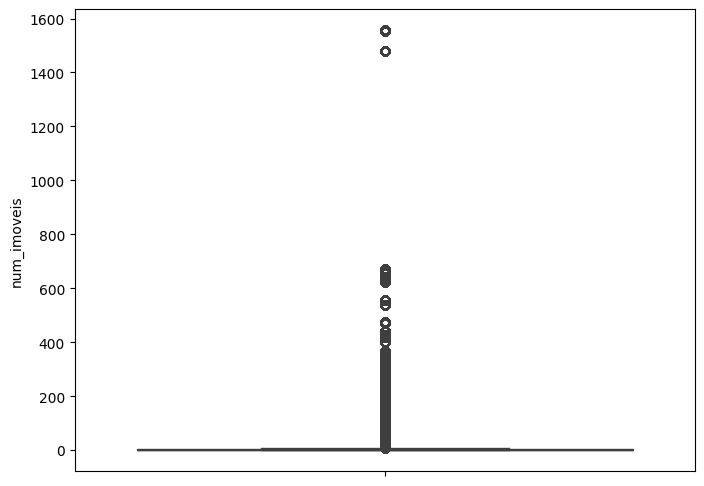

Outliers:


,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,tipo_propriedade,aberto,bairro,num_imoveis,...,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte
470,0012468c364597420246e2b93c1bf25c,02ae88b359eeffea875350beaddc7871,1575de65fb21da62,2022.0,42.0,0.00,TERRENO,1,DOIS UNIDOS,44.0,...,0.00,111601.39,2.0,1.0,1.0,0.0,1.0,0.818182,0.0,1.0
471,0012468c364597420246e2b93c1bf25c,07c521e52c58109890ecf5aaf6be6eb7,14814b153d9e8c73,2023.0,42.0,0.00,TERRENO,1,DOIS UNIDOS,44.0,...,0.00,212327.07,1.0,2.0,0.0,0.0,1.0,0.818182,0.0,1.0
472,0012468c364597420246e2b93c1bf25c,0863160c5551f63d90ecf5aaf6be6eb7,061edf5275eda635,2023.0,42.0,0.00,TERRENO,1,DOIS UNIDOS,44.0,...,0.00,212327.07,1.0,2.0,0.0,0.0,1.0,0.818182,0.0,1.0
473,0012468c364597420246e2b93c1bf25c,0a9df4ff10ccdcef875350beaddc7871,2033a08e3acfca9f,2022.0,42.0,0.00,TERRENO,1,DOIS UNIDOS,44.0,...,0.00,111601.39,2.0,1.0,1.0,0.0,1.0,0.818182,0.0,1.0
474,0012468c364597420246e2b93c1bf25c,0c48d2f3896c220f875350beaddc7871,ea5b8028d92162db,2022.0,42.0,0.00,TERRENO,1,DOIS UNIDOS,44.0,...,0.00,111601.39,2.0,1.0,1.0,0.0,1.0,0.818182,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923868,ffe2b729d58e3cf31603ecd7ff6be21f,d85043974e18dd1f875350beaddc7871,e76306b7bf58d1d5,2022.0,47.0,102.50,APARTAMENTO,0,BOA VIAGEM,18.0,...,37538.14,38529.94,2.0,9.0,1.0,0.1,1.0,0.818182,1.0,1.0
1923869,ffe2b729d58e3cf31603ecd7ff6be21f,df09fab2e86ab22790ecf5aaf6be6eb7,9a0f325734f358ea,2023.0,52.0,81.00,APARTAMENTO,0,SANTO AMARO,18.0,...,56522.59,58830.77,1.0,10.0,0.0,0.2,1.0,0.818182,1.0,1.0
1923872,ffe2b729d58e3cf31603ecd7ff6be21f,eb4591d0f8598954875350beaddc7871,755dafe96cc7869b,2022.0,52.0,81.00,APARTAMENTO,0,SANTO AMARO,18.0,...,37538.14,38529.94,2.0,9.0,1.0,0.1,1.0,0.818182,1.0,1.0
1923873,ffe2b729d58e3cf31603ecd7ff6be21f,ef608fc8e60735d6875350beaddc7871,ab455834b4d86772,2022.0,64.0,101.73,CASA,0,CAMPO GRANDE,18.0,...,37538.14,38529.94,2.0,9.0,1.0,0.1,1.0,0.818182,1.0,1.0


In [695]:
plt.figure(figsize=(8, 6))
sns.boxplot(y='num_imoveis', data=feature_store_credito)
plt.show()

# IQR
Q1 = feature_store_credito['num_imoveis'].quantile(0.25)
Q3 = feature_store_credito['num_imoveis'].quantile(0.75)
IQR = Q3 - Q1

# limites para identificar outliers
limite_inferior = Q1 - 3.0 * IQR
limite_superior = Q3 + 3.0 * IQR

# outliers
outliers = feature_store_credito[(feature_store_credito['num_imoveis'] < limite_inferior) | (feature_store_credito['num_imoveis'] > limite_superior)]

print("Outliers:")
outliers

In [45]:
feature_store_credito_sem_outliers = feature_store_credito.copy()

In [46]:
# TRATAMENTO DE OUTLIERS
from scipy.stats.mstats import winsorize
feature_store_credito_sem_outliers['idade_imovel'] = winsorize(feature_store_credito_sem_outliers['idade_imovel'], limits=[0.00, 0.05])
feature_store_credito_sem_outliers['area_construida'] = winsorize(feature_store_credito_sem_outliers['area_construida'], limits=[0.00, 0.05])
feature_store_credito_sem_outliers['num_imoveis'] = winsorize(feature_store_credito_sem_outliers['num_imoveis'], limits=[0.05, 0.05])

### Parece não ter uma correlação Linear - Dados sem tratamento de outliers

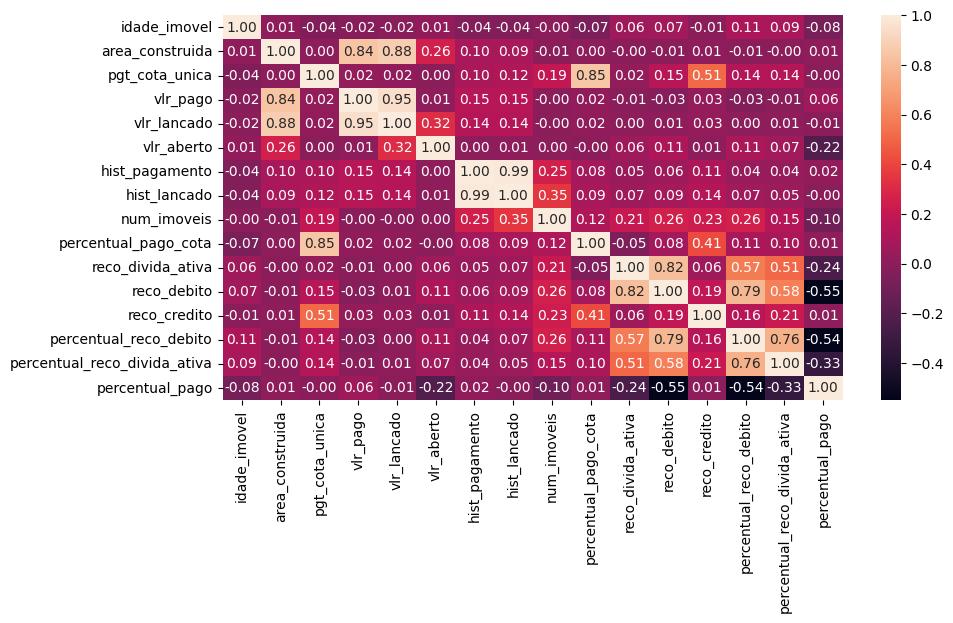

In [47]:
matriz_correlacao = feature_store_credito[['idade_imovel', 'area_construida',  'pgt_cota_unica',
                                    'vlr_pago', 'vlr_lancado', 'vlr_aberto', 'hist_pagamento', 
                                    'hist_lancado', 'num_imoveis', 'percentual_pago_cota',
                                    'reco_divida_ativa','reco_debito','reco_credito','percentual_reco_debito',
                                    'percentual_reco_divida_ativa', 'percentual_pago']].corr()
plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
plt.show()

### Parece não ter uma correlação Linear - Dados com tratamento de outliers

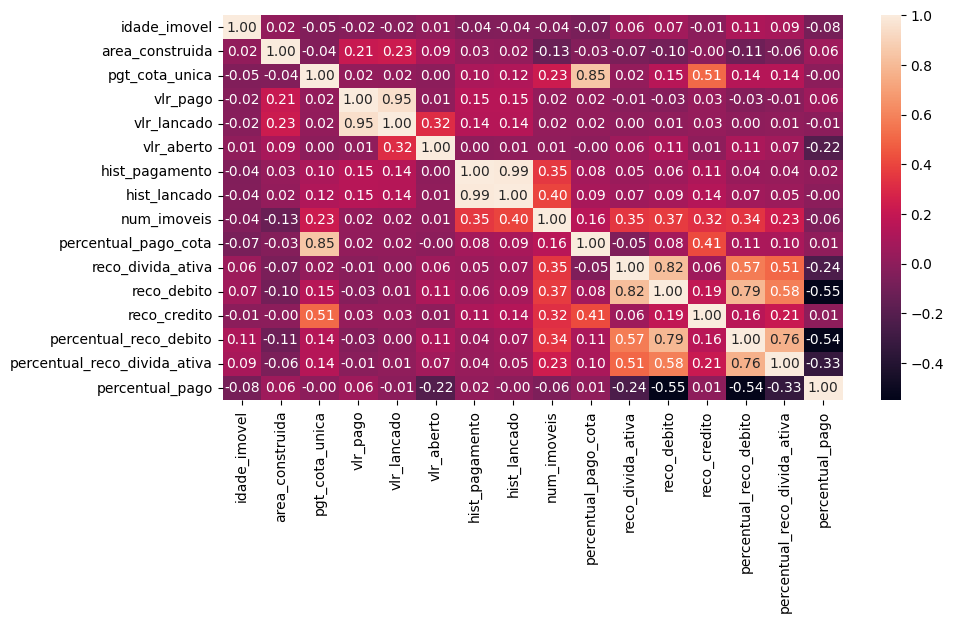

In [606]:
matriz_correlacao = feature_store_credito_sem_outliers[['idade_imovel', 'area_construida',  'pgt_cota_unica',
                                    'vlr_pago', 'vlr_lancado', 'vlr_aberto', 'hist_pagamento', 
                                    'hist_lancado', 'num_imoveis', 'percentual_pago_cota',
                                    'reco_divida_ativa','reco_debito','reco_credito','percentual_reco_debito',
                                    'percentual_reco_divida_ativa', 'percentual_pago']].corr()
plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
plt.show()

In [48]:
from scipy.stats import spearmanr

matriz_correlacao_rank = feature_store_credito[['idade_imovel', 'area_construida',  'pgt_cota_unica',
                                    'vlr_pago', 'vlr_lancado', 'vlr_aberto', 'hist_pagamento', 
                                    'hist_lancado', 'num_imoveis', 'percentual_pago_cota',
                                    'reco_divida_ativa','reco_debito','reco_credito','percentual_reco_debito',
                                    'percentual_reco_divida_ativa', 'percentual_pago']].corr(method='spearman')



In [49]:
matriz_correlacao_rank

,idade_imovel,area_construida,pgt_cota_unica,vlr_pago,vlr_lancado,vlr_aberto,hist_pagamento,hist_lancado,num_imoveis,percentual_pago_cota,reco_divida_ativa,reco_debito,reco_credito,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago
idade_imovel,1.000000,-0.023601,-0.048350,-0.247712,-0.240319,0.072844,-0.180021,-0.168815,-0.080502,-0.055979,0.054098,0.073963,-0.009929,0.104648,0.099198,-0.079469
area_construida,-0.023601,1.000000,-0.051767,0.681390,0.809275,-0.033644,0.232288,0.242701,-0.142347,-0.049836,-0.100421,-0.131304,-0.013038,-0.136417,-0.105314,0.064436
pgt_cota_unica,-0.048350,-0.051767,1.000000,0.042282,0.037258,-0.005006,0.302807,0.291529,0.239094,0.952005,0.019179,0.114388,0.492376,0.120261,0.127769,0.000820
vlr_pago,-0.247712,0.681390,0.042282,1.000000,0.773887,-0.495322,0.477256,0.400202,0.031896,0.045279,-0.181726,-0.322873,0.110365,-0.308351,-0.217954,0.512318
vlr_lancado,-0.240319,0.809275,0.037258,0.773887,1.000000,0.069519,0.433769,0.472734,0.024919,0.043345,-0.048050,-0.037917,0.110555,-0.049667,-0.030046,-0.033695
vlr_aberto,0.072844,-0.033644,-0.005006,-0.495322,0.069519,1.000000,-0.162006,-0.005496,-0.008983,0.002351,0.221738,0.529276,0.003130,0.479081,0.334021,-0.994618
hist_pagamento,-0.180021,0.232288,0.302807,0.477256,0.433769,-0.162006,1.000000,0.961376,0.740752,0.293191,0.151312,0.127608,0.573247,0.112310,0.117853,0.174076
hist_lancado,-0.168815,0.242701,0.291529,0.400202,0.472734,-0.005496,0.961376,1.000000,0.762521,0.281193,0.201541,0.230424,0.565937,0.224804,0.208573,0.019897
num_imoveis,-0.080502,-0.142347,0.239094,0.031896,0.024919,-0.008983,0.740752,0.762521,1.000000,0.218932,0.315276,0.326109,0.341458,0.310302,0.274605,0.005982
percentual_pago_cota,-0.055979,-0.049836,0.952005,0.045279,0.043345,0.002351,0.293191,0.281193,0.218932,1.000000,-0.015125,0.103577,0.503117,0.114676,0.117827,-0.005827


---

# INICIANDO CONSTRUÇÃO DO MODELO

In [47]:
feature_store_credito.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago'],
      dtype='object')

## INCLUINDO A NATUREZA JURÍDICA OU FÍSICA DO CONTRIBUINTE

In [48]:
arq_natureza = r'C:\Users\Acer\Projetos\Recife\dados\querys_modelos\RELACAO_IMOVEL_TIPO_CONTRIBUINTE.xlsx'
tbl_pf_pj = pd.read_excel(arq_natureza)
tbl_pf_pj 

,id_imovel,tipo_contribuinte
0,6b3a8e268c80aedf,PF
1,200d024ed1d1cc90,PJ
2,730b78533133f903,PJ
3,408002743410a58c,PJ
4,b7e964d611a3baa8,PF
...,...,...
517851,42e13a28e98c6be0,PF
517852,4b1a9413a179e1ea,PF
517853,6e3c9674c93ba1eb,PF
517854,b9e1dd322b5fbe3e,PF


In [49]:
tbl_pf_pj['tipo_contribuinte'] = tbl_pf_pj['tipo_contribuinte'].replace({'PF': 1, 'PJ': 0})
tbl_pf_pj

,id_imovel,tipo_contribuinte
0,6b3a8e268c80aedf,1
1,200d024ed1d1cc90,0
2,730b78533133f903,0
3,408002743410a58c,0
4,b7e964d611a3baa8,1
...,...,...
517851,42e13a28e98c6be0,1
517852,4b1a9413a179e1ea,1
517853,6e3c9674c93ba1eb,1
517854,b9e1dd322b5fbe3e,1


In [50]:
feature_store_credito = pd.merge(feature_store_credito, tbl_pf_pj, on='id_imovel', how='left')
feature_store_credito

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,55.0,110.15,1,CASA,AREIAS,1,...,721.31,3339.77,1.0,3.0,0.0,0.0,1.0,0.6,0.0,1.0
1,0000398c485f8b42344d77602867ec09,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,2017.0,55.0,110.15,1,CASA,AREIAS,0,...,721.31,721.31,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0000398c485f8b42344d77602867ec09,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,2022.0,55.0,110.15,1,CASA,AREIAS,1,...,721.31,2100.81,2.0,2.0,1.0,0.0,1.0,0.6,0.0,1.0
3,00003a695da4777aec557718ffae83ea,0ef80ae81185fad10ba9f03948490762,6b7e2fa2f4f1a593,2020.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,7281.31,7281.31,0.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0
4,00003a695da4777aec557718ffae83ea,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,2022.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,10712.41,10712.41,0.0,7.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924713,ffffe7d2325d80e6d8b209292c0ce31d,7ace6937886e01b219002eec9f619408,233f75a5f20edef9,2021.0,15.0,93.60,1,CASA,COHAB,0,...,5944.02,5944.02,0.0,7.0,0.0,0.0,0.0,0.0,1.0,1.0
1924714,ffffe7d2325d80e6d8b209292c0ce31d,807e85a93b8584ca11babe4a46e18b6d,233f75a5f20edef9,2018.0,15.0,93.60,1,CASA,COHAB,0,...,4082.82,4082.82,0.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0
1924715,ffffe7d2325d80e6d8b209292c0ce31d,a5dbee1cfd0fe49c0ba9f03948490762,233f75a5f20edef9,2020.0,15.0,93.60,1,CASA,COHAB,0,...,5310.62,5310.62,0.0,6.0,0.0,0.0,0.0,0.0,1.0,1.0
1924716,ffffe7d2325d80e6d8b209292c0ce31d,d3d0e5512a43a626e08920064611a7cf,233f75a5f20edef9,2017.0,15.0,93.60,1,CASA,COHAB,0,...,3512.62,3512.62,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0


## Filtrando dados até 2022 para treino e teste

In [162]:
feature_store_credito_ate_22 = feature_store_credito.query('ano < 2023')
feature_store_credito_22 = feature_store_credito.query('ano == 2022')
feature_store_credito_23 = feature_store_credito.query('ano == 2023')
feature_store_credito_22_23 = feature_store_credito.query('ano > 2021')

In [57]:
ate_22 = feature_store_credito_ate_22.shape[0]
ano_22 = feature_store_credito_22.shape[0]
ano_23 = feature_store_credito_23.shape[0]
ano_22_23 = feature_store_credito_22_23.shape[0]
print(f'O número de registros em feature_store_credito_ate_22 é: {ate_22}')
print(f'O número de registros em feature_store_credito_ate_22 é: {ano_22}')
print(f'O número de registros em feature_store_credito_ate_22 é: {ano_23}')
print(f'O número de registros em feature_store_credito_ate_22 é: {ano_22_23}')

O número de registros em feature_store_credito_ate_22 é: 1579937
O número de registros em feature_store_credito_ate_22 é: 340659
O número de registros em feature_store_credito_ate_22 é: 344781
O número de registros em feature_store_credito_ate_22 é: 685440


### No ano de 2022 30% dos registros tem comportamento de não pagamento e pagamento parcial
### Enquanto nos demais anos são 10% deste fenômeno

In [281]:
vintedois = feature_store_credito.query('aberto == 1')
vintedois = vintedois.query('ano == 2022')
vintedois

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,tipo_propriedade,aberto,bairro,num_imoveis,...,vlr_pago,vlr_lancado,pgt_cota_unica,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago
2,0000398c485f8b42344d77602867ec09,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,2022.0,55.0,110.15,CASA,1,AREIAS,1.0,...,0.00,1306.50,0.0,0.0,721.31,2100.81,2.0,2.0,1.0,0.000000
102,000473f4656786d9d4613fe022d53698,d6aec6bbe69d9a45875350beaddc7871,cabfecc5d23c6b25,2022.0,10.0,93.79,APARTAMENTO,1,BOA VIAGEM,2.0,...,477.32,1811.56,0.0,0.0,5090.85,29499.46,2.0,8.0,1.0,0.263486
103,000473f4656786d9d4613fe022d53698,e992d2b705f16e6c875350beaddc7871,2e037c9c5af02537,2022.0,20.0,138.48,APARTAMENTO,1,PARNAMIRIM,2.0,...,0.00,3230.01,0.0,0.0,5090.85,29499.46,2.0,8.0,1.0,0.000000
124,000554c5705b8f31be91dcec7d89e48e,222265876522c289875350beaddc7871,5f537f5f4c7b5d64,2022.0,37.0,227.00,CASA,1,SANCHO,2.0,...,0.00,2681.62,0.0,0.0,369.82,3634.09,2.0,3.0,1.0,0.000000
125,000554c5705b8f31be91dcec7d89e48e,3d2d5ea17fa2abb6875350beaddc7871,0fd2704b768f5ec1,2022.0,37.0,50.00,CASA,1,TEJIPIO,2.0,...,0.00,410.09,0.0,0.0,369.82,3634.09,2.0,3.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924575,fffafcbc80a2ab2a1603ecd7ff6be21f,5cca6bf618589050875350beaddc7871,c79c2476626fa4b6,2022.0,33.0,60.00,CASA,1,BREJO DA GUABIRABA,2.0,...,0.00,642.62,0.0,0.0,35845.37,37570.46,2.0,7.0,1.0,0.000000
1924581,fffafcbc80a2ab2a1603ecd7ff6be21f,d153a30f5abc02b6875350beaddc7871,0d10c951c9107853,2022.0,15.0,249.11,APARTAMENTO,1,ROSARINHO,2.0,...,6116.76,7108.06,0.0,0.0,35845.37,37570.46,2.0,7.0,1.0,0.860539
1924605,fffbe473a0368b52cd124eb8021f7dca,74b95be3712ca666875350beaddc7871,688ed9aa67990ce4,2022.0,45.0,234.10,APARTAMENTO,1,BOA VIAGEM,1.0,...,0.00,6013.21,0.0,0.0,5044.71,23545.67,1.0,6.0,1.0,0.000000
1924617,fffd0aa05b3e4fc40246e2b93c1bf25c,db6769fa784b684f875350beaddc7871,15bdd971a7d7d41f,2022.0,15.0,534.63,EDIFICAÇÃO ESPECIAL,1,PINA,1.0,...,0.00,60232.62,0.0,0.0,0.00,166514.41,1.0,3.0,0.0,0.000000


### No ano de 2022 70% dos registros tem comportamento de pagamento
### Enquanto nos demais anos são 90% deste fenômeno

In [282]:
vintedois = feature_store_credito.query('aberto == 0')
vintedois = vintedois.query('ano == 2022')
vintedois

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,tipo_propriedade,aberto,bairro,num_imoveis,...,vlr_pago,vlr_lancado,pgt_cota_unica,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago
4,00003a695da4777aec557718ffae83ea,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,2022.0,30.0,132.71,APARTAMENTO,0,AFLITOS,1.0,...,1798.10,1798.10,0.0,0.0,10712.41,10712.41,0.0,7.0,0.0,1.0
11,000046c85d18a6f7968646cfc1e328f2,43f61322c00d0a2a875350beaddc7871,4c440987414316f6,2022.0,15.0,151.45,APARTAMENTO,0,BOA VIAGEM,1.0,...,3776.00,3776.00,1.0,1.0,22260.10,22260.10,0.0,7.0,0.0,1.0
20,0000b23be5378f1b8e79cf1867e8cc19,2489dc70da197fd8875350beaddc7871,f4a09ae3e8291db3,2022.0,53.0,28.00,SALA,0,BOA VISTA,4.0,...,275.25,275.25,1.0,1.0,14540.72,14540.72,0.0,7.0,0.0,1.0
36,0000b23be5378f1b8e79cf1867e8cc19,d4377c5f6f787b9c875350beaddc7871,e8f779a348c050b1,2022.0,53.0,32.00,SALA,0,BOA VISTA,4.0,...,332.82,332.82,1.0,1.0,14540.72,14540.72,0.0,7.0,0.0,1.0
37,0000b23be5378f1b8e79cf1867e8cc19,da0416f883deaf4a875350beaddc7871,f42760d51259d181,2022.0,30.0,53.00,SALA,0,BOA VISTA,4.0,...,1006.30,1006.30,1.0,1.0,14540.72,14540.72,0.0,7.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924685,ffff3836dbf935321bc34267b5521a39,4d78d7f5d9b59641875350beaddc7871,0cfe1aa6943523cf,2022.0,12.0,209.97,APARTAMENTO,0,BOA VIAGEM,1.0,...,6027.44,6027.44,0.0,0.0,31160.58,31160.58,0.0,7.0,0.0,1.0
1924693,ffff63826b501d84d8b209292c0ce31d,678b4dd9ca5a91c2875350beaddc7871,e5ef9115acfa782e,2022.0,40.0,213.00,CASA,0,CORDEIRO,1.0,...,1966.30,1966.30,0.0,0.0,11591.81,11591.81,0.0,7.0,0.0,1.0
1924700,ffffc6563e67d8b38e79cf1867e8cc19,473a7619002d4deb875350beaddc7871,18be5a8c332a3892,2022.0,41.0,86.13,APARTAMENTO,0,IPUTINGA,2.0,...,704.30,704.30,0.0,0.0,12150.76,12150.76,0.0,6.0,0.0,1.0
1924706,ffffc6563e67d8b38e79cf1867e8cc19,d295a8166b764514875350beaddc7871,0fb91ca37fa4509b,2022.0,31.0,159.80,APARTAMENTO,0,CORDEIRO,2.0,...,1683.70,1683.70,0.0,0.0,12150.76,12150.76,0.0,6.0,0.0,1.0


In [395]:
# # Retirando variáveis que não serão usadas no modelo
# df_feature_store = teste_2.drop(columns=['aberto', 'tipo_propriedade', 'bairro', 'ano', 'pgt_cota_unica', 'vlr_aberto'
#                                                        ,'vlr_pago', 'vlr_lancado' ])
# df_feature_store = df_feature_store.set_index(['dam', 'id_imovel', 'id_contribuinte'])

In [283]:
feature_store_credito_aberto = feature_store_credito.query('aberto == 1')
feature_store_credito_pago = feature_store_credito.query('aberto == 0')

---

# Seleção de variáveis

In [52]:
feature_store_credito.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago', 'tipo_contribuinte'],
      dtype='object')

In [58]:
variaveis = ['area_construida', 'reco_debito','reco_credito', 'num_imoveis', 'hist_pagamento', 'hist_lancado',
            'idade_imovel','reco_divida_ativa', 'hist_cota_unica',  'tipo_contribuinte', 'percentual_pago']
variaveis_selecionadas = feature_store_credito_22[variaveis]
variaveis_selecionadas.columns

Index(['area_construida', 'reco_debito', 'reco_credito', 'num_imoveis',
       'hist_pagamento', 'hist_lancado', 'idade_imovel', 'reco_divida_ativa',
       'hist_cota_unica', 'tipo_contribuinte', 'percentual_pago'],
      dtype='object')

# São 479 registros de 77 contribuintes em que não há histórico para os mesmos

In [59]:
variaveis_selecionadas.isnull().sum()

area_construida        0
reco_debito            0
reco_credito           0
num_imoveis            0
hist_pagamento         0
hist_lancado           0
idade_imovel           0
reco_divida_ativa      0
hist_cota_unica        0
tipo_contribuinte    226
percentual_pago        0
dtype: int64

In [60]:
variaveis_selecionadas.query('tipo_contribuinte.isnull()')

,area_construida,reco_debito,reco_credito,num_imoveis,hist_pagamento,hist_lancado,idade_imovel,reco_divida_ativa,hist_cota_unica,tipo_contribuinte,percentual_pago
8660,181.37,1.0,3.0,1.0,4511.21,4511.21,54.0,1.0,0.0,NaN,1.0
15894,144.00,1.0,10.0,5.0,51168.98,51925.57,25.0,0.0,1.0,NaN,1.0
19425,49.03,2.0,4.0,1.0,832.98,1290.85,24.0,1.0,0.0,NaN,0.0
21595,43.42,0.0,8.0,1.0,3886.39,3886.39,27.0,0.0,0.0,NaN,1.0
22129,119.98,2.0,2.0,1.0,439.32,2552.30,36.0,1.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1850759,76.58,0.0,7.0,1.0,4143.00,4143.00,22.0,0.0,0.0,NaN,1.0
1859674,55.25,0.0,7.0,1.0,2653.74,2653.74,14.0,0.0,1.0,NaN,1.0
1902610,0.00,2.0,1.0,1.0,0.00,979.69,40.0,1.0,0.0,NaN,0.0
1904339,247.15,2.0,2.0,1.0,1074.55,7725.94,37.0,1.0,0.0,NaN,0.0


In [61]:
variaveis_selecionadas = variaveis_selecionadas.dropna(subset=['tipo_contribuinte'])

In [62]:
variaveis_selecionadas.isnull().sum()

area_construida      0
reco_debito          0
reco_credito         0
num_imoveis          0
hist_pagamento       0
hist_lancado         0
idade_imovel         0
reco_divida_ativa    0
hist_cota_unica      0
tipo_contribuinte    0
percentual_pago      0
dtype: int64

# PIPELINE

In [63]:
seed = 1337 # Semente fixando a aleatoridade dos experimentos

In [64]:
variaveis_selecionadas['percentual_pago'].mean()

0.7405909801142553

In [65]:
variaveis_selecionadas.columns

Index(['area_construida', 'reco_debito', 'reco_credito', 'num_imoveis',
       'hist_pagamento', 'hist_lancado', 'idade_imovel', 'reco_divida_ativa',
       'hist_cota_unica', 'tipo_contribuinte', 'percentual_pago'],
      dtype='object')

In [66]:
y = variaveis_selecionadas['percentual_pago']
x = variaveis_selecionadas.drop(columns=['percentual_pago'])

In [67]:
x.columns

Index(['area_construida', 'reco_debito', 'reco_credito', 'num_imoveis',
       'hist_pagamento', 'hist_lancado', 'idade_imovel', 'reco_divida_ativa',
       'hist_cota_unica', 'tipo_contribuinte'],
      dtype='object')

In [69]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.4)

---

In [448]:
testes = XGBRegressor(learning_rate =0.02,   # taxa de aprendizado, controla a contribuição de cada árvore para o modelo
                      n_estimators = 3000,   # número total de árvores 
                      colsample_bynode=1,    # Um valor de 1 significa que, ao dividir cada nó da árvore, 100% das features são consideradas
                      subsample=0.9,         # 90% das instâncias estão sendo amostradas aleatoriamente
                      random_state = 0)

In [449]:
testes.fit(X_train, y_train)
p = testes.predict(X_test)
np.sqrt(mean_squared_error(y_test, p))

19.95292918948601

21.491193099075783 - learning 0.02 - n_estimators = 2000 - colsample_bynode=1 - subsample=0.9
21.491254157802857 - learning 0.05 - n_estimators = 1000 - colsample_bynode=1 - subsample=0.9
21.493280006310975 - learning 0.05 - n_estimators = 1000 - colsample_bynode=1 - subsample=0.3
21.493280006310975 - learning 0.05 - n_estimators = 1000 - colsample_bynode=1
21.494544350017986 - learning 0.05 - n_estimators = 1000
21.494544350017986 - learning 0.08 - n_estimators = 1000
21.498097428486908 - learning 0.09 - n_estimators = 1000
21.498098629289444 - learning 0.05 - n_estimators = 2000 - colsample_bynode=1 - subsample=0.9
21.501489488001287 - learning 0.05 - n_estimators = 1000 - colsample_bynode=1 - subsample=0.3
21.501523649936665 - learning 0.02 - n_estimators = 1000
21.61012653777787 - learning 0.9 - n_estimators = 1000

Nesse caso, o RMSE de xx.xx% indica que, em média, as previsões do modelo têm um erro absoluto médio de xx.xx% em relação aos valores reais

---

In [70]:
X_train.shape[0]
1112477

1112477

In [47]:
def ccc_score(y_true, y_pred):
    rho = np.corrcoef(y_true, y_pred)[0, 1] # calcula o coeficiente de pearson entre valores reais e os valores preditos/ 0 e 1 acessa a matriz
    std_true = np.std(y_true)               # calcula o desvio padrao dos valores reais
    std_pred = np.std(y_pred)               # calcula o desvio padrão das previsões do modelo 
    mean_true = np.mean(y_true)             # calcula a média dos valores reais
    mean_pred = np.mean(y_pred)             # calcula a média das previsões do modelo
    
    # fórmula do índice de concordância de Lin
    # O índice de concordância de Lin avalia a concordância entre as previsões do modelo (y_pred) e os valores reais (y_true)
    ccc = (2 * rho * std_true * std_pred) / (std_true**2 + std_pred**2 + (mean_true - mean_pred)**2)
    
    return ccc

In [48]:
def roda_pipeline(algoritmo_normalizador, algoritmo_regressao, X_train, y_train, X_test, y_test):

    pipeline = Pipeline([('scaler', algoritmo_normalizador), ('regressor', algoritmo_regressao)])
    pipeline.fit(X_train, y_train)

    previsoes = pipeline.predict(X_test)

    r2 = r2_score(y_test, previsoes)
    mse = np.sqrt(mean_squared_error(y_test, previsoes))
    ccc = ccc_score(y_test, previsoes)
    
    print("\nModelo treinado:", str(algoritmo_regressao))
    print("R2 ->", r2)
    print("RMSE ->", mse)
    print("CCC ->", ccc)

In [49]:
params = {
    'objective': 'reg:squaredlogerror',
    'max_depth': 10,
    'learning_rate': 0.02,
    'min_child_weight': 3,
    'n_estimators': 2000,
    'colsample_bynode': 1,
    'subsample': 0.9
}

biblioteca_modelos_xgboost = {
    'dummy': DummyRegressor(),
    'xgboost': XGBRegressor(**params, random_state=1337)
}

pipeline_modelo_xgboost = ['dummy', 'xgboost']

In [50]:
biblioteca_modelos_random_forest = {
    'dummy': DummyRegressor(),
    'random_forest': RandomForestRegressor(random_state=1337)
}
pipeline_modelo_random_forest = ['dummy','random_forest']

# TESTE DE MODELOS

# RANDOM FOREST

In [774]:
for modelos in pipeline_modelo_random_forest:
    roda_pipeline(
        algoritmo_normalizador= StandardScaler(),
        algoritmo_regressao= biblioteca_modelos_random_forest.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -3.785641821751895e-05
RMSE -> 0.4284536177278225
CCC -> 2.3608124919440467e-31



Modelo treinado: RandomForestRegressor(random_state=1337)
R2 -> 0.7414911499676291
RMSE -> 0.2178378298585831
CCC -> 0.8555717952791879


In [ ]:
for modelos in pipeline_modelo_random_forest:
    roda_pipeline(
        algoritmo_normalizador= RobustScaler(),
        algoritmo_regressao= biblioteca_modelos_random_forest.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )

In [ ]:
for modelos in pipeline_modelo_random_forest:
    roda_pipeline(
        algoritmo_normalizador= MinMaxScaler(),
        algoritmo_regressao= biblioteca_modelos_random_forest.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )

# XGBOOST

In [328]:
for modelos in pipeline_modelo_xgboost:
    roda_pipeline(
        algoritmo_normalizador= StandardScaler(),
        algoritmo_regressao= biblioteca_modelos_xgboost.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -3.785641821751895e-05
RMSE -> 0.4284536177278225
CCC -> 2.3608124919440467e-31



Modelo treinado: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=1, colsample_bytree=None,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, num_parallel_tree=None,
             objective='reg:squaredlogerror', ...)
R2 -> 0.754089336144941
RMSE -> 0.21246347238972707
CCC -> 0.8644652734784316


In [158]:
for modelos in pipeline_modelo_xgboost:
    roda_pipeline(
        algoritmo_normalizador= RobustScaler(),
        algoritmo_regressao= biblioteca_modelos_xgboost.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -5.236161690458374e-06
RMSE -> 0.42704183710650145
CCC -> -2.9625166545015275e-31



Modelo treinado: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=1, colsample_bytree=None,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, num_parallel_tree=None,
             objective='reg:squaredlogerror', ...)
R2 -> 0.751454396231102
RMSE -> 0.21289836718520186
CCC -> 0.863755357298806


In [ ]:
for modelos in pipeline_modelo_xgboost:
    roda_pipeline(
        algoritmo_normalizador= MinMaxScaler(),
        algoritmo_regressao= biblioteca_modelos_xgboost.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )

# Validação cruzada

In [309]:
variaveis_selecionadas['percentual_pago'].std()

0.42738745039162895

### O desvio padrão de 0.42 indica a dispersão dos valores reais da variável percentual_pago ao redor da média. Quanto maior o desvio padrão, mais dispersos estão os valores

In [324]:
from sklearn.model_selection import cross_val_score, KFold

params = {
    'objective': 'reg:squaredlogerror',
    'max_depth': 10,
    'learning_rate': 0.02,
    'min_child_weight': 3,
    'n_estimators': 2000,
    'colsample_bynode': 1,
    'subsample': 0.9
}

model = XGBRegressor(**params)

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=0)

# validação
cv_results = cross_val_score(model, x, y, cv=kf, scoring='neg_mean_squared_error')

# RMSE (Root Mean Squared Error)
rmse_scores = np.sqrt(-cv_results)

print(f'RMSE Scores: {rmse_scores}')
print(f'Mean RMSE: {np.mean(rmse_scores)}')

RMSE Scores: [0.2106054  0.21084817 0.21073289 0.20950662 0.21080954]
Mean RMSE: 0.21050052242293565


In [ ]:
0.21118555571388736
0.21075807289574996

### Se o RMSE for significativamente menor que o desvio padrão, isso sugere que o modelo está explicando bem a variabilidade nos dados e está fazendo boas previsões.

* Desvio Padrão = 0.42738745039162895 - 42,73%
* RMSE = 0.21179379216811506 - 21,17%

### um RMSE de 0.22 em relação a um desvio padrão de 0.42 sugere que o modelo está performando relativamente bem

# MODELO IPTU VALIDADO EM AÇÃO

In [51]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

feature_store_credito['bairro_encoded'] = le.fit_transform(feature_store_credito['bairro'])

print("Bairros originais:", feature_store_credito['bairro'].unique())
print("Bairros codificados:", feature_store_credito['bairro_encoded'].unique())

Bairros originais: ['AREIAS ' 'AFLITOS ' 'BOA VIAGEM ' 'BOA VISTA ' 'CORDEIRO '
 'ALTO DO MANDU ' 'SAN MARTIN ' 'CASA AMARELA ' 'PARNAMIRIM ' 'GRACAS '
 'PINA ' 'JARDIM SAO PAULO ' 'SANCHO ' 'TEJIPIO ' 'ENGENHO DO MEIO '
 'ESPINHEIRO ' 'TORROES ' 'ENCRUZILHADA ' 'AGUA FRIA ' 'HIPODROMO '
 'MUSTARDINHA ' 'BEBERIBE ' 'PRADO ' 'CAXANGA ' 'IMBIRIBEIRA ' 'TORRE '
 'FUNDAO ' 'IPSEP ' 'TAMARINEIRA ' 'JORDAO ' 'CAMPO GRANDE '
 'DOIS UNIDOS ' 'MONTEIRO ' 'CACOTE ' 'MACAXEIRA ' 'VARZEA ' 'MADALENA '
 'POCO ' 'IPUTINGA ' 'IBURA ' 'SOLEDADE ' 'SANTO AMARO ' 'CASA FORTE '
 'LINHA DO TIRO ' 'COQUEIRAL ' 'CAMPINA DO BARRETO ' 'ROSARINHO '
 'AFOGADOS ' 'SANTO ANTONIO ' 'BARRO ' 'SANTANA ' 'ARRUDA ' 'JIQUIA '
 'MANGUEIRA ' 'ILHA DO LEITE ' 'CURADO ' 'GUABIRABA ' 'CAJUEIRO '
 'PONTO DE PARADA ' 'BREJO DA GUABIRABA ' 'VASCO DA GAMA ' 'SAO JOSE '
 'PORTO DA MADEIRA ' 'DERBY ' 'APIPUCOS ' 'JAQUEIRA ' 'COHAB ' 'BONGI '
 'BRASILIA TEIMOSA ' 'ILHA DO RETIRO ' 'TOTO ' 'CABANGA '
 'CORREGO DO JENIPAPO ' 'BREJO 

In [52]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

feature_store_credito['tipo_propriedade_encoded'] = le.fit_transform(feature_store_credito['tipo_propriedade'])

print("tipo_propriedade originais:", feature_store_credito['tipo_propriedade'].unique())
print("tipo_propriedade codificados:", feature_store_credito['tipo_propriedade_encoded'].unique())

tipo_propriedade originais: ['CASA' 'APARTAMENTO' 'SALA' 'LOJA' 'TERRENO' 'GARAGEM COMERCIAL'
 'EDIFICAÇÃO ESPECIAL' 'GALPÃO' 'MOCAMBO' 'INDUSTRIA'
 'INSTITUIÇÃO EDUCACIONAL' 'INSTITUIÇÃO FINANCEIRA'
 'CENTRO COMERCIAL/SERVIÇOS' 'HOTEL' 'GALPÃO FECHADO' 'HOSPITAL'
 'TEMPLO RELIGIOSO' 'POSTO DE ABASTECIMENTO' 'LOJA MÚLTIPLA'
 'GARAGEM RESIDENCIAL']
tipo_propriedade codificados: [ 1  0 17 13 19  6  3  4 15 10 11 12  2  9  5  8 18 16 14  7]


In [53]:
feature_store_credito_ate_21 = feature_store_credito.query('ano < 2021')
feature_store_credito_ate_22 = feature_store_credito.query('ano < 2023')
feature_store_credito_22 = feature_store_credito.query('ano == 2022')
feature_store_credito_23 = feature_store_credito.query('ano == 2023')
feature_store_credito_22_23 = feature_store_credito.query('ano > 2021')

In [175]:
feature_store_credito_22['perc_hist_pago'] = (feature_store_credito_22['hist_pagamento'] / feature_store_credito_22['hist_lancado']).fillna(0)

C:\Users\Acer\AppData\Local\Temp\ipykernel_13908\3140052272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_store_credito_22['perc_hist_pago'] = (feature_store_credito_22['hist_pagamento'] / feature_store_credito_22['hist_lancado']).fillna(0)


In [176]:
feature_store_credito_23['perc_hist_pago'] = (feature_store_credito_23['hist_pagamento'] / feature_store_credito_23['hist_lancado']).fillna(0)

C:\Users\Acer\AppData\Local\Temp\ipykernel_13908\1996227437.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_store_credito_23['perc_hist_pago'] = (feature_store_credito_23['hist_pagamento'] / feature_store_credito_23['hist_lancado']).fillna(0)


In [56]:
feature_store_credito_22.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,bairro_encoded,tipo_propriedade_encoded,perc_hist_pago
346496,2d6ae6e5dd1e57efae08d57f53945088,93330731628f4fea875350beaddc7871,b99a4cd3eca45812,2022.0,17.0,100.86,1,APARTAMENTO,BOA VIAGEM,0,...,6.0,0.0,0.714286,0.428571,1.0,1.0,1.0,12,0,0.859312


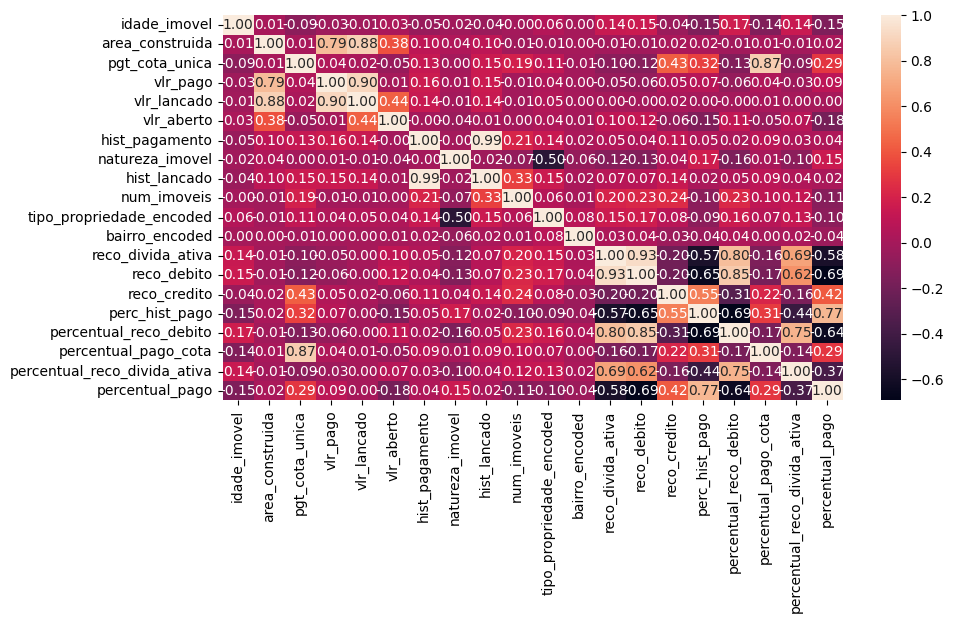

In [57]:
matriz_correlacao = feature_store_credito_22[['idade_imovel', 'area_construida',  'pgt_cota_unica',
                                    'vlr_pago', 'vlr_lancado', 'vlr_aberto', 'hist_pagamento', 'natureza_imovel',
                                    'hist_lancado', 'num_imoveis', 'tipo_propriedade_encoded', 'bairro_encoded',
                                    'reco_divida_ativa','reco_debito','reco_credito',
                                    'perc_hist_pago','percentual_reco_debito','percentual_pago_cota',
                                    'percentual_reco_divida_ativa', 'percentual_pago']].corr()
plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
plt.show()

In [143]:
# Agrupando para exluir o fato de uma mesma dam ter mais de um registro
teste = feature_store_credito_22.groupby(['id_contribuinte']).agg({
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum',
    'vlr_lancado': 'sum',
    'vlr_aberto': 'sum',
    'pgt_cota_unica': 'first',
    'hist_cota_unica': 'first',
    'hist_pagamento': 'first',
    'hist_lancado': 'first',
    'reco_debito': 'first',
    'reco_credito': 'first',
    'perc_hist_pago': 'first',
    'reco_divida_ativa': 'first',
    'percentual_pago_cota': 'first',
    'percentual_reco_debito': 'first',
    'percentual_reco_divida_ativa': 'first',
    'percentual_pago': 'first'
}).reset_index()
teste

,id_contribuinte,vlr_aberto,vlr_pago,vlr_lancado,pgt_cota_unica,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito,perc_hist_pago,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago
0,0000398c485f8b42344d77602867ec09,1306.5,0.00,1306.50,0.0,0.0,721.31,2100.81,2.0,2.0,0.343349,1.0,0.000000,1.000000,0.6,0.0
1,00003a695da4777aec557718ffae83ea,0.0,1798.10,1798.10,0.0,0.0,10712.41,10712.41,0.0,7.0,1.000000,0.0,0.000000,0.000000,0.0,1.0
2,000046c85d18a6f7968646cfc1e328f2,0.0,3776.00,3776.00,1.0,1.0,22260.10,22260.10,0.0,7.0,1.000000,0.0,0.125000,0.000000,0.0,1.0
3,0000b23be5378f1b8e79cf1867e8cc19,0.0,2334.37,2334.37,1.0,1.0,14540.72,14540.72,0.0,7.0,1.000000,0.0,0.125000,0.000000,0.0,1.0
4,00014b72ca2a255bd4613fe022d53698,0.0,2251.49,2251.49,1.0,1.0,13096.86,13096.86,0.0,8.0,1.000000,0.0,0.111111,0.000000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216183,ffff0e3e56845cdf1603ecd7ff6be21f,0.0,606.70,606.70,0.0,0.0,2557.49,3144.36,0.0,6.0,0.813358,0.0,0.000000,0.142857,1.0,1.0
216184,ffff3836dbf935321bc34267b5521a39,0.0,6027.44,6027.44,0.0,0.0,31160.58,31160.58,0.0,7.0,1.000000,0.0,0.000000,0.000000,0.0,1.0
216185,ffff63826b501d84d8b209292c0ce31d,0.0,1966.30,1966.30,0.0,0.0,11591.81,11591.81,0.0,7.0,1.000000,0.0,0.000000,0.000000,0.0,1.0
216186,ffffc6563e67d8b38e79cf1867e8cc19,0.0,2388.00,2388.00,0.0,0.0,12150.76,12150.76,0.0,6.0,1.000000,0.0,0.000000,0.000000,0.0,1.0


In [145]:
nao_pagantes = teste.query('vlr_pago != vlr_lancado')
pagantes = teste.query('vlr_pago == vlr_lancado')

In [146]:
nao_pagantes['percentual_pago'].mean()

0.17487323633997576

In [147]:
pagantes['percentual_pago'].mean()

1.0

In [142]:
148171 / (148171 + 68017) * 100

68.53803171313857

In [83]:
feature_store_credito.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'tipo_propriedade', 'aberto', 'bairro',
       'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago', 'tipo_contribuinte'],
      dtype='object')

In [58]:
feature_store_credito_22 = feature_store_credito_22.dropna(subset=['tipo_contribuinte'])
feature_store_credito_22.isnull().sum()

id_contribuinte                 0
dam                             0
id_imovel                       0
ano                             0
idade_imovel                    0
area_construida                 0
natureza_imovel                 0
tipo_propriedade                0
bairro                          0
aberto                          0
num_imoveis                     0
vlr_aberto                      0
vlr_pago                        0
vlr_lancado                     0
pgt_cota_unica                  0
hist_cota_unica                 0
hist_pagamento                  0
hist_lancado                    0
reco_debito                     0
reco_credito                    0
reco_divida_ativa               0
percentual_pago_cota            0
percentual_reco_debito          0
percentual_reco_divida_ativa    0
percentual_pago                 0
tipo_contribuinte               0
bairro_encoded                  0
tipo_propriedade_encoded        0
perc_hist_pago                  0
dtype: int64

In [59]:
feature_store_credito_22

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,bairro_encoded,tipo_propriedade_encoded,perc_hist_pago
2,0000398c485f8b42344d77602867ec09,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,2022.0,55.0,110.15,1,CASA,AREIAS,1,...,2.0,1.0,0.000,1.0,0.6,0.0,1.0,8,1,0.343349
4,00003a695da4777aec557718ffae83ea,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,2022.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,7.0,0.0,0.000,0.0,0.0,1.0,1.0,0,0,1.000000
11,000046c85d18a6f7968646cfc1e328f2,43f61322c00d0a2a875350beaddc7871,4c440987414316f6,2022.0,15.0,151.45,1,APARTAMENTO,BOA VIAGEM,0,...,7.0,0.0,0.125,0.0,0.0,1.0,1.0,12,0,1.000000
20,0000b23be5378f1b8e79cf1867e8cc19,2489dc70da197fd8875350beaddc7871,f4a09ae3e8291db3,2022.0,53.0,28.00,1,SALA,BOA VISTA,0,...,7.0,0.0,0.125,0.0,0.0,1.0,1.0,13,17,1.000000
36,0000b23be5378f1b8e79cf1867e8cc19,d4377c5f6f787b9c875350beaddc7871,e8f779a348c050b1,2022.0,53.0,32.00,1,SALA,BOA VISTA,0,...,7.0,0.0,0.125,0.0,0.0,1.0,1.0,13,17,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924685,ffff3836dbf935321bc34267b5521a39,4d78d7f5d9b59641875350beaddc7871,0cfe1aa6943523cf,2022.0,12.0,209.97,1,APARTAMENTO,BOA VIAGEM,0,...,7.0,0.0,0.000,0.0,0.0,1.0,1.0,12,0,1.000000
1924693,ffff63826b501d84d8b209292c0ce31d,678b4dd9ca5a91c2875350beaddc7871,e5ef9115acfa782e,2022.0,40.0,213.00,1,CASA,CORDEIRO,0,...,7.0,0.0,0.000,0.0,0.0,1.0,1.0,31,1,1.000000
1924700,ffffc6563e67d8b38e79cf1867e8cc19,473a7619002d4deb875350beaddc7871,18be5a8c332a3892,2022.0,41.0,86.13,1,APARTAMENTO,IPUTINGA,0,...,6.0,0.0,0.000,0.0,0.0,1.0,1.0,52,0,1.000000
1924706,ffffc6563e67d8b38e79cf1867e8cc19,d295a8166b764514875350beaddc7871,0fb91ca37fa4509b,2022.0,31.0,159.80,1,APARTAMENTO,CORDEIRO,0,...,6.0,0.0,0.000,0.0,0.0,1.0,1.0,31,0,1.000000


In [311]:
pg = feature_store_credito_22.query('percentual_pago == 1.0')
npg = feature_store_credito_22.query('percentual_pago == 0.0')
pgparc = feature_store_credito_22.query('(percentual_pago > 0.0) & (percentual_pago < 1.0)')

In [312]:
pg['id_contribuinte'].count()

243328

In [486]:
0.07875 * 243328

19162.08

In [313]:
npg['id_contribuinte'].count()

77943

In [314]:
pgparc['id_contribuinte'].count()

19162

In [361]:
0.24583 * 77943

19160.72769

# balanceamento dos dados de treino e teste

50% dos meus dados são registros onde tudo foi pago e 50% registros onde não foi pago ou foi pago parcialmente

In [520]:
# estou criando uma Subamostra aleatória dos dados com percentual pago de 1.0
amostra_pagante = feature_store_credito_22[feature_store_credito_22['percentual_pago'] == 1.0].sample(frac=0.03, random_state=42)

# Subamostra aleatória dos dados com percentual pago de 0.0
amostra_nao_pagante = feature_store_credito_22[feature_store_credito_22['percentual_pago'] == 0.0].sample(frac=0.95, random_state=42)

# Combinando com a amostra de pagantes parcialmente
dados_balanceados = pd.concat([amostra_pagante, amostra_nao_pagante, feature_store_credito_22[(feature_store_credito_22['percentual_pago'] > 0.0) & 
                                                                         (feature_store_credito_22['percentual_pago'] < 1.0)]])

# Embaralhe os dados novamente
dados_balanceados = dados_balanceados.sample(frac=1, random_state=42)

historico de pagamento por imovel do contribuinte

In [60]:
variaveis = ['idade_imovel', 'num_imoveis','natureza_imovel','reco_credito', 
             'perc_hist_pago','percentual_reco_debito','percentual_pago_cota',
             'reco_divida_ativa', 'percentual_reco_divida_ativa', 'percentual_pago',
             'tipo_propriedade_encoded', 'bairro_encoded']
variaveis_selecionadas = feature_store_credito_22[variaveis]
variaveis_selecionadas.columns

Index(['idade_imovel', 'num_imoveis', 'natureza_imovel', 'reco_credito',
       'perc_hist_pago', 'percentual_reco_debito', 'percentual_pago_cota',
       'reco_divida_ativa', 'percentual_reco_divida_ativa', 'percentual_pago',
       'tipo_propriedade_encoded', 'bairro_encoded'],
      dtype='object')

In [61]:
variaveis_selecionadas.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340433 entries, 2 to 1924711
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   idade_imovel                  340433 non-null  float64
 1   num_imoveis                   340433 non-null  float64
 2   natureza_imovel               340433 non-null  int64  
 3   reco_credito                  340433 non-null  float64
 4   perc_hist_pago                340433 non-null  float64
 5   percentual_reco_debito        340433 non-null  float64
 6   percentual_pago_cota          340433 non-null  float64
 7   reco_divida_ativa             340433 non-null  float64
 8   percentual_reco_divida_ativa  340433 non-null  float64
 9   percentual_pago               340433 non-null  float64
 10  tipo_propriedade_encoded      340433 non-null  int32  
 11  bairro_encoded                340433 non-null  int32  
dtypes: float64(9), int32(2), int64(1)
memory us

In [62]:
variaveis_selecionadas.isnull().sum()

idade_imovel                    0
num_imoveis                     0
natureza_imovel                 0
reco_credito                    0
perc_hist_pago                  0
percentual_reco_debito          0
percentual_pago_cota            0
reco_divida_ativa               0
percentual_reco_divida_ativa    0
percentual_pago                 0
tipo_propriedade_encoded        0
bairro_encoded                  0
dtype: int64

In [63]:
variaveis_selecionadas['percentual_pago'].describe()

count    340433.000000
mean          0.740591
std           0.427399
min           0.000000
25%           0.316071
50%           1.000000
75%           1.000000
max           1.000000
Name: percentual_pago, dtype: float64

In [64]:
y = variaveis_selecionadas['percentual_pago']
x = variaveis_selecionadas.drop(columns=['percentual_pago'])

In [65]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.3)

In [645]:
# from sklearn.preprocessing import OneHotEncoder

# # Selecionar colunas categóricas
# categorical_cols = ['bairro', 'tipo_propriedade']

# onehot_encoder = OneHotEncoder(handle_unknown='ignore')

# X_train_cat_encoded = onehot_encoder.fit_transform(X_train[categorical_cols])
# X_train_encoded = pd.concat([X_train.drop(columns=categorical_cols), pd.DataFrame(X_train_cat_encoded)], axis=1)

# X_test_cat_encoded = onehot_encoder.transform(X_test[categorical_cols])
# X_test_encoded = pd.concat([X_test.drop(columns=categorical_cols), pd.DataFrame(X_test_cat_encoded)], axis=1)
# X_train_encoded.columns = X_train_encoded.columns.astype(str)

In [66]:
normalizador = RobustScaler() #StandardScaler() #StandardScaler()
normalizador.fit(x)
dados_normalizados = normalizador.fit_transform(x)
colunas = list(normalizador.get_feature_names_out())
df_normalizado = pd.DataFrame(dados_normalizados, columns=colunas)

# normalizador = RobustScaler()
# dados_normalizados = normalizador.fit_transform(X_train_encoded)
# colunas = list(X_train_encoded.columns)
# df_normalizado = pd.DataFrame(dados_normalizados, columns=colunas)

In [67]:
x_norm = df_normalizado

In [ ]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'max_depth': [5, 10, 15],
#     'learning_rate': [0.01, 0.02, 0.05, 0.1],
#     'min_child_weight': [1, 3, 5, 8],
#     'n_estimators': [100, 500, 1000, 1500, 2000],
#     'colsample_bynode': [0.8, 1.0],
#     'subsample': [0.8, 1.0],
#     'reg_alpha': [0, 0.01, 0.1, 1, 10]
# }

# xgb_model = XGBRegressor(objective='reg:squarederror')

# grid_search = GridSearchCV(xgb_model, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # melhores parâmetros encontrados
# print("Melhores parâmetros:", grid_search.best_params_)

# best_model = grid_search.best_estimator_
# best_model.fit(X_train, y_train)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# param_dist = {
#     'max_depth': [5, 10, 15],
#     'learning_rate': [0.01, 0.02, 0.05, 0.1],
#     'min_child_weight': [1, 3, 5, 8],
#     'n_estimators': [100, 500, 1000, 1500, 2000],
#     'colsample_bynode': [0.8, 1.0],
#     'subsample': [0.8, 1.0]
# }

# xgb_model = XGBRegressor(objective='reg:squarederror')

# random_search = RandomizedSearchCV(
#     xgb_model, param_distributions=param_dist, 
#     n_iter=200,         # número de combinações a serem tentadas
#     scoring='r2',       # a métrica de avaliação desejada
#     cv=5,               # número de dobras na validação cruzada
#     verbose=2,          # controle de mensagens de registro
#     n_jobs=-1           # use todos os núcleos disponíveis
# )

# random_search.fit(X_train, y_train)

# print("Melhores Hiperparâmetros:")
# print(random_search.best_params_)

# test_score = random_search.score(X_test, y_test)
# print(f"Desempenho no Teste (R2): {test_score}")


In [68]:

# Vai pegar a classe minoritária no caso o fenômeno de não pagamento e pagamento parcial
# proporcao_neg_pos = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
# scale_pos_weight = proporcao_neg_pos
params = {
    'objective': 'reg:squarederror',
    'max_depth': 10,        # significa que cada árvore no XGBoost pode ter até 10 níveis de decisão
    'learning_rate': 0.02,  # taxa de aprendizado, controla a contribuição de cada árvore para o modelo
    'min_child_weight': 5,  # define a soma mínima dos pesos das instâncias necessária em um nó da árvore para continuar a divisão
    'n_estimators': 1000,   # número total de árvores
    'colsample_bynode': 1,  # Um valor de 1 significa que, ao dividir cada nó da árvore, 100% das features são consideradas
    'subsample': 0.5,        # 90% das instâncias estão sendo amostradas aleatoriamente
    # 'scale_pos_weight': scale_pos_weight
}


best_model = XGBRegressor(**params)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=1, colsample_bytree=None,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [69]:
previsoes = best_model.predict(X_test)

r2 = r2_score(y_test, previsoes)
mse = np.sqrt(mean_squared_error(y_test, previsoes))
ccc = ccc_score(y_test, previsoes)
    
print("Métricas de validação do modelo:")
print("R2 ->", r2)
print("RMSE ->", mse)
print("CCC ->", ccc)

Métricas de validação do modelo:
R2 -> 0.7614765588052406
RMSE -> 0.20843298708618607
CCC -> 0.8660086994911911


In [775]:
dummy_model = RandomForestRegressor(random_state=1337)
dummy_model.fit(X_train, y_train)

In [776]:
previsoes = dummy_model.predict(X_test)

r2 = r2_score(y_test, previsoes)
mse = np.sqrt(mean_squared_error(y_test, previsoes))
ccc = ccc_score(y_test, previsoes)
    
print("Métricas de validação do modelo:")
print("R2 ->", r2)
print("RMSE ->", mse)
print("CCC ->", ccc)

Métricas de validação do modelo:
R2 -> 0.7415857668844261
RMSE -> 0.21779796075905586
CCC -> 0.8556339510715631


# importância das variáveis

In [70]:
variaveis_preditoras = best_model.feature_names_in_
importancia_variaveis = best_model.feature_importances_

print("Variáveis preditoras:")
print('\n', variaveis_preditoras)

Variáveis preditoras:

 ['idade_imovel' 'num_imoveis' 'natureza_imovel' 'reco_credito'
 'perc_hist_pago' 'percentual_reco_debito' 'percentual_pago_cota'
 'reco_divida_ativa' 'percentual_reco_divida_ativa'
 'tipo_propriedade_encoded' 'bairro_encoded']


In [71]:
dados_features = {
    'features': variaveis_preditoras,
    'importancia': importancia_variaveis
}
matriz_importancia = pd.DataFrame(dados_features).sort_values('importancia', ascending=False).reset_index(drop='index')
matriz_importancia

,features,importancia
0,perc_hist_pago,0.420480
1,reco_credito,0.103682
2,percentual_reco_divida_ativa,0.098896
3,reco_divida_ativa,0.092840
4,percentual_reco_debito,0.062177
5,percentual_pago_cota,0.050291
6,num_imoveis,0.044995
7,natureza_imovel,0.042721
8,tipo_propriedade_encoded,0.030366
9,idade_imovel,0.026895


# PREVISÕES DO MODELO

In [74]:
df_feature_store_predict = feature_store_credito_23
df_feature_store_predict = df_feature_store_predict.query('aberto == 0')

In [174]:
df_feature_store_predict.head()

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,bairro_encoded,tipo_propriedade_encoded,pagamento
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,55.0,110.15,1,CASA,AREIAS,1,...,3.0,0.0,0.00,1.0,0.6,0.0,1.0,8,1,0
8,00003a695da4777aec557718ffae83ea,9b2d05920c173e8190ecf5aaf6be6eb7,6b7e2fa2f4f1a593,2023.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,8.0,0.0,0.00,0.0,0.0,1.0,1.0,0,0,1
12,000046c85d18a6f7968646cfc1e328f2,4a3c62195a4def8990ecf5aaf6be6eb7,4c440987414316f6,2023.0,15.0,151.45,1,APARTAMENTO,BOA VIAGEM,0,...,8.0,0.0,0.25,0.0,0.0,1.0,1.0,12,0,1
26,0000b23be5378f1b8e79cf1867e8cc19,68de448b7a43947490ecf5aaf6be6eb7,e8f779a348c050b1,2023.0,53.0,32.00,1,SALA,BOA VISTA,0,...,8.0,0.0,0.25,0.0,0.0,1.0,1.0,13,17,1
29,0000b23be5378f1b8e79cf1867e8cc19,99fe1c4df3bee62f90ecf5aaf6be6eb7,f42760d51259d181,2023.0,30.0,53.00,1,SALA,BOA VISTA,0,...,8.0,0.0,0.25,0.0,0.0,1.0,1.0,13,17,1


In [ ]:
variaveis = ['idade_imovel', 'num_imoveis','natureza_imovel','reco_credito', 
             'perc_hist_pago','percentual_reco_debito','percentual_pago_cota',
             'reco_divida_ativa', 'percentual_reco_divida_ativa', 'percentual_pago',
             'tipo_propriedade_encoded', 'bairro_encoded']
variaveis_selecionadas = df_feature_store_predict[variaveis]
variaveis_selecionadas.columns

In [77]:
y = variaveis_selecionadas['percentual_pago']
x = variaveis_selecionadas.drop(columns=['percentual_pago'])

In [78]:
predicao = best_model.predict(x)

In [82]:
df_resultado_predict = feature_store_credito_23
df_resultado_predict = df_resultado_predict.query('aberto == 0')

# ANÁLISE DE RESÍDUOS

In [104]:
# Gerando resíduos da predição (observado - previsão)
df_resultado_predict['y_predict'] = predicao
df_resultado_predict['residuos'] =  df_resultado_predict['percentual_pago'] - df_resultado_predict['y_predict']

C:\Users\Acer\AppData\Local\Temp\ipykernel_13908\3836990486.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultado_predict['y_predict'] = predicao
C:\Users\Acer\AppData\Local\Temp\ipykernel_13908\3836990486.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultado_predict['residuos'] =  df_resultado_predict['percentual_pago'] - df_resultado_predict['y_predict']


In [105]:
df_resultado_predict

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,bairro_encoded,tipo_propriedade_encoded,perc_hist_pago,y_predict,residuos
8,00003a695da4777aec557718ffae83ea,9b2d05920c173e8190ecf5aaf6be6eb7,6b7e2fa2f4f1a593,2023.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,0.000000,0.0,0.0,1.0,1.0,0,0,1.0,1.001129,-0.001129
12,000046c85d18a6f7968646cfc1e328f2,4a3c62195a4def8990ecf5aaf6be6eb7,4c440987414316f6,2023.0,15.0,151.45,1,APARTAMENTO,BOA VIAGEM,0,...,0.250000,0.0,0.0,1.0,1.0,12,0,1.0,1.005839,-0.005839
26,0000b23be5378f1b8e79cf1867e8cc19,68de448b7a43947490ecf5aaf6be6eb7,e8f779a348c050b1,2023.0,53.0,32.00,1,SALA,BOA VISTA,0,...,0.250000,0.0,0.0,1.0,1.0,13,17,1.0,0.996554,0.003446
29,0000b23be5378f1b8e79cf1867e8cc19,99fe1c4df3bee62f90ecf5aaf6be6eb7,f42760d51259d181,2023.0,30.0,53.00,1,SALA,BOA VISTA,0,...,0.250000,0.0,0.0,1.0,1.0,13,17,1.0,0.997870,0.002130
38,0000b23be5378f1b8e79cf1867e8cc19,e7b87d7713fd44a490ecf5aaf6be6eb7,f4a09ae3e8291db3,2023.0,53.0,28.00,1,SALA,BOA VISTA,0,...,0.250000,0.0,0.0,1.0,1.0,13,17,1.0,0.996554,0.003446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924691,ffff3836dbf935321bc34267b5521a39,e896b1265fdb1d5390ecf5aaf6be6eb7,0cfe1aa6943523cf,2023.0,12.0,209.97,1,APARTAMENTO,BOA VIAGEM,0,...,0.000000,0.0,0.0,1.0,1.0,12,0,1.0,0.999408,0.000592
1924698,ffff63826b501d84d8b209292c0ce31d,f307f8927e07ff0690ecf5aaf6be6eb7,e5ef9115acfa782e,2023.0,40.0,213.00,1,CASA,CORDEIRO,0,...,0.000000,0.0,0.0,1.0,1.0,31,1,1.0,1.000079,-0.000079
1924703,ffffc6563e67d8b38e79cf1867e8cc19,a25c32e4e030935c90ecf5aaf6be6eb7,18be5a8c332a3892,2023.0,41.0,86.13,1,APARTAMENTO,IPUTINGA,0,...,0.142857,0.0,0.0,1.0,1.0,52,0,1.0,0.999519,0.000481
1924707,ffffc6563e67d8b38e79cf1867e8cc19,d73b874b4949665490ecf5aaf6be6eb7,0fb91ca37fa4509b,2023.0,31.0,159.80,1,APARTAMENTO,CORDEIRO,0,...,0.142857,0.0,0.0,1.0,1.0,31,0,1.0,0.999460,0.000540


In [ ]:
# Truncar valores maiores que 1.0 
df_resultado_predict['y_predict'] = df_resultado_predict['y_predict'].clip(upper=1.0)

In [133]:
# Calcular a nova coluna 'suposto_pagamento'
df_resultado_predict['suposto_pagamento'] = df_resultado_predict['y_predict'] * df_resultado_predict['vlr_pago']

C:\Users\Acer\AppData\Local\Temp\ipykernel_13908\2883591886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultado_predict['suposto_pagamento'] = df_resultado_predict['y_predict'] * df_resultado_predict['vlr_pago']


In [134]:
df_resultado_predict[['dam', 'vlr_aberto', 'vlr_pago', 'vlr_lancado', 'percentual_pago', 'y_predict', 'suposto_pagamento']]

,dam,vlr_aberto,vlr_pago,vlr_lancado,percentual_pago,y_predict,suposto_pagamento
8,9b2d05920c173e8190ecf5aaf6be6eb7,0.0,1904.40,1904.40,1.0,1.000000,1904.400000
12,4a3c62195a4def8990ecf5aaf6be6eb7,0.0,3982.40,3982.40,1.0,1.000000,3982.400000
26,68de448b7a43947490ecf5aaf6be6eb7,0.0,351.48,351.48,1.0,0.996554,350.268638
29,99fe1c4df3bee62f90ecf5aaf6be6eb7,0.0,1066.80,1066.80,1.0,0.997870,1064.527809
38,e7b87d7713fd44a490ecf5aaf6be6eb7,0.0,290.64,290.64,1.0,0.996554,289.638321
...,...,...,...,...,...,...,...
1924691,e896b1265fdb1d5390ecf5aaf6be6eb7,0.0,5681.83,5681.83,1.0,0.999408,5678.464701
1924698,f307f8927e07ff0690ecf5aaf6be6eb7,0.0,2085.70,2085.70,1.0,1.000000,2085.700000
1924703,a25c32e4e030935c90ecf5aaf6be6eb7,0.0,746.40,746.40,1.0,0.999519,746.041286
1924707,d73b874b4949665490ecf5aaf6be6eb7,0.0,1786.30,1786.30,1.0,0.999460,1785.335792


In [135]:
formatar_moeda(df_resultado_predict['vlr_pago'].sum())

'R$ 773.295.993,13'

In [136]:
formatar_moeda(df_resultado_predict['suposto_pagamento'].sum())

'R$ 732.564.083,16'

In [138]:
formatar_moeda(773295993.13 - 732564083.16)

'R$ 40.731.909,97'

In [98]:
resid = df_resultado_predict[['y_predict', 'percentual_pago', 'residuos']]
resid = resid.sort_values(by = 'residuos', ascending = False)
resid_not0 = resid[resid['y_predict'] != 0]
resid_not0_not1 = resid_not0[resid_not0['y_predict'] != 1]
resid_not0_not1

,y_predict,percentual_pago,residuos
1154950,-0.006834,1.0,1.006834
110093,0.004948,1.0,0.995052
1197394,0.007330,1.0,0.992670
1197399,0.007330,1.0,0.992670
1197419,0.007330,1.0,0.992670
...,...,...,...
1048775,1.239242,1.0,-0.239242
1407794,1.260451,1.0,-0.260451
1407803,1.260451,1.0,-0.260451
1407791,1.260451,1.0,-0.260451


In [87]:
df_resultado_predict['percentual_pago'].describe()

count    226948.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: percentual_pago, dtype: float64

In [96]:
df_resultado_predict['y_predict'].describe()

count    226948.000000
mean          0.944043
std           0.127825
min          -0.006834
25%           0.961302
50%           0.999572
75%           1.002157
max           1.260451
Name: y_predict, dtype: float64

In [97]:
def paste_intervalo(row):
    return "[" + str(row['inf']) + ", " + str(row['sup']) + ")"

data_percentil = {
    'inf': [-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75],
    'sup': [-0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
}
[-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]

# Creating a DataFrame from the dictionary
df_cut_percentil = pd.DataFrame(data_percentil)

df_cut_percentil['intervalo'] = df_cut_percentil.apply(paste_intervalo, axis = 1)
df_cut_percentil 

,inf,sup,intervalo
0,-1.00,-0.75,"[-1.0, -0.75)"
1,-0.75,-0.50,"[-0.75, -0.5)"
2,-0.50,-0.25,"[-0.5, -0.25)"
3,-0.25,-0.20,"[-0.25, -0.2)"
4,-0.20,-0.15,"[-0.2, -0.15)"
5,-0.15,-0.10,"[-0.15, -0.1)"
6,-0.10,-0.05,"[-0.1, -0.05)"
7,-0.05,0.00,"[-0.05, 0.0)"
8,0.00,0.05,"[0.0, 0.05)"
9,0.05,0.10,"[0.05, 0.1)"


In [99]:
# Define the bins and labels for groups
igr_bins = [-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
igr_labels = df_cut_percentil['intervalo']

resid['resid_faixas'] = pd.cut(resid['residuos'], 
                                bins = igr_bins, 
                                labels = igr_labels, 
                                right = False)

# Criar a tabela de contingência
df_summary_residuos = resid.groupby('resid_faixas')['resid_faixas'].count().to_frame()
total = df_summary_residuos['resid_faixas'].sum()
df_summary_residuos['perc'] = np.round(df_summary_residuos['resid_faixas']/total, 5)
df_summary_residuos

,resid_faixas,perc
resid_faixas,,
"[-1.0, -0.75)",0,0.00000
"[-0.75, -0.5)",0,0.00000
"[-0.5, -0.25)",4,0.00002
"[-0.25, -0.2)",2,0.00001
"[-0.2, -0.15)",7,0.00003
"[-0.15, -0.1)",73,0.00032
"[-0.1, -0.05)",698,0.00308
"[-0.05, 0.0)",95419,0.42045
"[0.0, 0.05)",77916,0.34332


In [114]:
igr_bins = [-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
igr_labels = df_cut_percentil['intervalo']

resid['resid_faixas'] = pd.cut(resid['residuos'], bins=igr_bins, labels=igr_labels, right=False)

df_summary_residuos = resid.groupby('resid_faixas').agg(
    {'residuos': 'mean', 'percentual_pago': 'mean', 'resid_faixas': 'count'}
).rename(columns={'resid_faixas': 'frequencia'})

df_summary_residuos['perc'] = df_summary_residuos['frequencia'] / df_summary_residuos['frequencia'].sum() * 100
df_summary_residuos

,residuos,percentual_pago,frequencia,perc
resid_faixas,,,,
"[-1.0, -0.75)",NaN,NaN,0,0.000000
"[-0.75, -0.5)",NaN,NaN,0,0.000000
"[-0.5, -0.25)",-0.260451,1.0,4,0.001763
"[-0.25, -0.2)",-0.230457,1.0,2,0.000881
"[-0.2, -0.15)",-0.173178,1.0,7,0.003084
"[-0.15, -0.1)",-0.114380,1.0,73,0.032166
"[-0.1, -0.05)",-0.064335,1.0,698,0.307561
"[-0.05, 0.0)",-0.004678,1.0,95419,42.044618
"[0.0, 0.05)",0.008469,1.0,77916,34.332245


In [115]:
df_summary_residuos['frequencia'].sum()

226947

In [100]:
df_summary_residuos = df_summary_residuos.rename(columns = {'resid_faixas':'freq'})
df_summary_residuos = df_summary_residuos.reset_index()
df_summary_residuos

,resid_faixas,freq,perc
0,"[-1.0, -0.75)",0,0.00000
1,"[-0.75, -0.5)",0,0.00000
2,"[-0.5, -0.25)",4,0.00002
3,"[-0.25, -0.2)",2,0.00001
4,"[-0.2, -0.15)",7,0.00003
5,"[-0.15, -0.1)",73,0.00032
6,"[-0.1, -0.05)",698,0.00308
7,"[-0.05, 0.0)",95419,0.42045
8,"[0.0, 0.05)",77916,0.34332
9,"[0.05, 0.1)",11172,0.04923


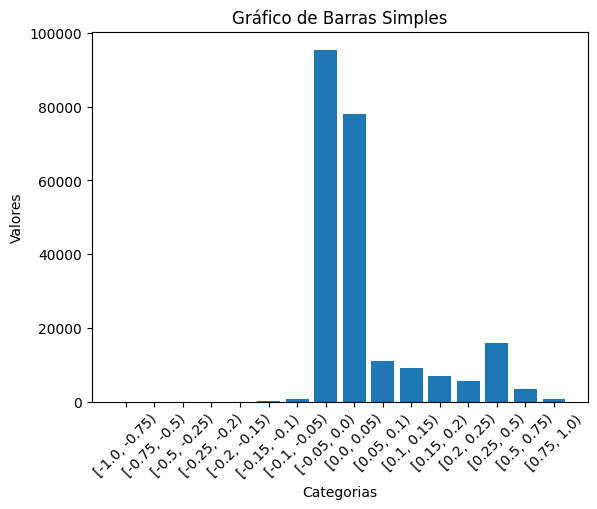

In [101]:
categorias = df_summary_residuos['resid_faixas']
valores = df_summary_residuos['freq']
plt.bar(categorias, valores)
plt.xlabel('Categorias')
plt.ylabel('Valores')
plt.title('Gráfico de Barras Simples')
plt.xticks(rotation=45)
plt.show()

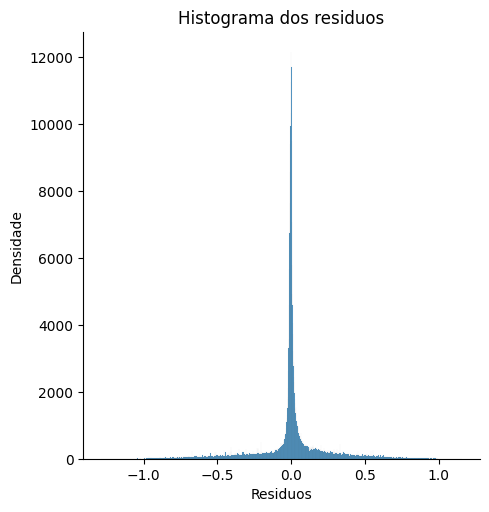

In [800]:
sns.displot(x='residuos', data=feature_store_credito_23)

plt.title("Histograma dos residuos")
plt.xlabel("Residuos")
plt.ylabel("Densidade")

plt.show()

# Descritiva de Resíduos

In [109]:
residuos_faixa_erro = df_resultado_predict.query('(residuos >= -1.0) & (residuos <= -0.1)')
residuos_faixa_acerto = df_resultado_predict.query('(residuos >= 0.00) & (residuos <= 0.05)')

In [117]:
teste_residuo = df_resultado_predict.query('(residuos >= 0.00) & (residuos <= 0.05)')
teste_residuo

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,bairro_encoded,tipo_propriedade_encoded,perc_hist_pago,y_predict,residuos
26,0000b23be5378f1b8e79cf1867e8cc19,68de448b7a43947490ecf5aaf6be6eb7,e8f779a348c050b1,2023.0,53.0,32.00,1,SALA,BOA VISTA,0,...,0.250000,0.000000,0.0,1.0,1.0,13,17,1.000000,0.996554,0.003446
29,0000b23be5378f1b8e79cf1867e8cc19,99fe1c4df3bee62f90ecf5aaf6be6eb7,f42760d51259d181,2023.0,30.0,53.00,1,SALA,BOA VISTA,0,...,0.250000,0.000000,0.0,1.0,1.0,13,17,1.000000,0.997870,0.002130
38,0000b23be5378f1b8e79cf1867e8cc19,e7b87d7713fd44a490ecf5aaf6be6eb7,f4a09ae3e8291db3,2023.0,53.0,28.00,1,SALA,BOA VISTA,0,...,0.250000,0.000000,0.0,1.0,1.0,13,17,1.000000,0.996554,0.003446
80,00033f0e4ec8a051ec24828071529570,7802f67ca154b1a790ecf5aaf6be6eb7,3d50edba801743d5,2023.0,13.0,98.50,1,APARTAMENTO,CASA AMARELA,0,...,0.000000,0.142857,1.0,1.0,1.0,24,0,1.000000,0.995849,0.004151
86,00040be7a77b87e0344d77602867ec09,0db3ee4a4e9b9a9890ecf5aaf6be6eb7,9c4e9d06c9acf441,2023.0,38.0,77.88,1,APARTAMENTO,BOA VIAGEM,0,...,0.000000,0.000000,0.0,1.0,1.0,12,0,1.000000,0.999040,0.000960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924645,fffd88df00cf0ced2a13d3ea4dcea995,f2507502104728d990ecf5aaf6be6eb7,023d701429cabc6c,2023.0,25.0,177.45,1,APARTAMENTO,ENCRUZILHADA,0,...,0.250000,0.000000,0.0,1.0,1.0,38,0,1.000000,0.999123,0.000877
1924682,ffff0e3e56845cdf1603ecd7ff6be21f,cb9019b08c2d102890ecf5aaf6be6eb7,9e35a4e145d6a8bc,2023.0,26.0,84.00,1,CASA,ALTO SANTA TEREZINHA,0,...,0.000000,0.142857,1.0,1.0,1.0,6,1,0.845135,0.950502,0.049498
1924691,ffff3836dbf935321bc34267b5521a39,e896b1265fdb1d5390ecf5aaf6be6eb7,0cfe1aa6943523cf,2023.0,12.0,209.97,1,APARTAMENTO,BOA VIAGEM,0,...,0.000000,0.000000,0.0,1.0,1.0,12,0,1.000000,0.999408,0.000592
1924703,ffffc6563e67d8b38e79cf1867e8cc19,a25c32e4e030935c90ecf5aaf6be6eb7,18be5a8c332a3892,2023.0,41.0,86.13,1,APARTAMENTO,IPUTINGA,0,...,0.142857,0.000000,0.0,1.0,1.0,52,0,1.000000,0.999519,0.000481


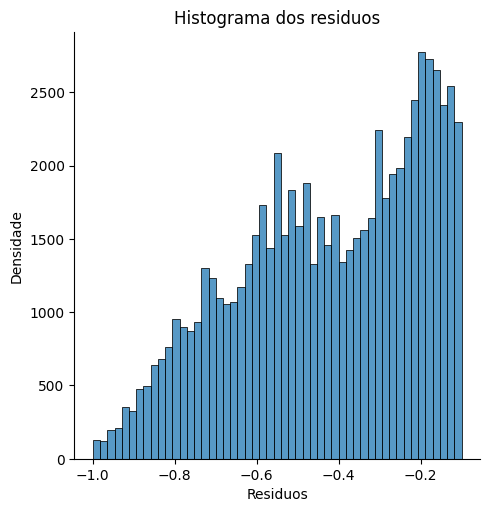

In [786]:
sns.displot(x='residuos', data=residuos_faixa_erro)

plt.title("Histograma dos residuos")
plt.xlabel("Residuos")
plt.ylabel("Densidade")

plt.show()

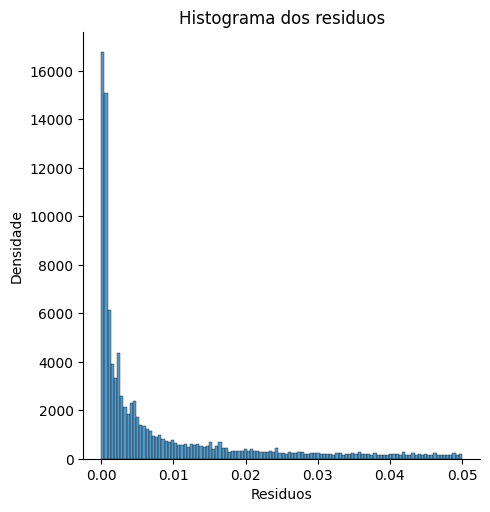

In [787]:
sns.displot(x='residuos', data=residuos_faixa_acerto)

plt.title("Histograma dos residuos")
plt.xlabel("Residuos")
plt.ylabel("Densidade")

plt.show()

In [788]:
desc_erro = residuos_faixa_erro.describe()
desc_acerto = residuos_faixa_acerto.describe()

print("Estatísticas Descritivas para Faixa de Erro:")
desc_erro

Estatísticas Descritivas para Faixa de Erro:


,ano,idade_imovel,area_construida,natureza_imovel,aberto,num_imoveis,vlr_aberto,vlr_pago,vlr_lancado,pgt_cota_unica,...,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,bairro_encoded,tipo_propriedade_encoded,perc_hist_pago,y_predict,residuos
count,71474.0,71474.000000,71474.000000,71474.000000,71474.000000,71474.000000,71474.000000,71474.000000,71474.000000,71474.000000,...,71474.000000,71474.000000,71474.000000,71474.000000,71441.000000,71474.000000,71474.000000,71474.000000,71474.000000,71474.000000
mean,2023.0,35.043806,138.298455,0.944455,0.999314,76.112908,2711.026933,289.740315,3000.767247,0.314268,...,0.076112,0.720419,0.578834,0.082439,0.789533,42.714050,3.560945,0.589442,0.508414,-0.425975
std,0.0,20.038285,596.991059,0.229042,0.026174,264.803092,11188.207592,1711.120320,11494.998572,0.464227,...,0.107414,0.329779,0.281910,0.190431,0.407643,28.683474,6.344325,0.266805,0.245307,0.224376
min,2023.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.010000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100009,-0.999402
25%,2023.0,20.000000,57.600000,1.000000,1.000000,1.000000,592.010000,0.000000,682.152500,0.000000,...,0.000000,0.428571,0.500000,0.000000,1.000000,13.000000,0.000000,0.363388,0.289742,-0.593198
50%,2023.0,35.000000,87.580000,1.000000,1.000000,2.000000,1227.005000,0.000000,1441.170000,0.000000,...,0.000000,0.909091,0.666667,0.000000,1.000000,40.000000,1.000000,0.607989,0.512630,-0.402161
75%,2023.0,45.000000,143.077500,1.000000,1.000000,13.000000,2416.152500,0.000000,2658.842500,1.000000,...,0.181818,1.000000,0.800000,0.000000,1.000000,67.000000,1.000000,0.812333,0.707838,-0.223584
max,2023.0,106.000000,72704.810000,1.000000,1.000000,1554.000000,981908.440000,294788.430000,981908.440000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,94.000000,19.000000,1.000000,1.212847,-0.100009


In [789]:
print("\nEstatísticas Descritivas para Faixa de Acerto:")
desc_acerto


Estatísticas Descritivas para Faixa de Acerto:


,ano,idade_imovel,area_construida,natureza_imovel,aberto,num_imoveis,vlr_aberto,vlr_pago,vlr_lancado,pgt_cota_unica,...,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,bairro_encoded,tipo_propriedade_encoded,perc_hist_pago,y_predict,residuos
count,99307.0,99307.000000,99307.000000,99307.000000,99307.000000,99307.000000,99307.000000,9.930700e+04,9.930700e+04,99307.000000,...,99307.000000,99307.000000,99307.000000,99307.000000,99236.000000,99307.000000,99307.000000,99307.000000,99307.000000,9.930700e+04
mean,2023.0,31.864451,154.420396,0.987695,0.120757,10.076107,218.645459,3.036168e+03,3.254814e+03,0.394363,...,0.106144,0.221304,0.352429,0.891508,0.905609,41.770963,2.192011,0.877347,0.883214,8.293392e-03
std,0.0,20.088886,534.645837,0.110245,0.325846,42.556521,1952.905184,1.583112e+04,1.614991e+04,0.488716,...,0.140519,0.353058,0.446428,0.305053,0.292374,28.250104,5.115484,0.298269,0.306022,1.178516e-02
min,2023.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.924000e+01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.048999,5.960464e-08
25%,2023.0,15.000000,72.000000,1.000000,0.000000,1.000000,0.000000,6.762000e+02,8.619800e+02,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,12.000000,0.000000,0.958050,0.980170,6.193817e-04
50%,2023.0,29.000000,102.590000,1.000000,0.000000,1.000000,0.000000,1.539600e+03,1.646250e+03,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,39.000000,0.000000,1.000000,0.997033,2.647561e-03
75%,2023.0,43.000000,165.230000,1.000000,0.000000,2.000000,0.000000,2.985600e+03,3.128050e+03,1.000000,...,0.222222,0.285714,0.818182,1.000000,1.000000,67.000000,1.000000,1.000000,0.999367,1.079807e-02
max,2023.0,109.000000,46392.000000,1.000000,1.000000,1554.000000,270424.940000,1.582603e+06,1.582603e+06,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,94.000000,19.000000,1.000000,1.000000,4.999894e-02


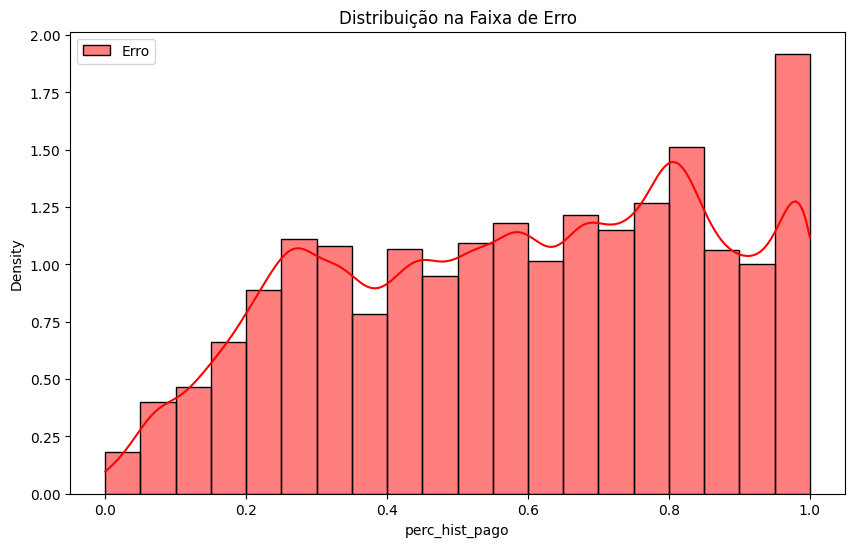

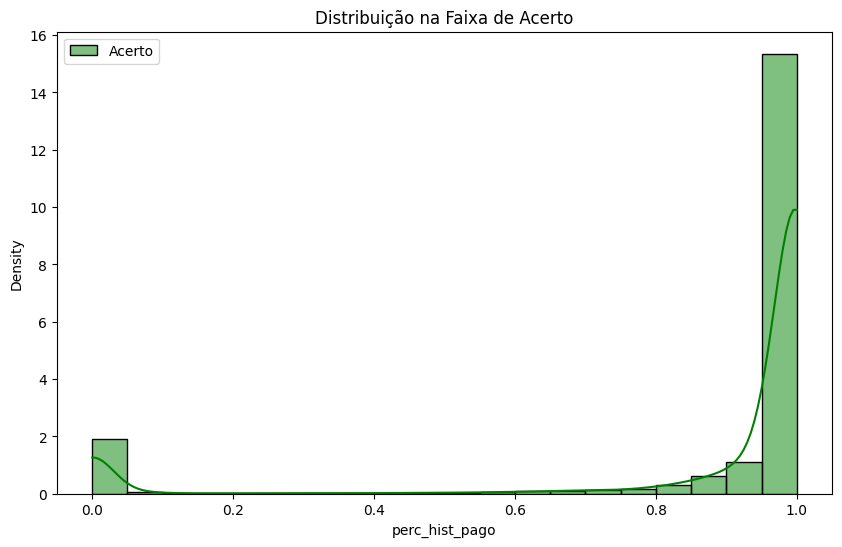

In [795]:
# Histograma para faixa de erro
plt.figure(figsize=(10, 6))
sns.histplot(residuos_faixa_erro['perc_hist_pago'], bins=20, kde=True, color='red', label='Erro', density=True)
plt.title('Distribuição na Faixa de Erro')
plt.legend()
plt.show()

# Histograma para faixa de acerto
plt.figure(figsize=(10, 6))
sns.histplot(residuos_faixa_acerto['perc_hist_pago'], bins=20, kde=True, color='green', label='Acerto', density=True)
plt.title('Distribuição na Faixa de Acerto')
plt.legend()
plt.show()



In [789]:
correlation_erro = residuos_faixa_erro[['area_construida', 'reco_credito', 'hist_pagamento', 'hist_lancado',
             'percentual_reco_divida_ativa', 'percentual_pago_cota', 'percentual_reco_debito',
            'idade_imovel','tipo_contribuinte', 'percentual_pago']].corr()
print("Correlação para Faixa de Erro:")
correlation_erro

Correlação para Faixa de Erro:


,area_construida,reco_credito,hist_pagamento,hist_lancado,percentual_reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,idade_imovel,tipo_contribuinte,percentual_pago
area_construida,1.000000,-0.015179,0.094669,0.135752,0.011322,-0.003495,0.022186,0.026343,-0.053489,-0.001583
reco_credito,-0.015179,1.000000,0.411755,0.418481,0.303018,0.047669,0.259373,-0.098847,-0.472838,0.025079
hist_pagamento,0.094669,0.411755,1.000000,0.963933,0.294309,0.165517,0.404391,-0.028532,-0.492201,0.035619
hist_lancado,0.135752,0.418481,0.963933,1.000000,0.304824,0.164673,0.427410,-0.018112,-0.507671,0.021541
percentual_reco_divida_ativa,0.011322,0.303018,0.294309,0.304824,1.000000,0.099228,0.799192,0.009544,-0.352570,0.006829
percentual_pago_cota,-0.003495,0.047669,0.165517,0.164673,0.099228,1.000000,0.227873,-0.050661,-0.251601,-0.013657
percentual_reco_debito,0.022186,0.259373,0.404391,0.427410,0.799192,0.227873,1.000000,-0.006762,-0.467215,-0.045611
idade_imovel,0.026343,-0.098847,-0.028532,-0.018112,0.009544,-0.050661,-0.006762,1.000000,0.191291,-0.026630
tipo_contribuinte,-0.053489,-0.472838,-0.492201,-0.507671,-0.352570,-0.251601,-0.467215,0.191291,1.000000,-0.003433
percentual_pago,-0.001583,0.025079,0.035619,0.021541,0.006829,-0.013657,-0.045611,-0.026630,-0.003433,1.000000


In [791]:
correlation_acerto = residuos_faixa_acerto[['area_construida', 'reco_credito', 'hist_pagamento', 'hist_lancado',
             'percentual_reco_divida_ativa', 'percentual_pago_cota', 'percentual_reco_debito',
            'idade_imovel','tipo_contribuinte', 'percentual_pago']].corr()
print("\nCorrelação para Faixa de Acerto:")
correlation_acerto


Correlação para Faixa de Acerto:


,area_construida,reco_credito,hist_pagamento,hist_lancado,percentual_reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,idade_imovel,tipo_contribuinte,percentual_pago
area_construida,1.000000,0.027770,0.110219,0.110103,-0.003798,0.007609,-0.010260,0.005433,-0.091692,0.017830
reco_credito,0.027770,1.000000,0.110994,0.109519,-0.365840,0.278638,-0.710894,-0.074726,-0.131793,0.804444
hist_pagamento,0.110219,0.110994,1.000000,0.995229,0.074536,0.078251,0.004119,-0.063419,-0.331164,0.059732
hist_lancado,0.110103,0.109519,0.995229,1.000000,0.080274,0.075463,0.015022,-0.060696,-0.336768,0.052368
percentual_reco_divida_ativa,-0.003798,-0.365840,0.074536,0.080274,1.000000,-0.277962,0.692868,0.081539,-0.073844,-0.420012
percentual_pago_cota,0.007609,0.278638,0.078251,0.075463,-0.277962,1.000000,-0.384577,-0.125155,-0.073916,0.447159
percentual_reco_debito,-0.010260,-0.710894,0.004119,0.015022,0.692868,-0.384577,1.000000,0.123376,-0.080898,-0.839679
idade_imovel,0.005433,-0.074726,-0.063419,-0.060696,0.081539,-0.125155,0.123376,1.000000,0.123539,-0.150619
tipo_contribuinte,-0.091692,-0.131793,-0.331164,-0.336768,-0.073844,-0.073916,-0.080898,0.123539,1.000000,-0.045040
percentual_pago,0.017830,0.804444,0.059732,0.052368,-0.420012,0.447159,-0.839679,-0.150619,-0.045040,1.000000


In [801]:
variaveis = ['area_construida', 'reco_credito', 'hist_pagamento', 'hist_lancado',
             'percentual_reco_divida_ativa', 'percentual_pago_cota', 'percentual_reco_debito',
            'idade_imovel','tipo_contribuinte', 'percentual_pago', 'y_predict', 'residuos']
visualizacao_de_erros = residuos_faixa_erro[variaveis]
visualizacao_de_erros

,area_construida,reco_credito,hist_pagamento,hist_lancado,percentual_reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,idade_imovel,tipo_contribuinte,percentual_pago,y_predict,residuos
59,47.00,9.0,8156.78,9825.52,0.500000,0.111111,0.222222,41.0,1.0,0.0,0.795167,-0.795167
61,45.00,9.0,8156.78,9825.52,0.500000,0.111111,0.222222,41.0,1.0,0.0,0.789428,-0.789428
257,82.25,3.0,2423.20,2423.20,0.800000,0.000000,1.000000,40.0,1.0,0.0,0.773910,-0.773910
585,612.82,4.0,18186.53,26099.44,0.857143,0.250000,1.000000,26.0,1.0,0.0,0.770987,-0.770987
2297,218.40,2.0,4994.19,4994.19,0.800000,0.000000,1.000000,73.0,1.0,0.0,0.864692,-0.864692
...,...,...,...,...,...,...,...,...,...,...,...,...
1920609,129.98,8.0,73542.14,73542.14,0.000000,0.125000,0.125000,35.0,1.0,0.0,0.827278,-0.827278
1920822,39.35,8.0,64210.05,64379.16,0.000000,0.250000,0.125000,35.0,1.0,0.0,0.773538,-0.773538
1923076,173.39,8.0,28784.75,31729.40,0.000000,0.000000,0.125000,12.0,1.0,0.0,0.780851,-0.780851
1923726,130.31,10.0,39343.87,45239.03,0.666667,0.000000,0.300000,40.0,1.0,0.0,0.894950,-0.894950


In [803]:
variaveis = ['area_construida', 'reco_credito', 'hist_pagamento', 'hist_lancado',
             'percentual_reco_divida_ativa', 'percentual_pago_cota', 'percentual_reco_debito',
            'idade_imovel','tipo_contribuinte', 'percentual_pago', 'y_predict', 'residuos']
visualizacao_de_acertos = residuos_faixa_acerto[variaveis]
visualizacao_de_acertos

,area_construida,reco_credito,hist_pagamento,hist_lancado,percentual_reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,idade_imovel,tipo_contribuinte,percentual_pago,y_predict,residuos
0,110.15,3.0,721.31,3339.77,0.6,0.000000,1.0,55.0,1.0,0.0,0.009512,-0.009512
8,132.71,8.0,12616.81,12616.81,0.0,0.000000,0.0,30.0,1.0,1.0,1.000410,-0.000410
12,151.45,8.0,26242.50,26242.50,0.0,0.250000,0.0,15.0,1.0,1.0,1.013706,-0.013706
26,32.00,8.0,17014.14,17014.14,0.0,0.250000,0.0,53.0,1.0,1.0,1.002092,-0.002092
29,53.00,8.0,17014.14,17014.14,0.0,0.250000,0.0,30.0,1.0,1.0,0.976314,0.023686
...,...,...,...,...,...,...,...,...,...,...,...,...
1924691,209.97,8.0,37074.07,37074.07,0.0,0.000000,0.0,12.0,1.0,1.0,1.003855,-0.003855
1924698,213.00,8.0,13677.51,13677.51,0.0,0.000000,0.0,40.0,1.0,1.0,1.013269,-0.013269
1924703,86.13,7.0,14683.46,14683.46,0.0,0.142857,0.0,41.0,1.0,1.0,0.998145,0.001855
1924707,159.80,7.0,14683.46,14683.46,0.0,0.142857,0.0,31.0,1.0,1.0,0.996832,0.003168


In [810]:
4028 / 202957 * 100


1.9846568484950013

In [805]:
visualizacao_de_acertos['hist_pagamento'].describe()

count    2.029570e+05
mean     2.312097e+05
std      2.114972e+06
min      0.000000e+00
25%      3.276630e+03
50%      1.104071e+04
75%      3.198681e+04
max      8.375863e+07
Name: hist_pagamento, dtype: float64

In [ ]:
categorias = residuos_faixa_erro['resid_faixas']
valores = df_summary_residuos['hist_pagamento']
plt.bar(categorias, valores)
plt.xlabel('Categorias')
plt.ylabel('Valores')
plt.title('Gráfico de Barras Simples')
plt.xticks(rotation=45)
plt.show()

# ANÁLISE ISOLADA DA RELAÇÃO DE UMA FEATURE COM OS RESÍDUOS

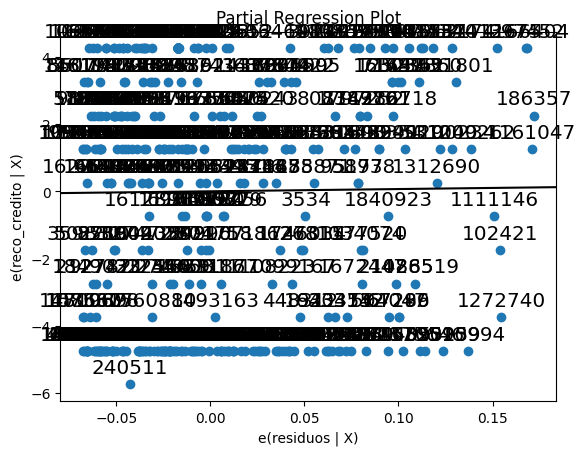

In [695]:
from statsmodels.graphics.regressionplots import plot_partregress
plot_partregress('reco_credito', 'residuos', [], data=residuos_faixa)
plt.show()

# IDENTIFICAÇÃO DE OUTLIERS

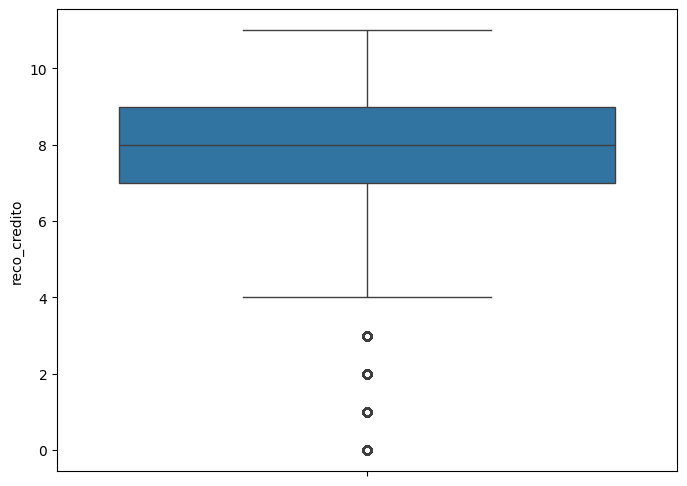

Outliers:


,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,tipo_propriedade,aberto,bairro,num_imoveis,...,pgt_cota_unica,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago,y_predict,residuos


In [696]:
plt.figure(figsize=(8, 6))
sns.boxplot(y='reco_credito', data=feature_store_credito_23)
plt.show()

# IQR
Q1 = residuos_faixa['reco_credito'].quantile(0.25)
Q3 = residuos_faixa['reco_credito'].quantile(0.75)
IQR = Q3 - Q1

# limites para identificar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# outliers
outliers = residuos_faixa[(residuos_faixa['reco_credito'] < limite_inferior) | (residuos_faixa['reco_credito'] > limite_superior)]

print("Outliers:")
outliers


In [690]:
outliers[['id_contribuinte', 'dam', 'area_construida', 'reco_debito','reco_credito', 
                          'num_imoveis', 'hist_pagamento', 'hist_lancado','idade_imovel', 'pgt_cota_unica',
                          'vlr_pago', 'vlr_lancado', 'percentual_pago', 'y_predict', 'residuos']]

,id_contribuinte,dam,area_construida,reco_debito,reco_credito,num_imoveis,hist_pagamento,hist_lancado,idade_imovel,pgt_cota_unica,vlr_pago,vlr_lancado,percentual_pago,y_predict,residuos
102421,0dc0da7cfe15e6518e79cf1867e8cc19,256be86be65eb77f90ecf5aaf6be6eb7,204.12,1.0,5.0,3.0,3475.00,24245.52,77.0,0.0,2573.28,2573.28,1.0,0.028110,0.971890
186357,188b9537d43319af8e79cf1867e8cc19,61b7a227f76e6bb090ecf5aaf6be6eb7,78.58,2.0,9.0,2.0,46260.65,53896.74,32.0,0.0,1129.15,1129.15,1.0,0.010290,0.989710
397452,345e467b73c67f33191041d2a59c9dc0,93e2bc0c96950e2690ecf5aaf6be6eb7,0.00,2.0,11.0,53.0,102476.69,395490.26,40.0,1.0,1019.78,1019.78,1.0,0.013988,0.986012
520139,44ed097e02cecdc2d8b209292c0ce31d,c3c6323cab409f5c90ecf5aaf6be6eb7,13.00,0.0,2.0,1.0,145.18,361.97,41.0,1.0,145.18,145.18,1.0,0.058520,0.941480
531040,464cf959656db2b351a3f7d645cf63e5,fa94fb9283debd8390ecf5aaf6be6eb7,92.00,2.0,8.0,1.0,4375.79,13600.25,18.0,0.0,2104.70,2104.70,1.0,0.060017,0.939983
551801,490d79bed89a592d64baa3c49d28f0be,ab5b3e0877802b8490ecf5aaf6be6eb7,0.00,2.0,10.0,13.0,29176.27,61224.36,40.0,1.0,2957.70,2957.70,1.0,0.051840,0.948160
590994,4e4a97244095bcea1603ecd7ff6be21f,a967f9737e73332f90ecf5aaf6be6eb7,31.44,0.0,2.0,1.0,273.84,634.63,57.0,0.0,257.83,257.83,1.0,0.045198,0.954802
1012675,878ed023fa473bede000edc2a2086273,bef332a3025d93f290ecf5aaf6be6eb7,49.82,2.0,11.0,1554.0,2256124.25,8337187.30,35.0,1.0,253.04,253.04,1.0,0.029806,0.970194
1013174,878ed023fa473bede000edc2a2086273,d5e351ef440d4e9390ecf5aaf6be6eb7,59.00,2.0,11.0,1554.0,2256124.25,8337187.30,41.0,1.0,411.39,411.39,1.0,0.053840,0.946160
1100234,92dfefb684fb72d09daa7b7dbb545c1c,18379b08f4e665b190ecf5aaf6be6eb7,32.29,2.0,8.0,2.0,28851.10,36504.01,28.0,0.0,515.36,515.36,1.0,0.053937,0.946063


<Axes: >

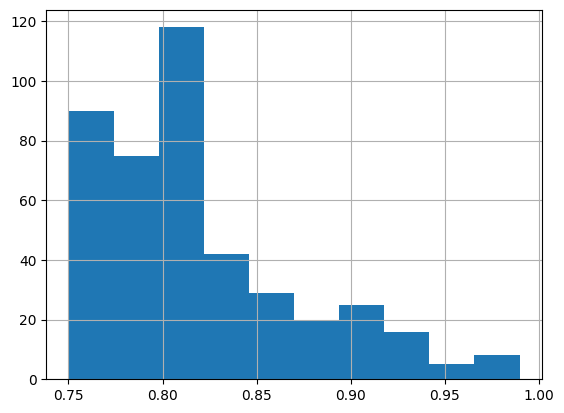

In [685]:
residuos_faixa['residuos'].hist()

In [ ]:
correlacao = seu_dataframe[features + ['residuos']].corr()

---

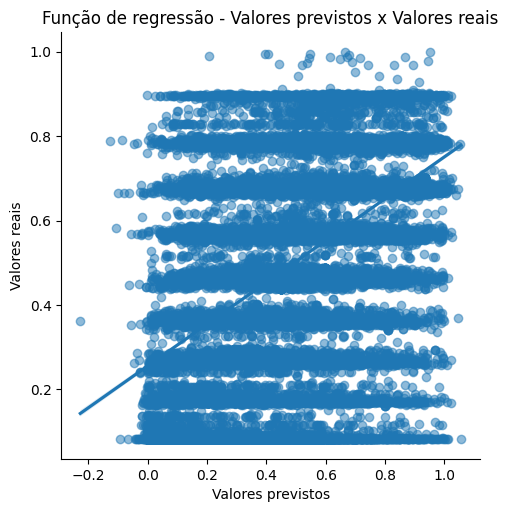

In [515]:
df_regressao = feature_store_credito_23.query("percentual_pago != 1").query("percentual_pago != 0")

sns.lmplot(x='y_predict' , y='percentual_pago', data=df_regressao, scatter_kws={'alpha': 0.5})

plt.title("Função de regressão - Valores previstos x Valores reais")
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais")
plt.show()

In [ ]:
# Amostras
df_regressao = resid.sample(n=140000)

sns.lmplot(x='y_predict' , y='percentual_pago', data=feature_store_credito_22, scatter_kws={'alpha': 0.5})

plt.title("Função de regressão do IGR - Valores previstos x Valores reais")
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais") 

plt.show()

# regressao logistica

In [66]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

feature_store_credito['tipo_propriedade_encoded'] = le.fit_transform(feature_store_credito['tipo_propriedade'])

print("tipo_propriedade originais:", feature_store_credito['tipo_propriedade'].unique())
print("tipo_propriedade codificados:", feature_store_credito['tipo_propriedade_encoded'].unique())

tipo_propriedade originais: ['CASA' 'APARTAMENTO' 'SALA' 'LOJA' 'TERRENO' 'GARAGEM COMERCIAL'
 'EDIFICAÇÃO ESPECIAL' 'GALPÃO' 'MOCAMBO' 'INDUSTRIA'
 'INSTITUIÇÃO EDUCACIONAL' 'INSTITUIÇÃO FINANCEIRA'
 'CENTRO COMERCIAL/SERVIÇOS' 'HOTEL' 'GALPÃO FECHADO' 'HOSPITAL'
 'TEMPLO RELIGIOSO' 'POSTO DE ABASTECIMENTO' 'LOJA MÚLTIPLA'
 'GARAGEM RESIDENCIAL']
tipo_propriedade codificados: [ 1  0 17 13 19  6  3  4 15 10 11 12  2  9  5  8 18 16 14  7]


In [68]:
feature_store_credito.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago', 'tipo_contribuinte',
       'tipo_propriedade_encoded'],
      dtype='object')

In [69]:
feature_store_credito_ate_22 = feature_store_credito.query('ano < 2023')
feature_store_credito_22 = feature_store_credito.query('ano == 2022')
feature_store_credito_23 = feature_store_credito.query('ano == 2023')
feature_store_credito_22_23 = feature_store_credito.query('ano > 2021')

In [ ]:
feature_store_credito_22['perc_hist_pago'] = (feature_store_credito_22['hist_pagamento'] / feature_store_credito_22['hist_lancado']).fillna(0)

In [ ]:
feature_store_credito_22['pagamento'] = np.where(feature_store_credito_22['vlr_pago'] == feature_store_credito_22['vlr_lancado'], 1, 0)

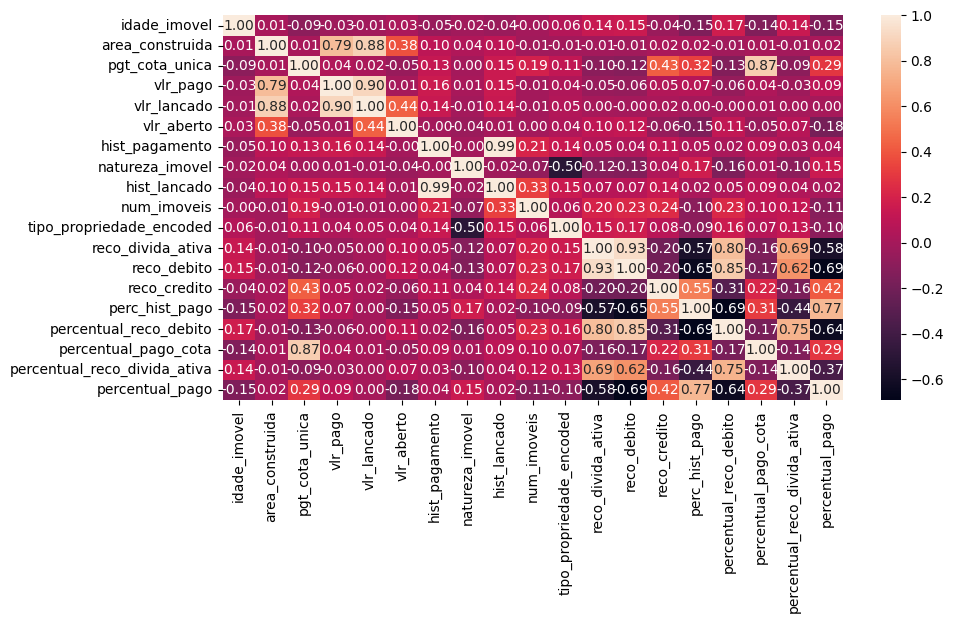

In [72]:
matriz_correlacao = feature_store_credito_22[['idade_imovel', 'area_construida',  'pgt_cota_unica',
                                    'vlr_pago', 'vlr_lancado', 'vlr_aberto', 'hist_pagamento', 'natureza_imovel',
                                    'hist_lancado', 'num_imoveis', 'tipo_propriedade_encoded',
                                    'reco_divida_ativa','reco_debito','reco_credito',
                                    'perc_hist_pago','percentual_reco_debito','percentual_pago_cota',
                                    'percentual_reco_divida_ativa', 'percentual_pago']].corr()
plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
plt.show()

In [73]:
feature_store_credito_22.shape[0]

340659

In [74]:
variaveis = ['idade_imovel', 'num_imoveis','natureza_imovel','reco_credito', 
             'perc_hist_pago','percentual_reco_debito','percentual_pago_cota',
             'reco_divida_ativa', 'percentual_reco_divida_ativa', 'pagamento',
             'tipo_propriedade_encoded']
variaveis_selecionadas = feature_store_credito_22[variaveis]
variaveis_selecionadas.columns

Index(['idade_imovel', 'num_imoveis', 'natureza_imovel', 'reco_credito',
       'perc_hist_pago', 'percentual_reco_debito', 'percentual_pago_cota',
       'reco_divida_ativa', 'percentual_reco_divida_ativa', 'pagamento',
       'tipo_propriedade_encoded'],
      dtype='object')

In [75]:
y = variaveis_selecionadas['pagamento']
x = variaveis_selecionadas.drop(columns=['pagamento'])

In [94]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.3)

In [77]:
normalizador = RobustScaler() #StandardScaler() #StandardScaler()
normalizador.fit(x)
dados_normalizados = normalizador.fit_transform(x)
colunas = list(normalizador.get_feature_names_out())
df_normalizado = pd.DataFrame(dados_normalizados, columns=colunas)

## REGRESSÃO LOGÍSTICA XGBOOST

In [78]:
xbg_logistico = XGBClassifier(objective="binary:logistic", random_state=42)
xbg_logistico.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [79]:
Predicao_probabilidade = xbg_logistico.predict_proba(X_test)[:, 1]

In [80]:
Predicao_0_ou_1 = xbg_logistico.predict(X_test)

In [81]:
conf_matrix = confusion_matrix(y_test, Predicao_0_ou_1)

df_conf_matrix = pd.DataFrame(conf_matrix, index=['Real Negativo', 'Real Positivo'], columns=['Predito Negativo', 'Predito Positivo'])
print("Matriz de Confusão:")
df_conf_matrix 

Matriz de Confusão:


,Predito Negativo,Predito Positivo
Real Negativo,24518,4555
Real Positivo,3290,69835


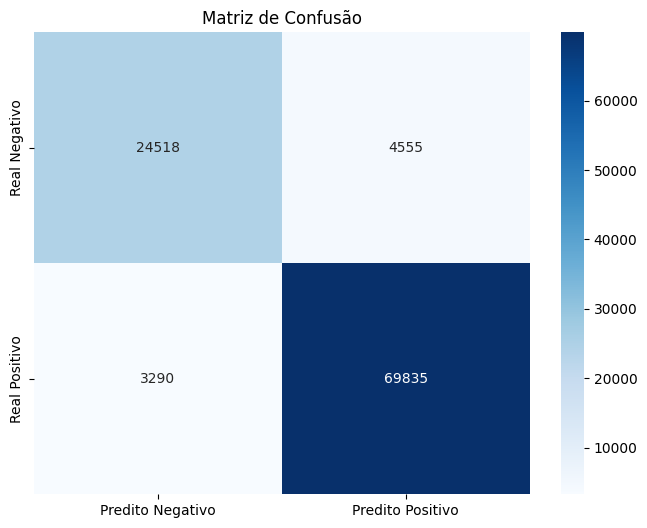

In [82]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

In [83]:
acuracia = accuracy_score(y_test, Predicao_0_ou_1)
roc_auc = roc_auc_score(y_test, Predicao_probabilidade)
precisao = precision_score(y_test, Predicao_0_ou_1)
revocacao = recall_score(y_test, Predicao_0_ou_1)
f1 = f1_score(y_test, Predicao_0_ou_1)
print(f"Accuracia: {acuracia}")
print(f"ROC AUC: {roc_auc}")
print(f"Precisão: {precisao}")
print(f"Revocação (Sensibilidade): {revocacao}")
print(f"F1 Score: {f1}")

Accuracia: 0.923237245347267
ROC AUC: 0.9802864772172377
Precisão: 0.9387686517004974
Revocação (Sensibilidade): 0.955008547008547
F1 Score: 0.9468189675626207


## REGRESSÃO LOGÍSTICA

In [ ]:
modelo_logistico = LogisticRegression()
modelo_logistico.fit(X_train, y_train)

In [273]:
Predicao_probabilidade = modelo_logistico.predict_proba(X_test)[:, 1]

In [274]:
Predicao_0_ou_1 = modelo_logistico.predict(X_test)

In [275]:
conf_matrix = confusion_matrix(y_test, Predicao_0_ou_1)

df_conf_matrix = pd.DataFrame(conf_matrix, index=['Real Negativo', 'Real Positivo'], columns=['Predito Negativo', 'Predito Positivo'])
print("Matriz de Confusão:")
df_conf_matrix 

Matriz de Confusão:


,Predito Negativo,Predito Positivo
Real Negativo,21436,7637
Real Positivo,3156,69969


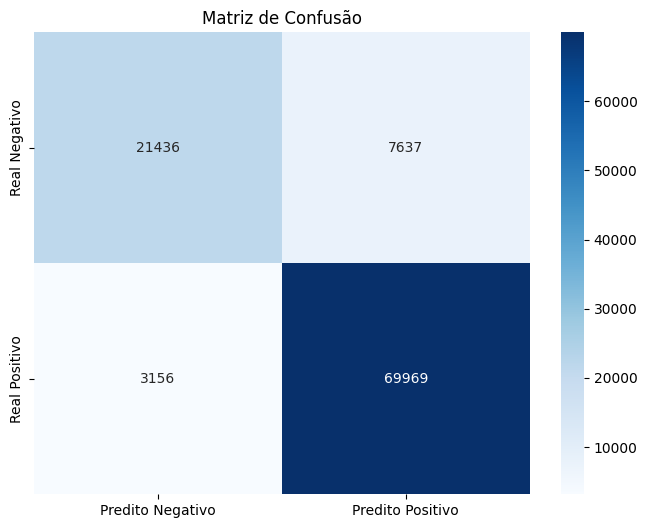

In [276]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

In [277]:
acuracia = accuracy_score(y_test, Predicao_0_ou_1)
roc_auc = roc_auc_score(y_test, Predicao_probabilidade)
precisao = precision_score(y_test, Predicao_0_ou_1)
revocacao = recall_score(y_test, Predicao_0_ou_1)
f1 = f1_score(y_test, Predicao_0_ou_1)
print(f"Accuracia: {acuracia}")
print(f"ROC AUC: {roc_auc}")
print(f"Precisão: {precisao}")
print(f"Revocação (Sensibilidade): {revocacao}")
print(f"F1 Score: {f1}")

Accuracia: 0.8943912796727921
ROC AUC: 0.9486701367409653
Precisão: 0.9015926603613122
Revocação (Sensibilidade): 0.9568410256410257
F1 Score: 0.928395618684942


# PREDIÇÃO

In [103]:
df_feature_store_predict = feature_store_credito_23

In [104]:
df_feature_store_predict.shape[0]

344781

In [105]:
df_feature_store_predict['perc_hist_pago'] = (df_feature_store_predict['hist_pagamento'] / df_feature_store_predict['hist_lancado']).fillna(0)
df_feature_store_predict['pagamento'] = np.where(df_feature_store_predict['vlr_pago'] == df_feature_store_predict['vlr_lancado'], 1, 0)

C:\Users\Acer\AppData\Local\Temp\ipykernel_26688\230171861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_store_predict['perc_hist_pago'] = (df_feature_store_predict['hist_pagamento'] / df_feature_store_predict['hist_lancado']).fillna(0)
C:\Users\Acer\AppData\Local\Temp\ipykernel_26688\230171861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_store_predict['pagamento'] = np.where(df_feature_store_predict['vlr_pago'] == df_feature_store_predict['vlr_lancado'], 1, 0)


In [106]:
df_feature_store_predict.head()

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,pagamento,predicao
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,55.0,110.15,1,CASA,AREIAS,1,...,0.0,0.00,1.0,0.6,0.0,1.0,1,0.215976,0,0
8,00003a695da4777aec557718ffae83ea,9b2d05920c173e8190ecf5aaf6be6eb7,6b7e2fa2f4f1a593,2023.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,0.0,0.00,0.0,0.0,1.0,1.0,0,1.000000,1,1
12,000046c85d18a6f7968646cfc1e328f2,4a3c62195a4def8990ecf5aaf6be6eb7,4c440987414316f6,2023.0,15.0,151.45,1,APARTAMENTO,BOA VIAGEM,0,...,0.0,0.25,0.0,0.0,1.0,1.0,0,1.000000,1,1
26,0000b23be5378f1b8e79cf1867e8cc19,68de448b7a43947490ecf5aaf6be6eb7,e8f779a348c050b1,2023.0,53.0,32.00,1,SALA,BOA VISTA,0,...,0.0,0.25,0.0,0.0,1.0,1.0,17,1.000000,1,1
29,0000b23be5378f1b8e79cf1867e8cc19,99fe1c4df3bee62f90ecf5aaf6be6eb7,f42760d51259d181,2023.0,30.0,53.00,1,SALA,BOA VISTA,0,...,0.0,0.25,0.0,0.0,1.0,1.0,17,1.000000,1,1


In [107]:
variaveis = ['idade_imovel', 'num_imoveis','natureza_imovel','reco_credito', 
             'perc_hist_pago','percentual_reco_debito','percentual_pago_cota',
             'reco_divida_ativa', 'percentual_reco_divida_ativa', 'pagamento',
             'tipo_propriedade_encoded']
variaveis_selecionadas = df_feature_store_predict[variaveis]
variaveis_selecionadas.columns

Index(['idade_imovel', 'num_imoveis', 'natureza_imovel', 'reco_credito',
       'perc_hist_pago', 'percentual_reco_debito', 'percentual_pago_cota',
       'reco_divida_ativa', 'percentual_reco_divida_ativa', 'pagamento',
       'tipo_propriedade_encoded'],
      dtype='object')

In [271]:
y = variaveis_selecionadas['pagamento']
x = variaveis_selecionadas.drop(columns=['pagamento'])

In [272]:
predicao_0_1 = xbg_logistico.predict(x)
predicao = xbg_logistico.predict_proba(x)[:, 1]

In [273]:
limiar = 0.666735
predicoes_binarias = (predicao_0_1 >= limiar).astype(int)

In [274]:
df_resultado_predict = df_feature_store_predict

In [275]:
df_resultado_predict['predicao'] = predicao
df_resultado_predict['predicao_binaria'] = predicoes_binarias

C:\Users\Acer\AppData\Local\Temp\ipykernel_26688\350096113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultado_predict['predicao'] = predicao
C:\Users\Acer\AppData\Local\Temp\ipykernel_26688\350096113.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultado_predict['predicao_binaria'] = predicoes_binarias


In [276]:
df_resultado_predict

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,pagamento,predicao,predicao_binaria
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,55.0,110.15,1,CASA,AREIAS,1,...,0.000000,1.0,0.6,0.0,1.0,1,0.215976,0,0.005363,0
8,00003a695da4777aec557718ffae83ea,9b2d05920c173e8190ecf5aaf6be6eb7,6b7e2fa2f4f1a593,2023.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,0.000000,0.0,0.0,1.0,1.0,0,1.000000,1,0.999948,1
12,000046c85d18a6f7968646cfc1e328f2,4a3c62195a4def8990ecf5aaf6be6eb7,4c440987414316f6,2023.0,15.0,151.45,1,APARTAMENTO,BOA VIAGEM,0,...,0.250000,0.0,0.0,1.0,1.0,0,1.000000,1,0.999976,1
26,0000b23be5378f1b8e79cf1867e8cc19,68de448b7a43947490ecf5aaf6be6eb7,e8f779a348c050b1,2023.0,53.0,32.00,1,SALA,BOA VISTA,0,...,0.250000,0.0,0.0,1.0,1.0,17,1.000000,1,0.999864,1
29,0000b23be5378f1b8e79cf1867e8cc19,99fe1c4df3bee62f90ecf5aaf6be6eb7,f42760d51259d181,2023.0,30.0,53.00,1,SALA,BOA VISTA,0,...,0.250000,0.0,0.0,1.0,1.0,17,1.000000,1,0.999928,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924691,ffff3836dbf935321bc34267b5521a39,e896b1265fdb1d5390ecf5aaf6be6eb7,0cfe1aa6943523cf,2023.0,12.0,209.97,1,APARTAMENTO,BOA VIAGEM,0,...,0.000000,0.0,0.0,1.0,1.0,0,1.000000,1,0.999922,1
1924698,ffff63826b501d84d8b209292c0ce31d,f307f8927e07ff0690ecf5aaf6be6eb7,e5ef9115acfa782e,2023.0,40.0,213.00,1,CASA,CORDEIRO,0,...,0.000000,0.0,0.0,1.0,1.0,1,1.000000,1,0.999917,1
1924703,ffffc6563e67d8b38e79cf1867e8cc19,a25c32e4e030935c90ecf5aaf6be6eb7,18be5a8c332a3892,2023.0,41.0,86.13,1,APARTAMENTO,IPUTINGA,0,...,0.142857,0.0,0.0,1.0,1.0,0,1.000000,1,0.999928,1
1924707,ffffc6563e67d8b38e79cf1867e8cc19,d73b874b4949665490ecf5aaf6be6eb7,0fb91ca37fa4509b,2023.0,31.0,159.80,1,APARTAMENTO,CORDEIRO,0,...,0.142857,0.0,0.0,1.0,1.0,0,1.000000,1,0.999950,1


In [277]:
df_resultado_predict[['id_contribuinte', 'dam', 'id_imovel', 'ano',
                      'aberto','vlr_aberto', 'vlr_pago',
                      'perc_hist_pago', 'pagamento','percentual_pago', 'predicao']]

,id_contribuinte,dam,id_imovel,ano,aberto,vlr_aberto,vlr_pago,perc_hist_pago,pagamento,percentual_pago,predicao
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,1,1158.44,0.00,0.215976,0,0.0,0.005363
8,00003a695da4777aec557718ffae83ea,9b2d05920c173e8190ecf5aaf6be6eb7,6b7e2fa2f4f1a593,2023.0,0,0.00,1904.40,1.000000,1,1.0,0.999948
12,000046c85d18a6f7968646cfc1e328f2,4a3c62195a4def8990ecf5aaf6be6eb7,4c440987414316f6,2023.0,0,0.00,3982.40,1.000000,1,1.0,0.999976
26,0000b23be5378f1b8e79cf1867e8cc19,68de448b7a43947490ecf5aaf6be6eb7,e8f779a348c050b1,2023.0,0,0.00,351.48,1.000000,1,1.0,0.999864
29,0000b23be5378f1b8e79cf1867e8cc19,99fe1c4df3bee62f90ecf5aaf6be6eb7,f42760d51259d181,2023.0,0,0.00,1066.80,1.000000,1,1.0,0.999928
...,...,...,...,...,...,...,...,...,...,...,...
1924691,ffff3836dbf935321bc34267b5521a39,e896b1265fdb1d5390ecf5aaf6be6eb7,0cfe1aa6943523cf,2023.0,0,0.00,5681.83,1.000000,1,1.0,0.999922
1924698,ffff63826b501d84d8b209292c0ce31d,f307f8927e07ff0690ecf5aaf6be6eb7,e5ef9115acfa782e,2023.0,0,0.00,2085.70,1.000000,1,1.0,0.999917
1924703,ffffc6563e67d8b38e79cf1867e8cc19,a25c32e4e030935c90ecf5aaf6be6eb7,18be5a8c332a3892,2023.0,0,0.00,746.40,1.000000,1,1.0,0.999928
1924707,ffffc6563e67d8b38e79cf1867e8cc19,d73b874b4949665490ecf5aaf6be6eb7,0fb91ca37fa4509b,2023.0,0,0.00,1786.30,1.000000,1,1.0,0.999950


In [278]:
observado = df_feature_store_predict['pagamento']

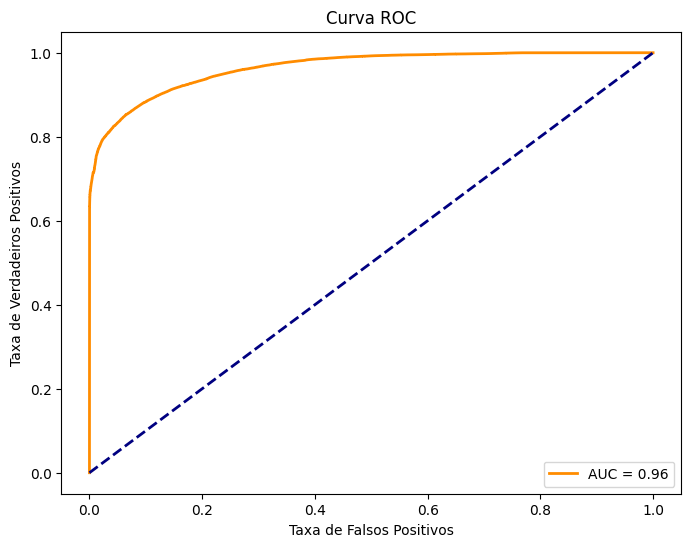

In [279]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(observado, predicao)

limiar_encontrado = 0.666735
# Encontrar o índice do limiar mais próximo ao valor desejado
indice_limiar = (np.abs(thresholds - limiar_encontrado)).argmin()
limiar_selecionado = thresholds[indice_limiar]
predicoes_binarias = (predicao >= limiar_selecionado).astype(int)

fpr, tpr, _ = roc_curve(observado, predicao)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

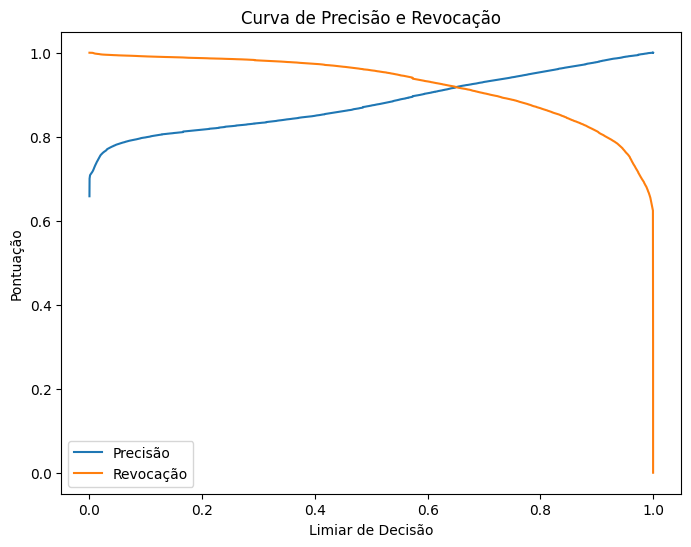

In [203]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(observado, predicao)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precisão')
plt.plot(thresholds, recall[:-1], label='Revocação')
plt.xlabel('Limiar de Decisão')
plt.ylabel('Pontuação')
plt.title('Curva de Precisão e Revocação')
plt.legend(loc='lower left')
plt.show()


In [280]:
conf_matrix = confusion_matrix(observado, predicoes_binarias)

df_conf_matrix = pd.DataFrame(conf_matrix, index=['Real Negativo', 'Real Positivo'], columns=['Predito Negativo', 'Predito Positivo'])
print("Matriz de Confusão:")
df_conf_matrix 

Matriz de Confusão:


,Predito Negativo,Predito Positivo
Real Negativo,100407,17426
Real Positivo,19551,207397


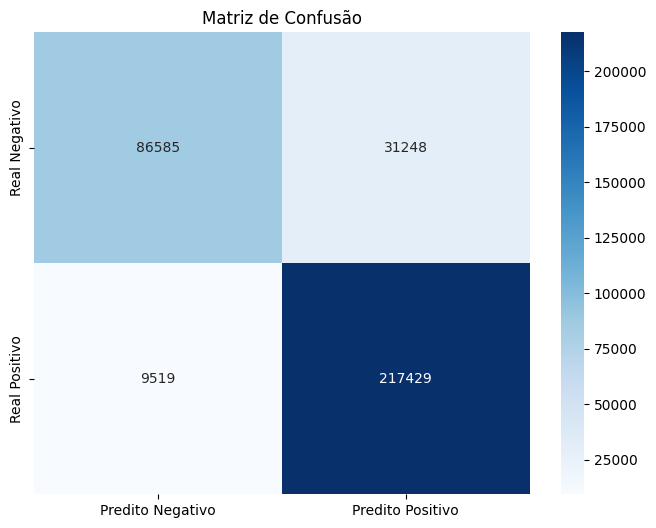

In [256]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

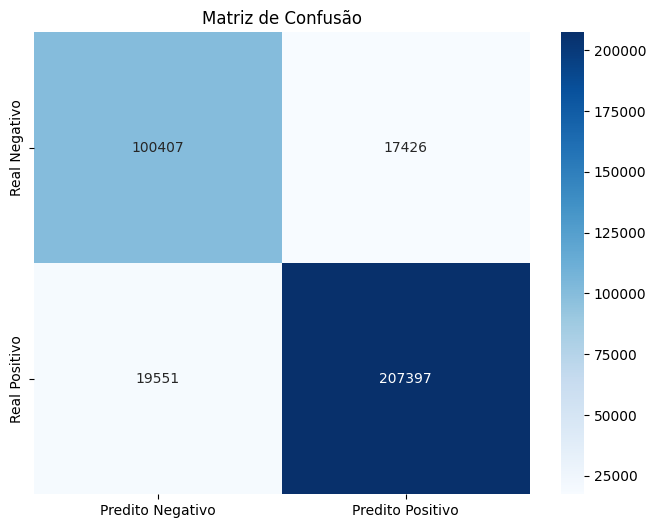

In [281]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

In [282]:
acuracia = accuracy_score(observado, predicoes_binarias)
roc_auc = roc_auc_score(observado, predicao)
precisao = precision_score(observado, predicoes_binarias)
revocacao = recall_score(observado, predicoes_binarias)
f1 = f1_score(observado, predicoes_binarias)
print(f"Accuracia: {acuracia}")
print(f"ROC AUC: {roc_auc}")
print(f"Precisão: {precisao}")
print(f"Revocação (Sensibilidade): {revocacao}")
print(f"F1 Score: {f1}")

Accuracia: 0.8927522108236823
ROC AUC: 0.9640764453631063
Precisão: 0.9224901366853036
Revocação (Sensibilidade): 0.9138525124698169
F1 Score: 0.918151010135666


# Achando limiar para corte

In [221]:
predicao = pd.DataFrame(predicao).rename(columns={0:'prob'})
predicao

,prob
0,0.005363
1,0.999948
2,0.999976
3,0.999864
4,0.999928
...,...
344776,0.999922
344777,0.999917
344778,0.999928
344779,0.999950


In [222]:
def calcular_f1(y_true, y_prob, ponto_de_corte):
    y_pred = (y_prob >= ponto_de_corte).astype(int)
    conf_matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return conf_matrix, f1

In [235]:
hist_f1 = []

for ponto_de_corte in np.linspace(0.0, 0.99, num=50):
    conf_matrix, f1 = calcular_f1(observado.values, predicao['prob'].values, ponto_de_corte)
    hist_f1.append(f1)

Realizar um gráfico

In [241]:
pd.DataFrame({'f1_score': hist_f1, 'Limiar' : np.linspace(0.0, 0.99, num=50)}).sort_values(by='f1_score', ascending=False)

,f1_score,Limiar
33,0.918161,0.666735
32,0.918058,0.646531
31,0.917641,0.626327
30,0.917324,0.606122
28,0.917284,0.565714
34,0.917153,0.686939
29,0.917039,0.585918
27,0.916549,0.545510
35,0.916339,0.707143
26,0.915452,0.525306


In [200]:
#def calcular_f1(conjunto_y_predicao, predicao, ponto_de_corte):
ponto_de_corte = 0.7

condicao = lambda prob: 1 if prob >= ponto_de_corte else 0
predicao['label_predito'] = predicao['prob'].apply(condicao)
conf_matrix = confusion_matrix(observado, predicao['label_predito'])

,prob,label_predito
0,0.005363,0
1,0.999948,1
2,0.999976,1
3,0.999864,1
4,0.999928,1
...,...,...
344776,0.999922,1
344777,0.999917,1
344778,0.999928,1
344779,0.999950,1


# RESÍDUOS

In [143]:
fechado = df_resultado_predict.query('aberto == 1')
fechado = fechado[['id_contribuinte', 'dam', 'id_imovel', 'ano',
                      'aberto','vlr_aberto', 'vlr_pago',
                      'perc_hist_pago', 'pagamento','percentual_pago', 'predicao']]
fechado

,id_contribuinte,dam,id_imovel,ano,aberto,vlr_aberto,vlr_pago,perc_hist_pago,pagamento,percentual_pago,predicao
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,1,1158.44,0.00,0.215976,0,0.000000,0.005363
52,00014b72ca2a255bd4613fe022d53698,b1c496061b8ce3d290ecf5aaf6be6eb7,a60c24f0ce2caa81,2023.0,1,158.06,601.86,0.988763,0,0.792004,0.426663
59,0001de7df29f8e85cd124eb8021f7dca,01978e90d064ce5090ecf5aaf6be6eb7,46db76d53b87a4d8,2023.0,1,723.45,0.00,0.830163,0,0.000000,0.764594
61,0001de7df29f8e85cd124eb8021f7dca,0619ff80758de57790ecf5aaf6be6eb7,74c6887d5d9693b3,2023.0,1,837.12,0.00,0.830163,0,0.000000,0.764594
95,000473f4656786d9d4613fe022d53698,79fa28d80ba2d56290ecf5aaf6be6eb7,cabfecc5d23c6b25,2023.0,1,1617.52,349.97,0.165668,0,0.177876,0.358172
...,...,...,...,...,...,...,...,...,...,...,...
1924577,fffafcbc80a2ab2a1603ecd7ff6be21f,86276918391d68af90ecf5aaf6be6eb7,c79c2476626fa4b6,2023.0,1,584.32,0.00,0.948412,0,0.000000,0.433094
1924591,fffb82ff0c4ef8050246e2b93c1bf25c,49f07d673525777290ecf5aaf6be6eb7,263e230ea43a5599,2023.0,1,1858.33,0.00,0.779606,0,0.000000,0.106547
1924618,fffd0aa05b3e4fc40246e2b93c1bf25c,fa2c3a923b7b4b0e90ecf5aaf6be6eb7,15bdd971a7d7d41f,2023.0,1,53598.73,0.00,0.000000,0,0.000000,0.000908
1924667,fffebe9391e14292344d77602867ec09,6f517958573e53a490ecf5aaf6be6eb7,d72c8cf6239e3a33,2023.0,1,891.53,0.00,1.000000,0,0.000000,0.427247


In [161]:
fechado.query('predicao < 0.3')

,id_contribuinte,dam,id_imovel,ano,aberto,vlr_aberto,vlr_pago,perc_hist_pago,pagamento,percentual_pago,predicao,suposto_valor,teste
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,1,1158.44,0.00,0.215976,0,0.000000,0.005363,6.213184,0.0
109,0004bd531fda61538e79cf1867e8cc19,b5222231f94b1ad990ecf5aaf6be6eb7,2c3036b2376c2db0,2023.0,1,874.54,1163.58,0.916442,0,0.570908,0.008220,7.188923,0.0
128,000554c5705b8f31be91dcec7d89e48e,e3ae1b77796240e990ecf5aaf6be6eb7,5f537f5f4c7b5d64,2023.0,1,2380.49,0.00,0.056240,0,0.000000,0.031643,75.326411,0.0
129,000554c5705b8f31be91dcec7d89e48e,f95f47c273ea17ef90ecf5aaf6be6eb7,0fd2704b768f5ec1,2023.0,1,374.46,0.00,0.056240,0,0.000000,0.031643,11.849127,0.0
159,000627afce004bd2d4613fe022d53698,22aa8e376d9d148090ecf5aaf6be6eb7,5c7d6bee95365501,2023.0,1,367.22,0.00,0.000000,0,0.000000,0.000012,0.004383,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924500,fff868fe74d35da132175365651800be,00280eb7fce9466d90ecf5aaf6be6eb7,4b5aef2190550a0c,2023.0,1,494.91,1706.72,0.746693,0,0.775207,0.006686,3.308865,0.0
1924507,fff89d7fb9647523344d77602867ec09,31f21c8d0490bd2c90ecf5aaf6be6eb7,c22797027f2a13ae,2023.0,1,333.36,639.45,0.783972,0,0.657323,0.146175,48.728852,0.0
1924533,fff9325728d059d81603ecd7ff6be21f,b9777d55547bde3d90ecf5aaf6be6eb7,b3503af7cfe8182f,2023.0,1,837.89,0.00,0.000000,0,0.000000,0.000427,0.358134,0.0
1924591,fffb82ff0c4ef8050246e2b93c1bf25c,49f07d673525777290ecf5aaf6be6eb7,263e230ea43a5599,2023.0,1,1858.33,0.00,0.779606,0,0.000000,0.106547,197.999400,0.0


In [155]:
# fechado['teste'] = (fechado['predicao'] > 0.90).astype(float)
fechado['suposto_valor'] = fechado['predicao'] * fechado['vlr_aberto']

In [149]:
formatar_moeda(fechado['vlr_aberto'].sum())

'R$ 291.039.441,82'

In [156]:
formatar_moeda(fechado['suposto_valor'].sum())

'R$ 81.532.674,20'

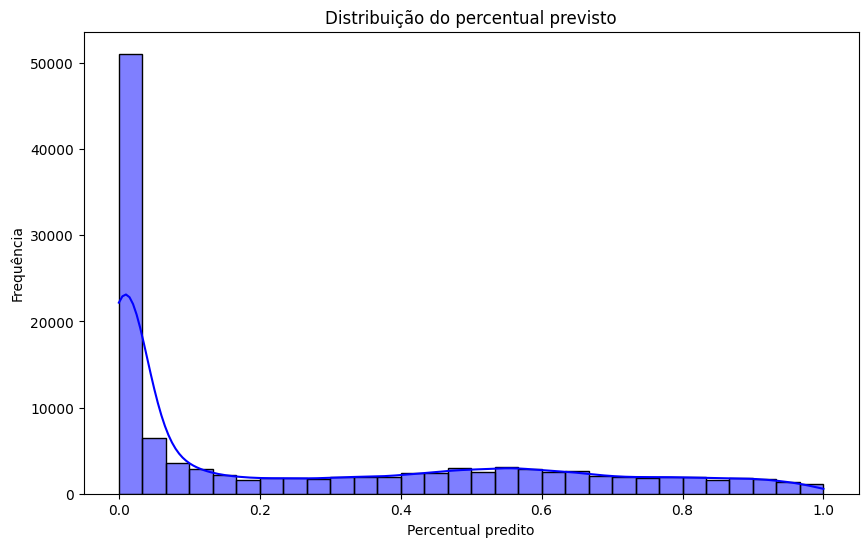

In [159]:
plt.figure(figsize=(10, 6))
sns.histplot(fechado['predicao'], kde=True, color='blue', bins=30)
plt.title('Distribuição do percentual previsto')
plt.xlabel('Percentual predito')
plt.ylabel('Frequência')
plt.show()

## Avaliação dos resíduos diferentes de 0 e 1 

In [125]:
fechado['residuos'] =  fechado['percentual_pago'] - fechado['predicao']
resid = fechado[['predicao', 'percentual_pago', 'residuos']]
resid = resid.sort_values(by = 'residuos', ascending = False)
resid_not0 = resid[resid['predicao'] != 0]
resid_not0_not1 = resid_not0[resid_not0['predicao'] != 1]
resid_not0_not1 

,predicao,percentual_pago,residuos
371986,0.000150,1.0,0.999850
1090594,0.000488,1.0,0.999512
1160659,0.000594,1.0,0.999406
325407,0.001184,1.0,0.998816
1517289,0.001395,1.0,0.998605
...,...,...,...
301409,0.999998,1.0,0.000002
301389,0.999998,1.0,0.000002
301374,0.999998,1.0,0.000002
301029,0.999998,1.0,0.000002


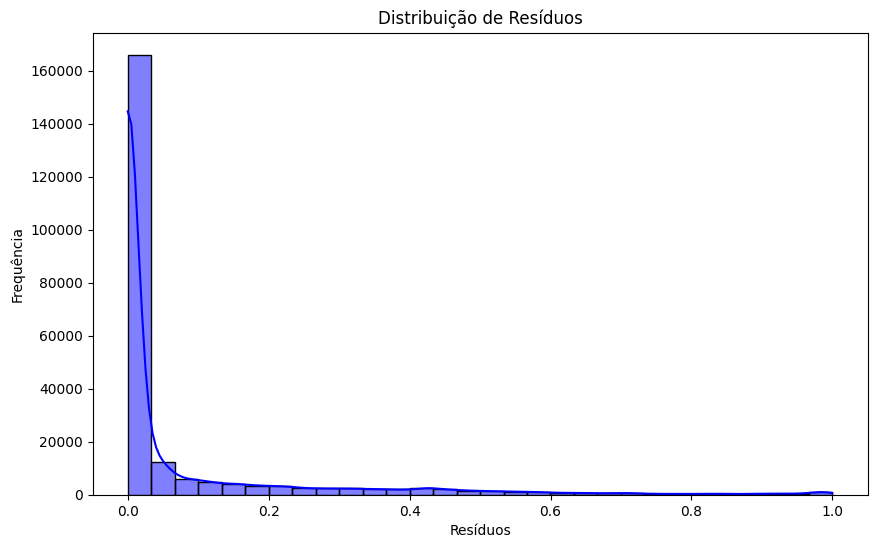

In [130]:
plt.figure(figsize=(10, 6))
sns.histplot(fechado['residuos'], kde=True, color='blue', bins=30)
plt.title('Distribuição de Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()

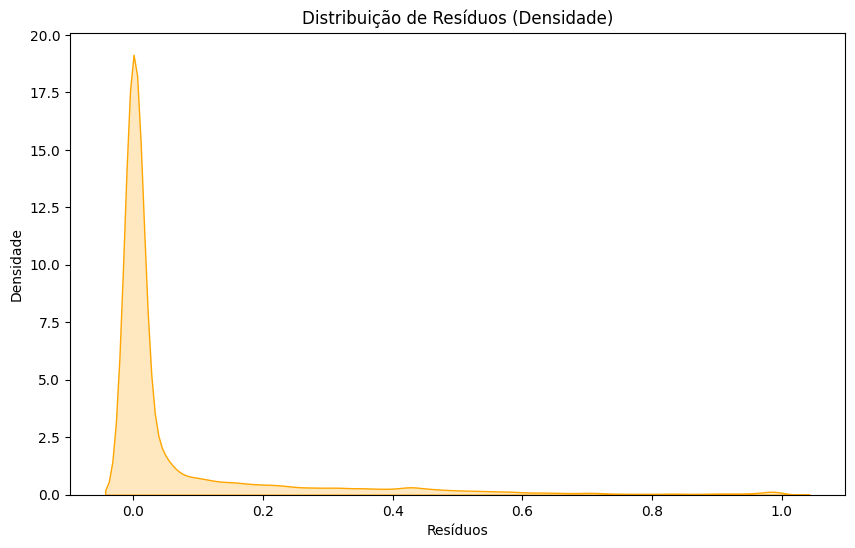

In [131]:
# Ou crie um gráfico de densidade
plt.figure(figsize=(10, 6))
sns.kdeplot(fechado['residuos'], fill=True, color='orange')
plt.title('Distribuição de Resíduos (Densidade)')
plt.xlabel('Resíduos')
plt.ylabel('Densidade')
plt.show()


In [126]:
def paste_intervalo(row):
    return "[" + str(row['inf']) + ", " + str(row['sup']) + ")"

data_percentil = {
    'inf': [-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75],
    'sup': [-0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
}
[-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]

# Creating a DataFrame from the dictionary
df_cut_percentil = pd.DataFrame(data_percentil)

df_cut_percentil['intervalo'] = df_cut_percentil.apply(paste_intervalo, axis = 1)
df_cut_percentil

,inf,sup,intervalo
0,-1.00,-0.75,"[-1.0, -0.75)"
1,-0.75,-0.50,"[-0.75, -0.5)"
2,-0.50,-0.25,"[-0.5, -0.25)"
3,-0.25,-0.20,"[-0.25, -0.2)"
4,-0.20,-0.15,"[-0.2, -0.15)"
5,-0.15,-0.10,"[-0.15, -0.1)"
6,-0.10,-0.05,"[-0.1, -0.05)"
7,-0.05,0.00,"[-0.05, 0.0)"
8,0.00,0.05,"[0.0, 0.05)"
9,0.05,0.10,"[0.05, 0.1)"


In [127]:
# Define the bins and labels for groups
igr_bins = [-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
igr_labels = df_cut_percentil['intervalo']

resid['resid_faixas'] = pd.cut(resid['residuos'], 
                                bins = igr_bins, 
                                labels = igr_labels, 
                                right = False)

# Criar a tabela de contingência
df_summary_residuos = resid.groupby('resid_faixas')['resid_faixas'].count().to_frame()
total = df_summary_residuos['resid_faixas'].sum()
df_summary_residuos['perc'] = np.round(df_summary_residuos['resid_faixas']/total, 5)
df_summary_residuos

,resid_faixas,perc
resid_faixas,,
"[-1.0, -0.75)",0,0.00000
"[-0.75, -0.5)",0,0.00000
"[-0.5, -0.25)",0,0.00000
"[-0.25, -0.2)",0,0.00000
"[-0.2, -0.15)",0,0.00000
"[-0.15, -0.1)",0,0.00000
"[-0.1, -0.05)",0,0.00000
"[-0.05, 0.0)",0,0.00000
"[0.0, 0.05)",173712,0.76543


In [128]:
igr_bins = [-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
igr_labels = df_cut_percentil['intervalo']

resid['resid_faixas'] = pd.cut(resid['residuos'], bins=igr_bins, labels=igr_labels, right=False)

df_summary_residuos = resid.groupby('resid_faixas').agg(
    {'residuos': 'mean', 'percentual_pago': 'mean', 'resid_faixas': 'count'}
).rename(columns={'resid_faixas': 'frequencia'})

df_summary_residuos['perc'] = df_summary_residuos['frequencia'] / df_summary_residuos['frequencia'].sum() * 100
df_summary_residuos

,residuos,percentual_pago,frequencia,perc
resid_faixas,,,,
"[-1.0, -0.75)",NaN,NaN,0,0.000000
"[-0.75, -0.5)",NaN,NaN,0,0.000000
"[-0.5, -0.25)",NaN,NaN,0,0.000000
"[-0.25, -0.2)",NaN,NaN,0,0.000000
"[-0.2, -0.15)",NaN,NaN,0,0.000000
"[-0.15, -0.1)",NaN,NaN,0,0.000000
"[-0.1, -0.05)",NaN,NaN,0,0.000000
"[-0.05, 0.0)",NaN,NaN,0,0.000000
"[0.0, 0.05)",0.003727,1.0,173712,76.542644


In [123]:
df_summary_residuos = df_summary_residuos.rename(columns = {'resid_faixas':'freq'})
df_summary_residuos = df_summary_residuos.reset_index()
df_summary_residuos

,resid_faixas,freq,perc
0,"[-1.0, -0.75)",0,0.00000
1,"[-0.75, -0.5)",0,0.00000
2,"[-0.5, -0.25)",0,0.00000
3,"[-0.25, -0.2)",0,0.00000
4,"[-0.2, -0.15)",0,0.00000
5,"[-0.15, -0.1)",0,0.00000
6,"[-0.1, -0.05)",0,0.00000
7,"[-0.05, 0.0)",0,0.00000
8,"[0.0, 0.05)",173712,0.76543
9,"[0.05, 0.1)",10863,0.04787


In [129]:
residuos_faixa_erro = fechado.query('(residuos >= 0.75) & (residuos <= 1.0)')
# residuos_faixa_acerto = df_resultado_predict.query('(residuos >= 0.00) & (residuos <= 0.05)')
residuos_faixa_erro

,id_contribuinte,dam,id_imovel,ano,aberto,vlr_aberto,vlr_pago,perc_hist_pago,pagamento,percentual_pago,predicao,residuos
192,000777f57c8049368dd06342399984d9,7c39c6ca0cd480bc90ecf5aaf6be6eb7,bc3471350be601d8,2023.0,0,0.0,657.20,0.997733,1,1.0,0.007437,0.992563
255,000a8913b4e31d3d8e79cf1867e8cc19,f365a540a09f16e490ecf5aaf6be6eb7,71711296a8eaa8bb,2023.0,0,0.0,264.32,0.595292,1,1.0,0.094502,0.905498
1752,002997e93d88f909dd9a3cb674b9fb28,f32c4045a12788cb90ecf5aaf6be6eb7,24a29af8f3da6850,2023.0,0,0.0,4019.30,0.978841,1,1.0,0.016583,0.983417
2281,003d77b4d5acedcfcd124eb8021f7dca,144762e90b2ecd9790ecf5aaf6be6eb7,e9e5813660513601,2023.0,0,0.0,1430.10,0.609960,1,1.0,0.171076,0.828924
3623,007719db01137158ec24828071529570,cd58ecb5f4e1305690ecf5aaf6be6eb7,22a2b66ba2b6cdeb,2023.0,0,0.0,1471.30,0.975492,1,1.0,0.202907,0.797093
...,...,...,...,...,...,...,...,...,...,...,...,...
1920051,ff5a338d6b0d75cd9daa7b7dbb545c1c,249c68ff79a85d1590ecf5aaf6be6eb7,94054c7ea04851c0,2023.0,0,0.0,4485.79,0.979829,1,1.0,0.015675,0.984325
1920449,ff6804b40ae92ca8d8b209292c0ce31d,060b63d5a2d819f290ecf5aaf6be6eb7,bedd84876b363f35,2023.0,0,0.0,913.50,0.818445,1,1.0,0.183547,0.816453
1920586,ff6d015ffecc66f08e79cf1867e8cc19,045610abe0f9056090ecf5aaf6be6eb7,63996a8c5cfa2c8a,2023.0,0,0.0,330.39,0.455860,1,1.0,0.205902,0.794098
1920911,ff73d569207c0bec1172306dd24a62d3,8630975b13c7462090ecf5aaf6be6eb7,6e7cc7b0a23776f3,2023.0,0,0.0,1870.49,0.497761,1,1.0,0.124932,0.875068


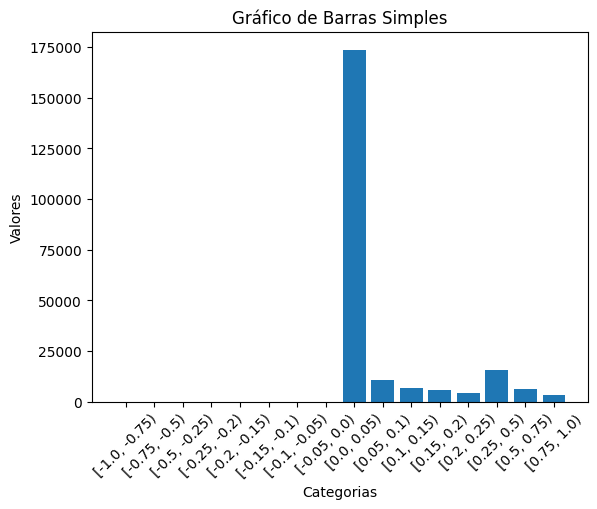

In [124]:
categorias = df_summary_residuos['resid_faixas']
valores = df_summary_residuos['freq']
plt.bar(categorias, valores)
plt.xlabel('Categorias')
plt.ylabel('Valores')
plt.title('Gráfico de Barras Simples')
plt.xticks(rotation=45)
plt.show()

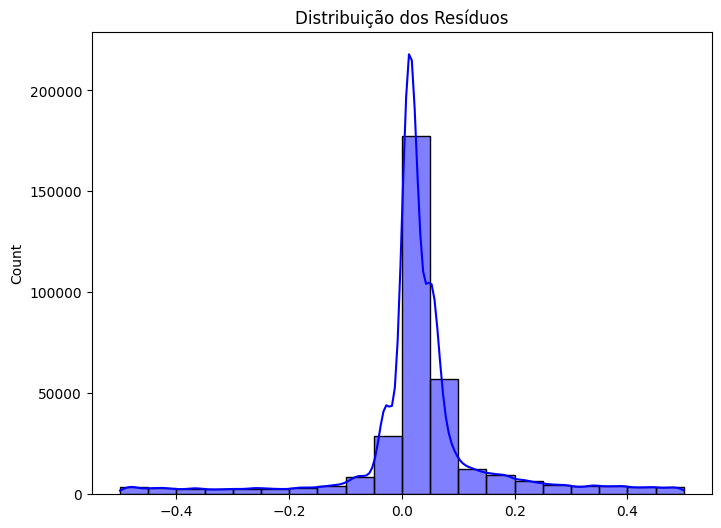

In [233]:
residuos = y_pred_test_23 - y_pred_proba_teste_23
plt.figure(figsize=(8, 6))
sns.histplot(residuos, bins=20, kde=True, color='blue')
plt.title('Distribuição dos Resíduos')
plt.show()